# Imports

In [1]:
# === OPTIMIERTE IMPORTS UND KONFIGURATION ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import warnings

# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Performance-Optimierungen
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('default')  # Bessere Plot-Qualität
sns.set_palette("husl")

# Konsistente Plot-Konfiguration
FIGSIZE_LARGE = (15, 10)
FIGSIZE_MEDIUM = (12, 8)
FIGSIZE_SMALL = (10, 6)
DPI = 100

# Setze matplotlib Parameter für bessere Qualität
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['savefig.dpi'] = DPI
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

print("✅ Alle Libraries erfolgreich importiert und konfiguriert")
print(f"📊 Pandas Version: {pd.__version__}")
print(f"🔢 NumPy Version: {np.__version__}")
print(f"📈 Matplotlib konfiguriert mit DPI: {DPI}")

✅ Alle Libraries erfolgreich importiert und konfiguriert
📊 Pandas Version: 2.2.3
🔢 NumPy Version: 2.2.5
📈 Matplotlib konfiguriert mit DPI: 100


# Problemdefinition

Unternehmensstandorte entstehen nicht zufällig, sondern sind Ergebnis gezielter politischer Steuerung, infrastruktureller Rahmenbedingungen und sozioökonomischer Dynamiken. Gerade in einer Metropole wie Berlin, die durch Heterogenität, Wachstum und räumliche Disparitäten geprägt ist, wird die strategische Bedeutung der Standortwahl besonders deutlich.
Die Lage von Unternehmen beeinflusst nicht nur deren betriebswirtschaftliche Performance, sondern auch stadtstrukturelle Prozesse wie die Entwicklung von Gewerbegebieten, die Auslastung von Infrastrukturen oder die soziale Zusammensetzung von Quartieren. Standortentscheidungen wirken damit sowohl auf der Mikroebene einzelner Betriebe als auch auf der Makroebene urbaner Entwicklung.

In einer wachsenden und dynamischen Stadt wie Berlin spielt die räumliche Verteilung und Charakteristik von Unternehmensstandorten eine zentrale Rolle für wirtschaftliche Entwicklung, Stadtplanung und Standortförderung. Eine zentrale Fragestellung in diesem Kontext lautet: 

- *Inwiefern lassen sich durch Clusteranalysen verschiedene Typen von Unternehmensstandorten in Berlin identifizieren, und wie unterscheiden sie sich hinsichtlich Bevölkerungsstruktur und wirtschaftlicher Ausrichtung?*

**Was bedeutet das konkret?**

Durch Clustering werden ähnliche Unternehmensstandorte gruppiert in Berlin anhand von:
- Unternehmenstyp (z.B. Größe, Branche, Unternehmensalter)
- Sozialstruktur der Nachbarschaft (Bodenrichtwert, Einwohnerzahl, Alter der Einwohner, Einwohnerdichte)
- Räumliche Faktoren (Bezirk, Typ der Fläche)


**Warum könnte dies relevant sein?**
- Identifizierung typische Standortprofile:  
  z.B. „Gewerbestandorte mit älterer Bevölkerung und niedrigem Bodenrichtwert“ vs. „Innovative Standorte mit jungen Menschen und hohen Immobilienwerten“.
- Die Ergebnisse können der IHK oder Stadtplanern helfen, zu verstehen, welche Art von Unternehmen sich wo ansiedeln und warum, sowie welche Faktoren eine Standortwahl beeinflussen.
- Daraus könnten gezielte Standortförderungen oder Stadtentwicklungsmaßnahmen abgeleitet werden.

**Wie könnte man das methodisch umsetzen?**
- Feature-Auswahl:
  - `Bodenrichtwert`, `business_age`
  - Demografische Merkmale: `ew2023`, `ew_ha_2023`
  - Wirtschaftszweige: `Branche_grob`
  - Räumliche Merkmale: `Bezirk`


- **Clustering-Verfahren**:
  - KMeans, DBSCAN oder hierarchisches Clustering
  - Nach Clusterbildung: Interpretation der Cluster (z.B. Visualisierung mit Geo-Karten)


**Typische Fragestellungen, die sich daraus ableiten:**
- Welche Standorttypen ziehen junge oder innovative Unternehmen an?
- Gibt es klar definierte Cluster mit ähnlicher Altersstruktur oder wirtschaftlichen Aktivitäten?
- Welche Standorttypen haben hohen Bodenrichtwert und welche Faktoren begünstigen diesen?


**Nutzen des Ergebnisses:**

Die Cluster-Ergebnisse ermöglichen eine zielgerichtete Standortplanung, gezielte Förderpolitik sowie ein verbessertes Verständnis der lokalen Wirtschaftsstruktur Berlins. Diese Problemstellung eignet sich hervorragend, um die Daten mittels Clustering sinnvoll zu analysieren und strategisch wertvolle Erkenntnisse zu gewinnen!

# Datenauswahl

**Um das Problem anzugehen wurden folgende Daten verwendet:**
- IHK Gewerbedaten
    - beinhaltet ca. 350.000 Gewerbedaten in Berlin
    - URL: https://www.ihk.de/berlin/service-und-beratung/digitalisierung/open-data-5691102
- Bodenrichtwert 2024
    - beinhaltet den Gründstückswert in Berlin, der aus den Gutachterauschuss entanden ist
    - URL: https://daten.berlin.de/datensaetze/bodenrichtwerte-01-01-2024-wfs-c2092cb3
- Einwohnerdichte
    - beinhaltet die Anzahl an Einwohner sowie Dichte in Berlin
    - URL: https://daten.berlin.de/datensaetze/einwohnerdichte-2023-umweltatlas-wfs-b4eb74c4

In den jeweiligen Notebooks mit "data_preprocessing_" werden die einzelnen Datensätze genauer analysiert.

In [2]:
df = pd.read_csv("../input/ihk_gewerbedaten_with_brw_einwohnerdichte.csv.gz",
                 compression="gzip",
                 header=0,
                 sep=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336180 entries, 0 to 336179
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   opendata_id          336180 non-null  int64  
 1   city                 336180 non-null  object 
 2   postcode             336180 non-null  int64  
 3   latitude             336180 non-null  float64
 4   longitude            336180 non-null  float64
 5   ihk_branch_id        336180 non-null  float64
 6   employees_range      336180 non-null  object 
 7   ihk_branch_desc      336180 non-null  object 
 8   business_age         336180 non-null  float64
 9   business_type        336180 non-null  object 
 10  Bezirk               336180 non-null  object 
 11  planungsraum_id      336180 non-null  float64
 12  Planungsraum         336180 non-null  object 
 13  Bezirksregion        336180 non-null  object 
 14  Prognoseraum         336180 non-null  object 
 15  Ortsteil         

# Erweiterte Explorative Datenanalyse (EDA)

**Ziele der EDA:**
1. **Datenqualität prüfen**: Missing Values, Outliers, Inkonsistenzen
2. **Verteilungen verstehen**: Schiefe, Normalität, extreme Werte
3. **Beziehungen aufdecken**: Korrelationen, Muster, Segmente
4. **Feature-Engineering informieren**: Transformationen, neue Features
5. **Clustering-Vorbereitung**: Skalierung, Encoding-Strategien

**Systematisches Vorgehen:**
- Einzelne Features verstehen
- Paarweise Beziehungen 
- Komplexe Muster
- Räumliche Verteilungen
- Interpretation für Standortanalyse

In [3]:
# 1. DATENQUALITÄTSPRÜFUNG

print("=== DATENQUALITÄTSBERICHT ===")
print(f"📊 Datensatz-Dimensionen: {df.shape}")
print(f"🏢 Anzahl Unternehmen: {len(df):,}")
print(f"📍 Anzahl Features: {len(df.columns)}")

# Missing Values Analyse
print("\n=== MISSING VALUES ANALYSE ===")
missing_analysis = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Data_Type': df.dtypes
})
missing_analysis = missing_analysis[missing_analysis['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

if len(missing_analysis) > 0:
    print(missing_analysis)
else:
    print("✅ Keine Missing Values gefunden!")

# Duplikate prüfen
print(f"\n=== DUPLIKATE ===")
duplicates = df.duplicated().sum()
print(f"Duplikate gefunden: {duplicates}")

if duplicates > 0:
    print("⚠️ Duplikate entdeckt - weitere Analyse erforderlich")
else:
    print("✅ Keine Duplikate gefunden")

# Grundlegende Statistiken für numerische Features
print(f"\n=== NUMERISCHE FEATURES ÜBERSICHT ===")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerische Features: {len(numeric_cols)}")
print(f"Features: {numeric_cols}")

# Datentyp-Verteilung
print(f"\n=== DATENTYP-VERTEILUNG ===")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"{dtype}: {count} Features")

# Eindeutige Werte pro Feature (für kategoriale Features)
print(f"\n=== KARDINALITÄT KATEGORISCHER FEATURES ===")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count:,} eindeutige Werte")
    if unique_count <= 20:  # Zeige Werte wenn wenige
        print(f"  Werte: {list(df[col].unique())}")
    else:
        print(f"  Top 5: {list(df[col].value_counts().head().index)}")

df.info()

=== DATENQUALITÄTSBERICHT ===
📊 Datensatz-Dimensionen: (336180, 32)
🏢 Anzahl Unternehmen: 336,180
📍 Anzahl Features: 32

=== MISSING VALUES ANALYSE ===
✅ Keine Missing Values gefunden!

=== DUPLIKATE ===
Duplikate gefunden: 0
✅ Keine Duplikate gefunden

=== NUMERISCHE FEATURES ÜBERSICHT ===
Numerische Features: 22
Features: ['opendata_id', 'postcode', 'latitude', 'longitude', 'ihk_branch_id', 'business_age', 'planungsraum_id', 'employees_numerical', 'gründungsjahr', 'Bodenrichtwert', 'ew2023', 'flalle', 'ha', 'ew_ha_2023', 'alter_u6', 'alter_6_u10', 'alter_10_u18', 'alter_18_u65', 'alter_65_u70', 'alter_70_u75', 'alter75_u80', 'alter_80plus']

=== DATENTYP-VERTEILUNG ===
float64: 19 Features
object: 10 Features
int64: 3 Features

=== KARDINALITÄT KATEGORISCHER FEATURES ===
city: 1 eindeutige Werte
  Werte: ['Berlin']
employees_range: 15 eindeutige Werte
  Werte: ['0 Beschäftigte', '4 - 6 Beschäftigte', '1 - 3 Beschäftigte', '200 - 499 Beschäftigte', '7 - 9 Beschäftigte', '20 - 49 Besch

| Column        | Description |
| ------------- | ------------- |
| opendata_id           | Primary key |
| city                  | City of the business |
| postcode              | Postcode of the business |
| latitude              | Geolocation of the business, described by the latitude (Format: EPSG 4326) |
| longitude             | Geolocation of the business, described by the longitude (Format: EPSG 4326) |
| ihk_branch_id         | Branch ID of the business as defined by IHK classification of economic activities (finest granuality of distinction), see [IHK Wirtschaftszweige](https://www.ihk.de/blueprint/servlet/resource/blob/5186288/c8bb510197a45c71b59b7a27cdc31bcb/wzbra-wahlgruppen-fit-data.pdf) |
| employees_range       | The reported number of employees as range  |
| ihk_branch_desc       | Branch description of the business as defined by IHK classification of economic activities|
| business_age          | Current age of the business |
| business_type         | "Kleingewerbetreibender" = the business is a small trader, "im Handelsregister eingetragen" = the business is registered in the Commercial Register  |
| Bezirk                | Bezirk of the business |
| planungsraum_id       | LOR Planungsraum ID |
| Planungsraum          | LOR Planungsraum |
| Bezirksregion         | LOR Bezirksregion |
| Prognoseraum          | LOR Prognoseraum  |
| Ortsteil              | Ortsteil of the business |
|employees_numerical    | Der Durchschnitt aus den 2 Grenzen von employees_range |
|gründungsjahr          | Das Gründungsjahr berechnet von letztem Commit (Datum) an der CSV Datei von der IHK subtrahiert mit dem business_age |
|Bodenrichtwert         | Der Bodenrichtwert vom Stand 01.01.2024 |
|ew2023                 | Anzahl Einwohner > 2 vom Stand 01.01.2023 im Viertel|
|flalle                 | Flächengröße [m²] vom Stand 01.01.2023 im Viertel|
|ha                     | Flächengröße der ISU5-Fläche vom Stand 01.01.2023 im Viertel|
|ew_ha_2023             | Einwohner pro Hektar vom Stand 01.01.2023 im Viertel|
|alter_u6               | Anzahl der Einwohner (> 2), die jünger als 6 Jahre sind vom Stand 01.01.2023 im Viertel|
| alter_6_u10           | Anzahl der Einwohner (> 2), die 6 bis unter 10 Jahre alt sind vom Stand 01.01.2023 im Viertel|
| alter_10_u18          | Anzahl der Einwohner (> 2), die 10 bis unter 18 Jahre alt sind vom Stand 01.01.2023  im Viertel|
| alter_18_u65          | Anzahl der Einwohner (> 2), die 18 bis unter 65 Jahre alt sind vom Stand 01.01.2023 im Viertel|
| alter_65_u70          | Anzahl der Einwohner (> 2), die 65 bis unter 70 Jahre alt sind vom Stand 01.01.2023 im Viertel|
| alter_70_u75          | Anzahl der Einwohner (> 2), die 70 bis unter 75 Jahre alt sind vom Stand 01.01.2023 im Viertel|
| alter75_u80           | Anzahl der Einwohner (> 2), die 75 bis unter 80 Jahre alt sind vom Stand 01.01.2023 im Viertel|
| alter_80plus          | Anzahl der Einwohner (> 2), die 80 Jahre alt oder älter sind vom Stand 01.01.2023 im Viertel|
| typklar               | Es werden 52 verschiedene Flächentypen unterschieden. Im Gegensatz zu den Nutzungen GRZ und WOZ wird hier besonders Wert auf eine differenzierte Darstellung der baulichen Nutzungen gelegt, die stadtstrukturell (Siedlungstyp, Alter etc.)  unterschieden werden. Die Flächentypen werden auch zur Zuordnung weitererer Indikatoren verwendet (Belagsklassen der Versiegelung, Kanalisation) |

In [4]:
df.head()

opendata_id    city  postcode   latitude  longitude  ihk_branch_id  \
0        572114  Berlin     10179  52.513315  13.411584        65122.0   
1     131831318  Berlin     10713  52.479296  13.319051        47430.0   
2  943032071440  Berlin     12047  52.486200  13.429312       731108.0   
3  927441671472  Berlin     10117  52.513509  13.385791         6831.0   
4  942996071320  Berlin     10245  52.513798  13.454217        62020.0   

      employees_range                                    ihk_branch_desc  \
0      0 Beschäftigte                   Schaden- u. Unfallversicherungen   
1      0 Beschäftigte          EH m. Geräten der Unterhaltungselektronik   
2      0 Beschäftigte                          Promotion, Propagandisten   
3  4 - 6 Beschäftigte  Vermittlung v. Grundstücken, Gebäuden u. Wohnu...   
4      0 Beschäftigte  Erbringung v. Beratungsleistungen auf dem Gebi...   

   business_age                   business_type                      Bezirk  \
0          40.0          Kleingewerbetreibender                       Mitte   
1          40.0          Kleingewerbetreibender  Charlottenburg-Wilmersdorf   
2          13.0  im Handelsregister eingetragen                    Neukölln   
3          10.0          Kleingewerbetreibender                       Mitte   
4          10.0  im Handelsregister eingetragen    Friedrichshain-Kreuzberg   

   planungsraum_id        Planungsraum             Bezirksregion  \
0        1100312.0  Heine-Viertel West            Alexanderplatz   
1        4501148.0     Brabanter Platz     Volkspark Wilmersdorf   
2        8100314.0         Donaustraße              Reuterstraße   
3        1100206.0    Unter den Linden         Regierungsviertel   
4        2500833.0    Boxhagener Platz  Frankfurter Allee Süd FK   

          Prognoseraum        Ortsteil  employees_numerical  gründungsjahr  \
0              Zentrum           Mitte                  0.0           1985   
1  Wilmersdorf Zentrum     Wilmersdorf                  0.0           1985   
2             Neukölln        Neukölln                  0.0           2012   
3              Zentrum           Mitte                  5.0           2015   
4   Friedrichshain Ost  Friedrichshain                  0.0           2015   

   Bodenrichtwert  ew2023    flalle    ha  ew_ha_2023  alter_u6  alter_6_u10  \
0          4500.0    47.0   7746.10  0.77       60.68       0.0          0.0   
1          2900.0   967.0  19832.12  1.98      487.59      59.0         33.0   
2           650.0   254.0   3813.11  0.38      666.12      18.0          3.0   
3           900.0    49.0   4826.26  0.48      101.53       3.0          0.0   
4         11000.0  1388.0  40300.94  4.03      344.41      88.0         41.0   

   alter_10_u18  alter_18_u65  alter_65_u70  alter_70_u75  alter75_u80  \
0          12.0          22.0           0.0           0.0         13.0   
1          63.0         668.0          40.0          27.0         34.0   
2          22.0         202.0           3.0           0.0          3.0   
3           3.0          37.0           3.0           3.0          0.0   
4          57.0        1157.0          16.0          10.0          6.0   

   alter_80plus                                            typklar  
0           0.0                                         Kerngebiet  
1          43.0  Geschlossene Blockbebauung, Hinterhof (1870er ...  
2           3.0  Geschlossene Blockbebauung, Hinterhof (1870er ...  
3           0.0                                         Kerngebiet  
4          13.0  Geschlossene Blockbebauung, Hinterhof (1870er ...

In [5]:
df.describe()

opendata_id       postcode       latitude      longitude  \
count  3.361800e+05  336180.000000  336180.000000  336180.000000   
mean   7.388164e+11   11830.460054      52.505327      13.385594   
std    2.820992e+12    1330.735172       0.045934       0.092684   
min    5.721140e+05   10115.000000      52.340481      13.096560   
25%    1.056209e+11   10587.000000      52.479203      13.323861   
50%    1.917686e+11   12055.000000      52.506552      13.386418   
75%    1.125918e+12   13088.000000      52.534013      13.435754   
max    6.816592e+13   14199.000000      52.660085      13.741143   

       ihk_branch_id   business_age  planungsraum_id  employees_numerical  \
count   3.361800e+05  336180.000000     3.361800e+05        336180.000000   
mean    8.956494e+05       9.382628     5.558229e+06             4.230252   
std     2.037052e+06       9.605879     3.340568e+06            83.367534   
min     0.000000e+00       0.000000     1.100101e+06             0.000000   
25%     5.911000e+04       2.000000     2.500834e+06             0.000000   
50%     8.810200e+04       7.000000     4.501045e+06             0.000000   
75%     7.022000e+05      14.000000     8.100207e+06             2.000000   
max     9.609094e+06     100.000000     1.260124e+07         12500.000000   

       gründungsjahr  Bodenrichtwert         ew2023        flalle  \
count  336180.000000   336180.000000  336180.000000  3.361800e+05   
mean     2015.617372     3065.466460     571.493129  3.206335e+04   
std         9.605879     3408.431222     534.104473  4.087861e+04   
min      1925.000000        0.600000       0.000000  4.375400e+02   
25%      2011.000000      700.000000     177.000000  1.405683e+04   
50%      2018.000000     2100.000000     446.000000  2.255440e+04   
75%      2023.000000     4500.000000     814.000000  3.455663e+04   
max      2025.000000    60000.000000    5766.000000  1.255814e+06   

                  ha     ew_ha_2023       alter_u6    alter_6_u10  \
count  336180.000000  336180.000000  336180.000000  336180.000000   
mean        3.206253     249.176705      31.760839      21.041457   
std         4.087950     181.169186      35.626643      25.895971   
min         0.040000       0.000000       0.000000       0.000000   
25%         1.410000      80.150000       9.000000       6.000000   
50%         2.260000     238.950000      23.000000      15.000000   
75%         3.460000     378.200000      45.000000      28.000000   
max       125.580000    1153.060000     424.000000     370.000000   

        alter_10_u18   alter_18_u65   alter_65_u70   alter_70_u75  \
count  336180.000000  336180.000000  336180.000000  336180.000000   
mean       38.210021     396.325311      23.511878      20.289262   
std        47.938997     366.619600      26.404323      24.778379   
min         0.000000       0.000000       0.000000       0.000000   
25%         9.000000     112.000000       6.000000       6.000000   
50%        26.000000     307.000000      18.000000      13.000000   
75%        51.000000     579.000000      32.000000      27.000000   
max       837.000000    3176.000000     320.000000     340.000000   

         alter75_u80   alter_80plus  
count  336180.000000  336180.000000  
mean       14.961262      25.393099  
std        19.804239      39.083397  
min         0.000000       0.000000  
25%         3.000000       6.000000  
50%         9.000000      15.000000  
75%        19.000000      30.000000  
max       300.000000     593.000000

## Branchen (grob) erstellen

Die Spalte `ihk_branch_id` setzt sich aus den jeweiligen Klassen aus der [Gliederung der Klassifikation der Wirtschaftszweige](https://www.destatis.de/DE/Methoden/Klassifikationen/Gueter-Wirtschaftsklassifikationen/Downloads/gliederung-klassifikation-wz-3100130089004.pdf?__blob=publicationFile&v=2).

Da es insgesamt 839 verschiedene Ausprägungen gibt, die sehr granular sind, werden die Branchen daher grob abgekürzt.

Als Bsp.:
- Abschnitt A (LAND- UND FORSTWIRTSCHAFT, FISCHEREI) enthält alle Abteilungen sowie Unterklassen von 01 bis 03

Daher wird ein Dictionary erstellt, bei dem jede Abteilung (die oberste Ebene eines Wirtschaftszweigs) als Key definiert ist und die dazugehörigen Abteilungen (die erste Stelle vor dem Komma entspricht der Abteilung) mit Min-Max als Value definiert sind.
Als Bsp.:
- Abschnitt A hat nur Abteilungen von 01 bis 03
- Abschnitt B hat nur Abteilungen von 05 bis 09
etc.

Somit werden für die Werte die Abteilung der jeweiligen `ihk_branch_id` herausgesucht und als `Branche_grob`definiert.

In [6]:
dic_wz = {
    "LAND- UND FORSTWIRTSCHAFT, FISCHEREI" : [1, 3],
    "ABERGBAU UND GEWINNUNG VON STEINEN UND ERDEN" : [5, 9],
    "VERARBEITENDES GEWERBE" : [10, 33],
    "ENERGIEVERSORGUNG" : [35, 35],
    "WASSERVERSORGUNG; ABWASSER- UND ABFALLENTSORGUNG UND BESEITIGUNG VON UMWELTVERSCHMUTZUNGEN" : [36, 39],
    "BAUGEWERBE" : [41, 43],
    "HANDEL; INSTANDHALTUNG UND REPARATUR VON KRAFTFAHRZEUGEN" : [45, 47],
    "VERKEHR UND LAGEREI" : [49, 53],
    "GASTGEWERBE" : [55, 56],
    "INFORMATION UND KOMMUNIKATION" : [58, 63],
    "ERBRINGUNG VON FINANZ- UND VERSICHERUNGSDIENSTLEISTUNGEN" : [64, 66],
    "GRUNDSTÜCKS- UND WOHNUNGSWESEN" : [68, 68],
    "ERBRINGUNG VON FREIBERUFLICHEN, WISSENSCHAFTLICHEN UND TECHNISCHEN DIENSTLEISTUNGEN" : [69, 75],
    "ERBRINGUNG VON SONSTIGEN WIRTSCHAFTLICHEN DIENSTLEISTUNGEN" : [77, 82],
    "ÖFFENTLICHE VERWALTUNG, VERTEIDIGUNG; SOZIALVERSICHERUNG" : [84, 84],
    "ERZIEHUNG UND UNTERRICHT" : [85, 85],
    "GESUNDHEITS- UND SOZIALWESEN" : [86, 88],
    "KUNST, UNTERHALTUNG UND ERHOLUNG" : [90, 93],
    "ERBRINGUNG VON SONSTIGEN DIENSTLEISTUNGEN" : [94, 96],
    "PRIVATE HAUSHALTE MIT HAUSPERSONAL; HERSTELLUNG VON WAREN UND ERBRINGUNG VON DIENSTLEISTUNGEN DURCH PRIVATE HAUSHALTE FÜR DEN EIGENBEDARF OHNE AUSGEPRÄGTEN SCHWERPUNKT" : [97, 98],
    "EXTERRITORIALE ORGANISATIONEN UND KÖRPERSCHAFTEN" : [99, 99]
}

In [7]:
def get_branche_grob(ihk_branch_id):
    if pd.isnull(ihk_branch_id):
        return np.nan
    
    ihk_id_int = int(str(int(ihk_branch_id))[:2])
    
    for branche, (low, high) in dic_wz.items():
        if low <= ihk_id_int <= high:
            return branche
    return np.nan

In [8]:
df["Branche_grob"] = df["ihk_branch_id"].apply(get_branche_grob)
df[["ihk_branch_id", "Branche_grob"]].head()

ihk_branch_id                                       Branche_grob
0        65122.0  ERBRINGUNG VON FINANZ- UND VERSICHERUNGSDIENST...
1        47430.0  HANDEL; INSTANDHALTUNG UND REPARATUR VON KRAFT...
2       731108.0  ERBRINGUNG VON FREIBERUFLICHEN, WISSENSCHAFTLI...
3         6831.0                     GRUNDSTÜCKS- UND WOHNUNGSWESEN
4        62020.0                      INFORMATION UND KOMMUNIKATION

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336180 entries, 0 to 336179
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   opendata_id          336180 non-null  int64  
 1   city                 336180 non-null  object 
 2   postcode             336180 non-null  int64  
 3   latitude             336180 non-null  float64
 4   longitude            336180 non-null  float64
 5   ihk_branch_id        336180 non-null  float64
 6   employees_range      336180 non-null  object 
 7   ihk_branch_desc      336180 non-null  object 
 8   business_age         336180 non-null  float64
 9   business_type        336180 non-null  object 
 10  Bezirk               336180 non-null  object 
 11  planungsraum_id      336180 non-null  float64
 12  Planungsraum         336180 non-null  object 
 13  Bezirksregion        336180 non-null  object 
 14  Prognoseraum         336180 non-null  object 
 15  Ortsteil         

In [10]:
df[df["Branche_grob"].isna()]["ihk_branch_id"].value_counts()

ihk_branch_id
0.0        211
8990.0       5
89200.0      1
8910.0       1
Name: count, dtype: int64

0 = ist keine Branche

89 = existiert nicht

In [11]:
df.dropna(subset=["Branche_grob"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 335962 entries, 0 to 336179
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   opendata_id          335962 non-null  int64  
 1   city                 335962 non-null  object 
 2   postcode             335962 non-null  int64  
 3   latitude             335962 non-null  float64
 4   longitude            335962 non-null  float64
 5   ihk_branch_id        335962 non-null  float64
 6   employees_range      335962 non-null  object 
 7   ihk_branch_desc      335962 non-null  object 
 8   business_age         335962 non-null  float64
 9   business_type        335962 non-null  object 
 10  Bezirk               335962 non-null  object 
 11  planungsraum_id      335962 non-null  float64
 12  Planungsraum         335962 non-null  object 
 13  Bezirksregion        335962 non-null  object 
 14  Prognoseraum         335962 non-null  object 
 15  Ortsteil             3

## Einzelne Features verstehen

**Unternehmensgrößen (employees_range)**

**Analyse-Fokus**: Verteilung der Mitarbeiterzahlen und deren Einfluss auf Clustering

In [12]:
# Detaillierte Mitarbeiter-Analyse
employee_counts = df["employees_range"].value_counts().sort_index()
total_companies = len(df)

print("=== UNTERNEHMENSGRÖSSENVERTEILUNG ===")
print(f"Gesamtanzahl Unternehmen: {total_companies:,}")
print("\nVerteilung nach Mitarbeiterzahl:")

for range_val, count in employee_counts.items():
    percentage = (count / total_companies) * 100
    print(f"{range_val}: {count:,} ({percentage:.1f}%)")

# Kumulative Verteilung
print(f"\nKumulative Analyse:")
cumulative = 0
for range_val, count in employee_counts.items():
    cumulative += count
    cum_percentage = (cumulative / total_companies) * 100
    print(f"≤ {range_val}: {cum_percentage:.1f}%")

# Business Insights
kleinstunternehmen = employee_counts.get('0', 0)
small_medium = employee_counts.get('1-9', 0) + employee_counts.get('10-49', 0)
large_companies = total_companies - kleinstunternehmen - small_medium

print(f"\n📊 Business Segmentierung:")
print(f"Kleinstunternehmen (0 MA): {kleinstunternehmen:,} ({(kleinstunternehmen/total_companies)*100:.1f}%)")
print(f"Klein/Mittel (1-49 MA): {small_medium:,} ({(small_medium/total_companies)*100:.1f}%)")
print(f"Größere Unternehmen (≥50 MA): {large_companies:,} ({(large_companies/total_companies)*100:.1f}%)")

employee_counts

=== UNTERNEHMENSGRÖSSENVERTEILUNG ===
Gesamtanzahl Unternehmen: 335,962

Verteilung nach Mitarbeiterzahl:
0 Beschäftigte: 227,715 (67.8%)
1 - 3 Beschäftigte: 75,680 (22.5%)
10 - 19 Beschäftigte: 7,290 (2.2%)
100 - 199 Beschäftigte: 841 (0.3%)
1000 - 2499 Beschäftigte: 86 (0.0%)
10000 und mehr Beschäftigte: 6 (0.0%)
20 - 49 Beschäftigte: 4,838 (1.4%)
200 - 499 Beschäftigte: 456 (0.1%)
2500 - 4999 Beschäftigte: 20 (0.0%)
4 - 6 Beschäftigte: 12,086 (3.6%)
50 - 99 Beschäftigte: 1,612 (0.5%)
500 - 999 Beschäftigte: 134 (0.0%)
5000 - 7499 Beschäftigte: 6 (0.0%)
7 - 9 Beschäftigte: 5,186 (1.5%)
7500 - 9999 Beschäftigte: 6 (0.0%)

Kumulative Analyse:
≤ 0 Beschäftigte: 67.8%
≤ 1 - 3 Beschäftigte: 90.3%
≤ 10 - 19 Beschäftigte: 92.5%
≤ 100 - 199 Beschäftigte: 92.7%
≤ 1000 - 2499 Beschäftigte: 92.8%
≤ 10000 und mehr Beschäftigte: 92.8%
≤ 20 - 49 Beschäftigte: 94.2%
≤ 200 - 499 Beschäftigte: 94.3%
≤ 2500 - 4999 Beschäftigte: 94.3%
≤ 4 - 6 Beschäftigte: 97.9%
≤ 50 - 99 Beschäftigte: 98.4%
≤ 500 - 99

employees_range
0 Beschäftigte                 227715
1 - 3 Beschäftigte              75680
10 - 19 Beschäftigte             7290
100 - 199 Beschäftigte            841
1000 - 2499 Beschäftigte           86
10000 und mehr Beschäftigte         6
20 - 49 Beschäftigte             4838
200 - 499 Beschäftigte            456
2500 - 4999 Beschäftigte           20
4 - 6 Beschäftigte              12086
50 - 99 Beschäftigte             1612
500 - 999 Beschäftigte            134
5000 - 7499 Beschäftigte            6
7 - 9 Beschäftigte               5186
7500 - 9999 Beschäftigte            6
Name: count, dtype: int64

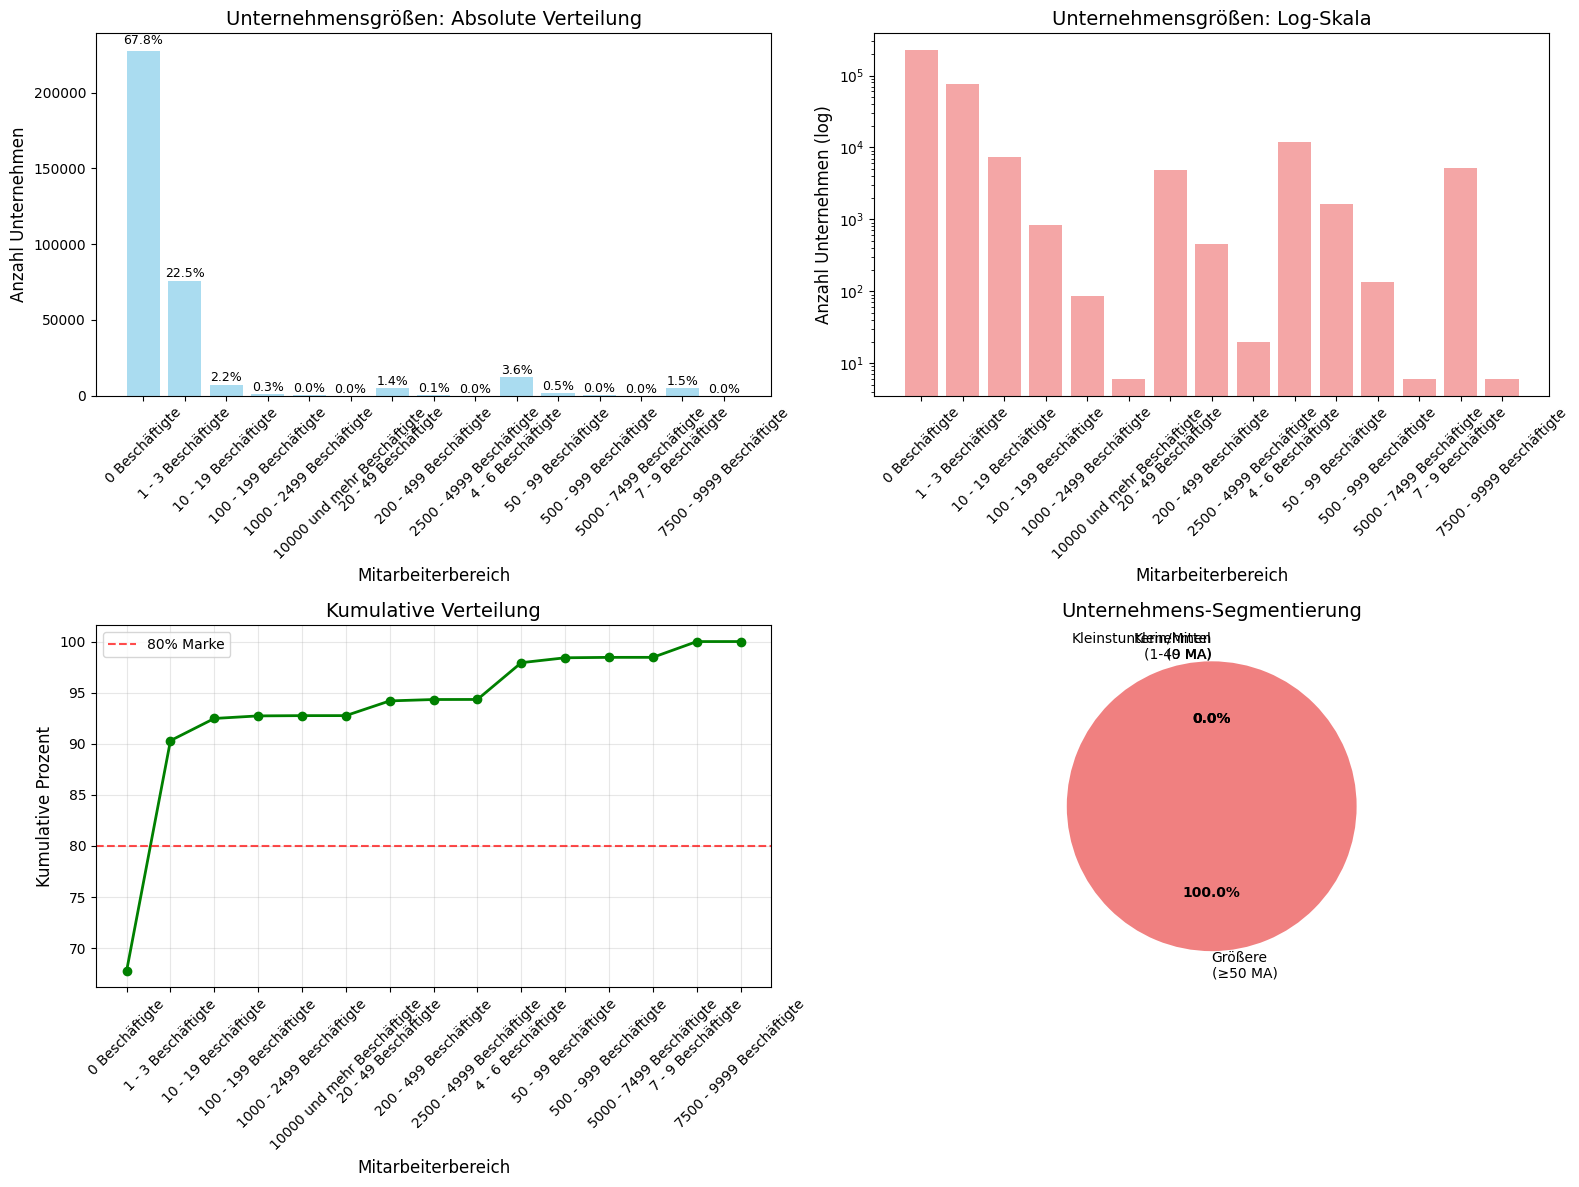


🎯 CLUSTERING-RELEVANZ:
⚠️  Extreme Unausgewogenheit: 0.0% haben 0 Mitarbeiter
📈 Empfehlung: Log-Transformation oder kategoriale Behandlung für employees_range
🎲 Stratifizierte Stichprobe notwendig für ausgewogene Cluster


In [13]:
# Erweiterte Visualisierung der Unternehmensgrößen
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Absolute Zahlen (normal)
ax1 = axes[0, 0]
bars1 = ax1.bar(employee_counts.index, employee_counts.values, color='skyblue', alpha=0.7)
ax1.set_title("Unternehmensgrößen: Absolute Verteilung")
ax1.set_xlabel("Mitarbeiterbereich")
ax1.set_ylabel("Anzahl Unternehmen")
ax1.tick_params(axis='x', rotation=45)

# Annotiere Balken mit Prozenten
for bar, count in zip(bars1, employee_counts.values):
    percentage = (count / total_companies) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + count*0.01,
             f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 2: Log-Skala für bessere Sichtbarkeit
ax2 = axes[0, 1]
bars2 = ax2.bar(employee_counts.index, employee_counts.values, color='lightcoral', alpha=0.7)
ax2.set_yscale('log')
ax2.set_title("Unternehmensgrößen: Log-Skala")
ax2.set_xlabel("Mitarbeiterbereich")
ax2.set_ylabel("Anzahl Unternehmen (log)")
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Kumulative Verteilung
ax3 = axes[1, 0]
cumulative_counts = employee_counts.cumsum()
cumulative_pct = (cumulative_counts / total_companies) * 100
ax3.plot(range(len(cumulative_pct)), cumulative_pct.values, 'o-', color='green', linewidth=2, markersize=6)
ax3.set_title("Kumulative Verteilung")
ax3.set_xlabel("Mitarbeiterbereich")
ax3.set_ylabel("Kumulative Prozent")
ax3.set_xticks(range(len(cumulative_pct)))
ax3.set_xticklabels(cumulative_pct.index, rotation=45)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% Marke')
ax3.legend()

# Plot 4: Pie Chart der Hauptkategorien
ax4 = axes[1, 1]
categories = ['Kleinstunternehmen\n(0 MA)', 'Klein/Mittel\n(1-49 MA)', 'Größere\n(≥50 MA)']
sizes = [kleinstunternehmen, small_medium, large_companies]
colors = ['lightblue', 'lightgreen', 'lightcoral']

wedges, texts, autotexts = ax4.pie(sizes, labels=categories, colors=colors, autopct='%1.1f%%', 
                                   startangle=90, textprops={'fontsize': 10})
ax4.set_title("Unternehmens-Segmentierung")

# Mache Prozentangaben fett
for autotext in autotexts:
    autotext.set_weight('bold')

plt.tight_layout()
plt.show()

# Clustering-Relevanz Assessment
print("\n🎯 CLUSTERING-RELEVANZ:")
print(f"⚠️  Extreme Unausgewogenheit: {(kleinstunternehmen/total_companies)*100:.1f}% haben 0 Mitarbeiter")
print(f"📈 Empfehlung: Log-Transformation oder kategoriale Behandlung für employees_range")
print(f"🎲 Stratifizierte Stichprobe notwendig für ausgewogene Cluster")

Extrem unausgewogene Verteilung

68 % aller Einträge haben „0 Beschäftigte“, nur wenige Tausend haben >50 Beschäftigte.
Die kleinen Gruppen sind massiv unterrepräsentiert → Clusterung wird dominiert von Kleinstunternehmen.

**Unternehmensalter (business_age)**

**Analyse-Fokus**: Temporal Muster und Gründungszyklen in Berlin

=== UNTERNEHMENSALTER STATISTIKEN ===
count    335962.000000
mean          9.388449
std           9.606040
min           0.000000
25%           2.000000
50%           7.000000
75%          14.000000
max         100.000000
Name: business_age, dtype: float64

=== ALTERSGRUPPEN-VERTEILUNG ===
Sehr jung (≤2 Jahre): 85,784 (25.5%)
Erfahren (11-20 Jahre): 81,540 (24.3%)
Etabliert (6-10 Jahre): 69,135 (20.6%)
Jung (3-5 Jahre): 63,264 (18.8%)
Veteran (>20 Jahre): 36,239 (10.8%)

=== GRÜNDUNGSZYKLEN ===
Gründungen pro Dekade:
1950-1959: 450 (0.1%)
1960-1969: 566 (0.2%)
1970-1979: 1,566 (0.5%)
1980-1989: 3,539 (1.1%)
1990-1999: 16,912 (5.0%)
2000-2009: 51,651 (15.4%)
2010-2019: 129,257 (38.5%)


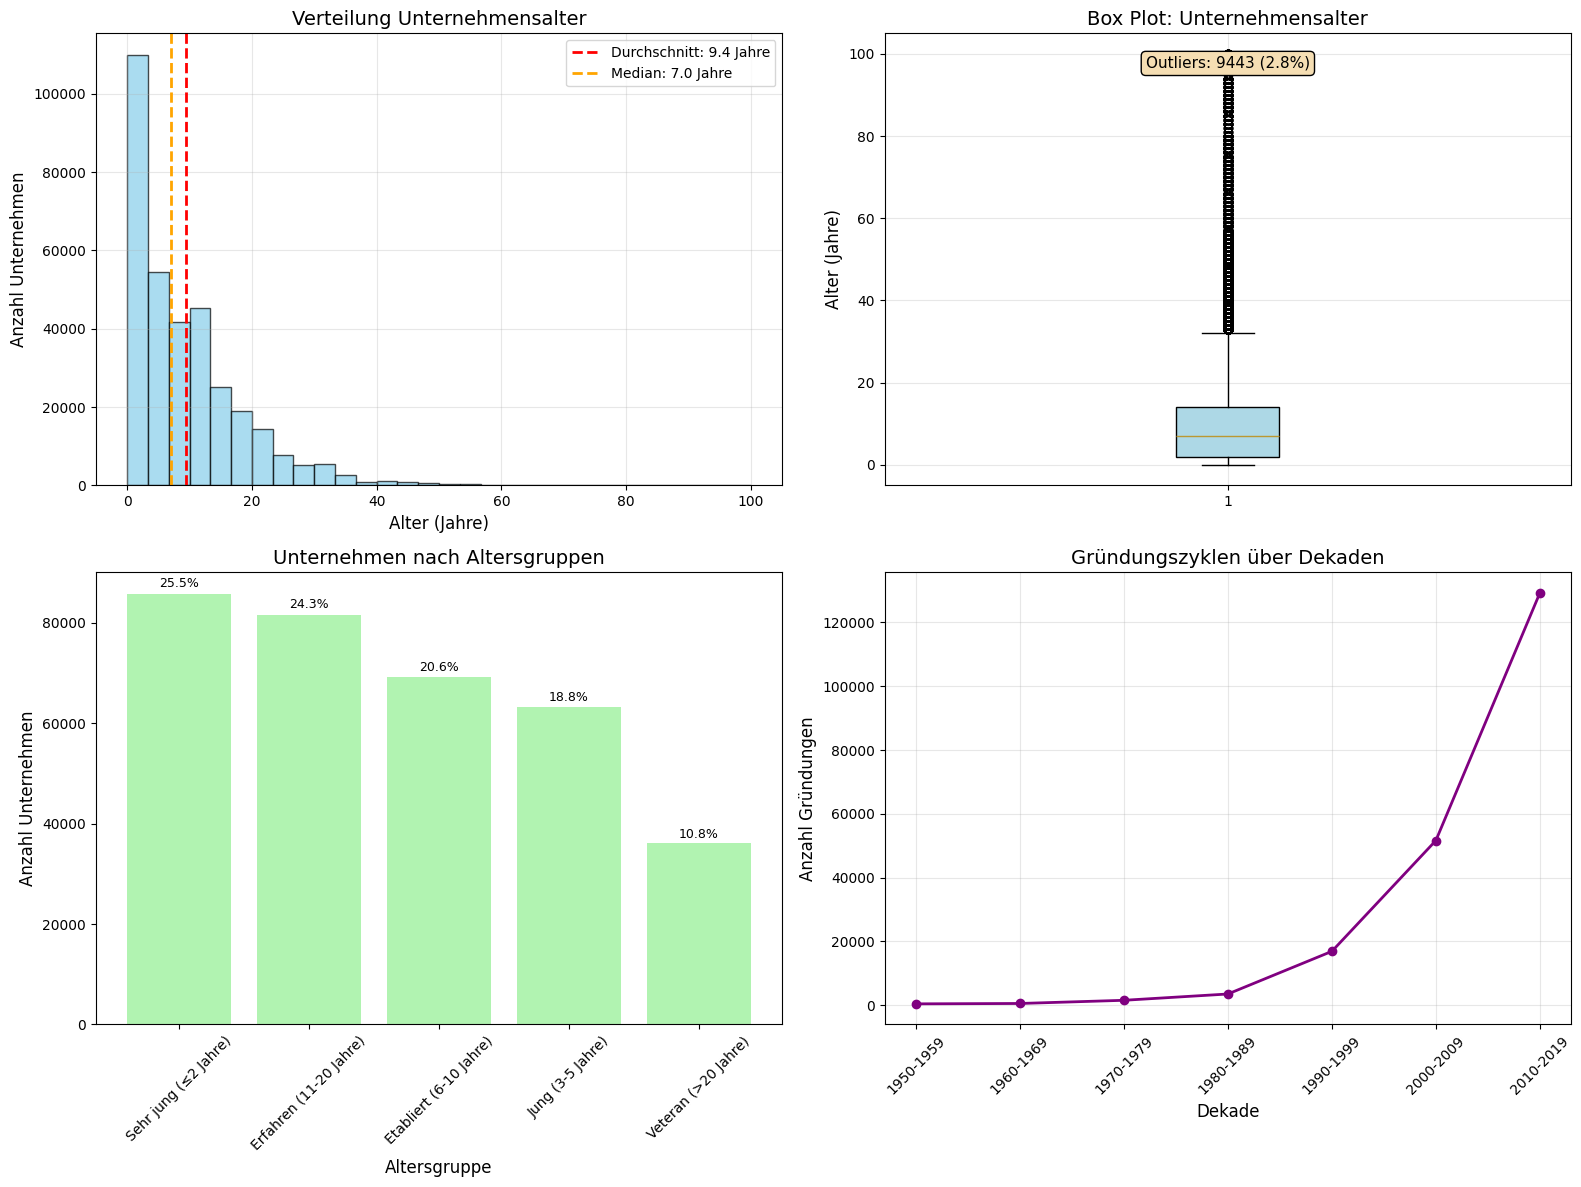


🎯 CLUSTERING-INSIGHTS:
📊 Rechtsschief verteilt: Viele junge Unternehmen, wenige sehr alte
🔢 Mittelwert: 9.4 Jahre, Median: 7.0 Jahre
⚡ Log-Transformation empfehlenswert für normalere Verteilung


In [14]:
# Detaillierte Unternehmensalter-Analyse
print("=== UNTERNEHMENSALTER STATISTIKEN ===")
age_stats = df['business_age'].describe()
print(age_stats)

# Definiere Alterskategorien
def categorize_age(age):
    if age <= 2:
        return 'Sehr jung (≤2 Jahre)'
    elif age <= 5:
        return 'Jung (3-5 Jahre)'
    elif age <= 10:
        return 'Etabliert (6-10 Jahre)'
    elif age <= 20:
        return 'Erfahren (11-20 Jahre)'
    else:
        return 'Veteran (>20 Jahre)'

df['age_category'] = df['business_age'].apply(categorize_age)
age_categories = df['age_category'].value_counts()

print(f"\n=== ALTERSGRUPPEN-VERTEILUNG ===")
for category, count in age_categories.items():
    percentage = (count / len(df)) * 100
    print(f"{category}: {count:,} ({percentage:.1f}%)")

# Zeitliche Trends (basierend auf gründungsjahr)
print(f"\n=== GRÜNDUNGSZYKLEN ===")
founding_decades = pd.cut(df['gründungsjahr'], 
                         bins=range(1950, 2030, 10), 
                         labels=[f"{i}-{i+9}" for i in range(1950, 2020, 10)],
                         include_lowest=True)

decade_counts = founding_decades.value_counts().sort_index()
print("Gründungen pro Dekade:")
for decade, count in decade_counts.items():
    if pd.notna(decade):
        percentage = (count / len(df)) * 100
        print(f"{decade}: {count:,} ({percentage:.1f}%)")

# Erweiterte Visualisierung
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Histogramm mit verbesserter Binning
ax1 = axes[0, 0]
n, bins, patches = ax1.hist(df['business_age'], bins=30, color='skyblue', alpha=0.7, edgecolor='black')
ax1.axvline(df['business_age'].mean(), color='red', linestyle='--', linewidth=2, label=f'Durchschnitt: {df["business_age"].mean():.1f} Jahre')
ax1.axvline(df['business_age'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df["business_age"].median():.1f} Jahre')
ax1.set_title("Verteilung Unternehmensalter")
ax1.set_xlabel("Alter (Jahre)")
ax1.set_ylabel("Anzahl Unternehmen")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Box Plot für Outlier-Erkennung
ax2 = axes[0, 1]
box_plot = ax2.boxplot(df['business_age'], patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
ax2.set_title("Box Plot: Unternehmensalter")
ax2.set_ylabel("Alter (Jahre)")
ax2.grid(True, alpha=0.3)

# Outlier-Statistiken
Q1 = df['business_age'].quantile(0.25)
Q3 = df['business_age'].quantile(0.75)
IQR = Q3 - Q1
outliers_low = (df['business_age'] < Q1 - 1.5 * IQR).sum()
outliers_high = (df['business_age'] > Q3 + 1.5 * IQR).sum()
ax2.text(0.5, 0.95, f'Outliers: {outliers_low + outliers_high} ({((outliers_low + outliers_high)/len(df)*100):.1f}%)', 
         transform=ax2.transAxes, ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# Plot 3: Altersgruppen
ax3 = axes[1, 0]
bars = ax3.bar(range(len(age_categories)), age_categories.values, color='lightgreen', alpha=0.7)
ax3.set_title("Unternehmen nach Altersgruppen")
ax3.set_xlabel("Altersgruppe")
ax3.set_ylabel("Anzahl Unternehmen")
ax3.set_xticks(range(len(age_categories)))
ax3.set_xticklabels(age_categories.index, rotation=45)

# Annotiere mit Prozenten
for i, (bar, count) in enumerate(zip(bars, age_categories.values)):
    percentage = (count / len(df)) * 100
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + count*0.01,
             f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 4: Gründungszyklen über Zeit
ax4 = axes[1, 1]
if len(decade_counts.dropna()) > 0:
    ax4.plot(range(len(decade_counts.dropna())), decade_counts.dropna().values, 'o-', 
             color='purple', linewidth=2, markersize=6)
    ax4.set_title("Gründungszyklen über Dekaden")
    ax4.set_xlabel("Dekade")
    ax4.set_ylabel("Anzahl Gründungen")
    ax4.set_xticks(range(len(decade_counts.dropna())))
    ax4.set_xticklabels(decade_counts.dropna().index, rotation=45)
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 CLUSTERING-INSIGHTS:")
print(f"📊 Rechtsschief verteilt: Viele junge Unternehmen, wenige sehr alte")
print(f"🔢 Mittelwert: {df['business_age'].mean():.1f} Jahre, Median: {df['business_age'].median():.1f} Jahre")
print(f"⚡ Log-Transformation empfehlenswert für normalere Verteilung")

In [15]:
print(f"Unternehmen mit < 6 Jahren: {(df['business_age'] < 6).sum()}")
print(f"Unternehmen mit > 6 Jahren: {(df['business_age'] > 6).sum()}")

Unternehmen mit < 6 Jahren: 149048
Unternehmen mit > 6 Jahren: 171555


**Geografische Verteilung (Bezirke)**

**Analyse-Fokus**: Räumliche Muster der Unternehmensansiedlung in Berlin

=== UNTERNEHMEN NACH BEZIRKEN ===
Anzahl Bezirke: 12
Gesamtunternehmen: 335,962

Top 5 Bezirke:
1. Mitte: 53,078 (15.8%)
2. Charlottenburg-Wilmersdorf: 51,288 (15.3%)
3. Pankow: 36,283 (10.8%)
4. Tempelhof-Schöneberg: 33,760 (10.0%)
5. Friedrichshain-Kreuzberg: 33,537 (10.0%)

Bottom 5 Bezirke:
Reinickendorf: 18,381 (5.5%)
Treptow-Köpenick: 17,836 (5.3%)
Lichtenberg: 15,114 (4.5%)
Spandau: 14,138 (4.2%)
Marzahn-Hellersdorf: 12,476 (3.7%)

=== VERTEILUNGSANALYSE ===
Top 3 Bezirke: 41.9% aller Unternehmen
Top 5 Bezirke: 61.9% aller Unternehmen
Gini-Koeffizient: 0.262 (0=perfekte Gleichverteilung, 1=maximale Ungleichheit)


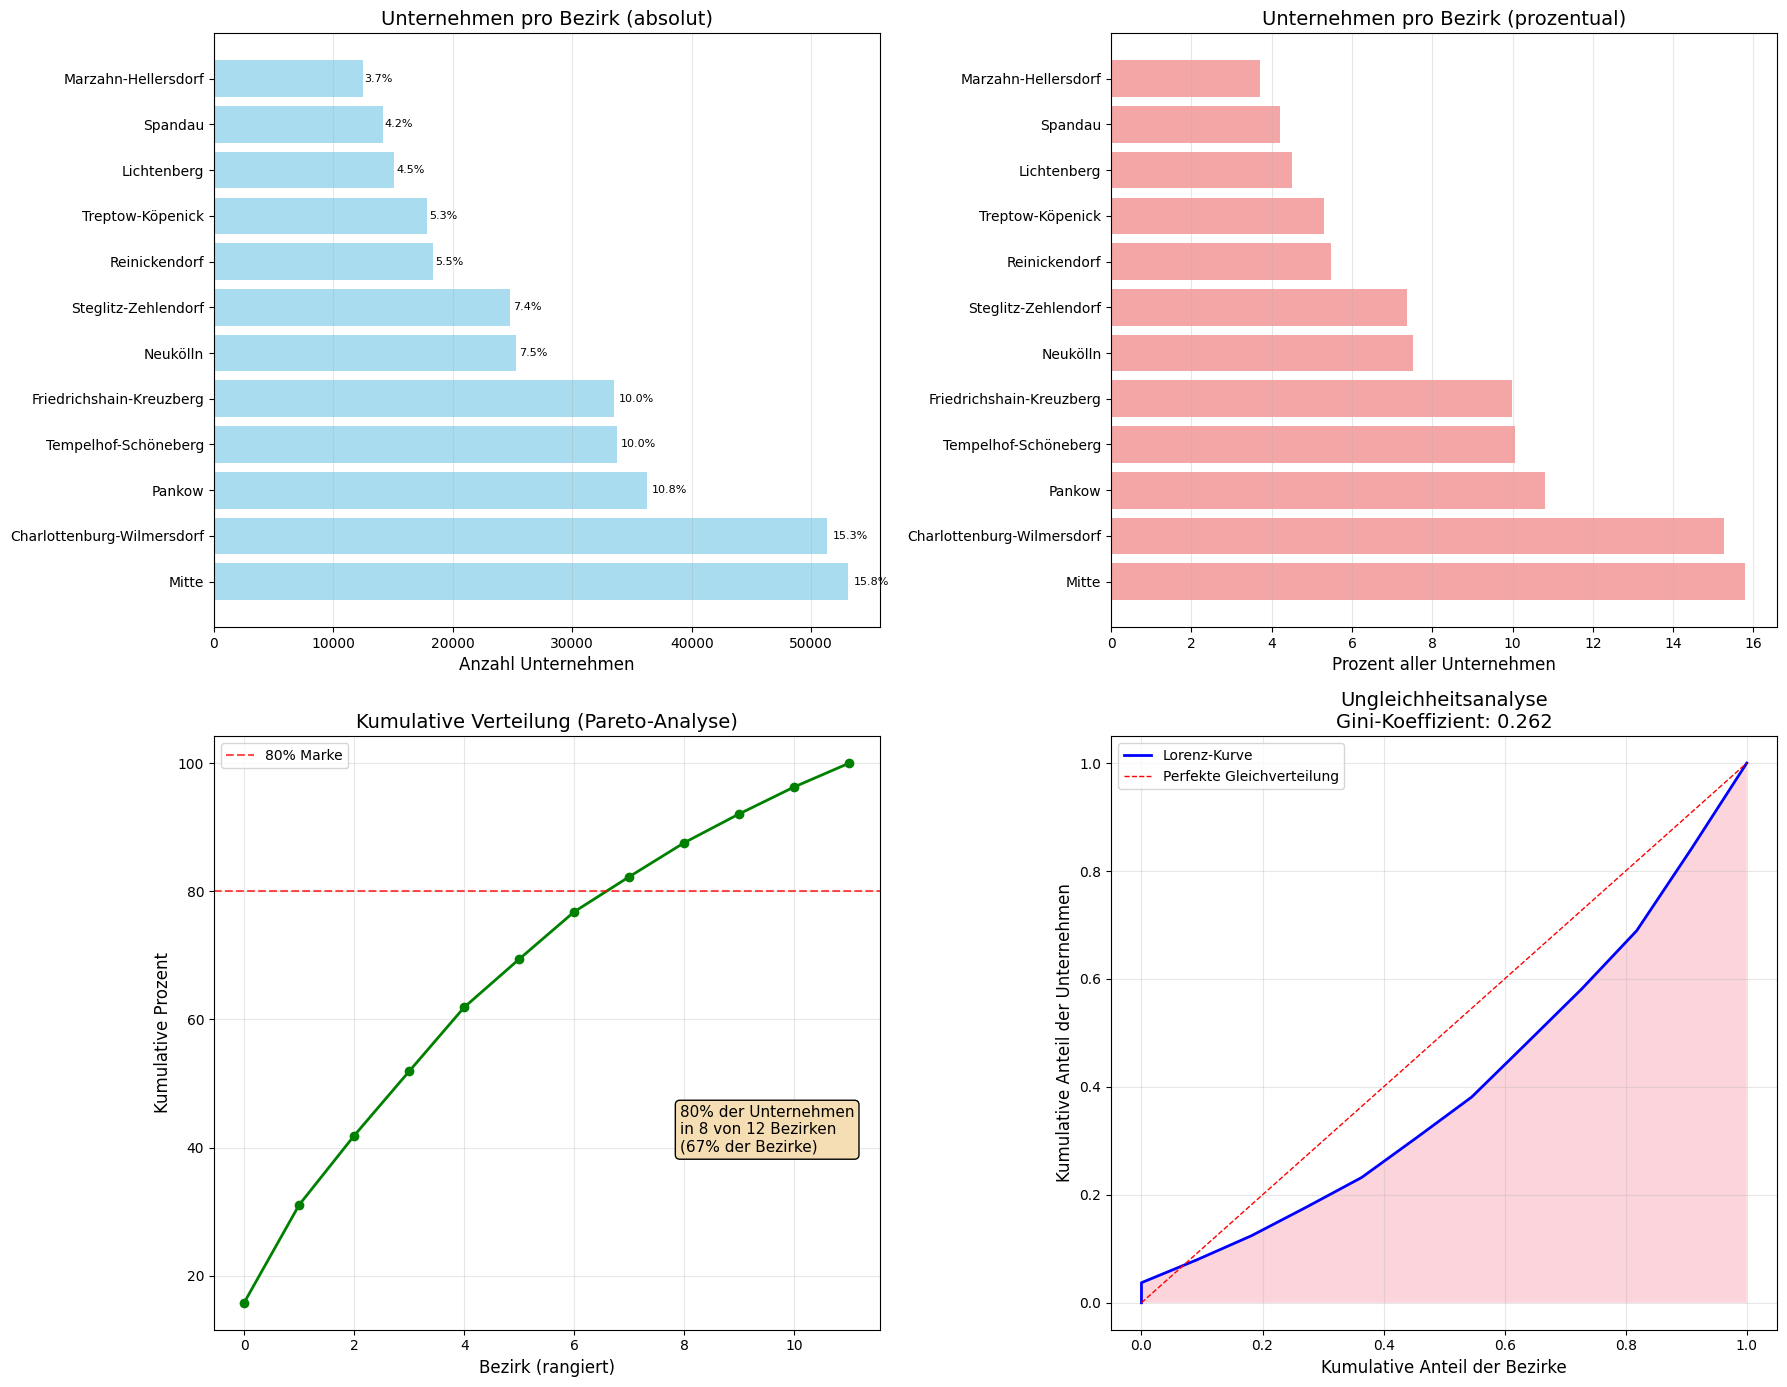


🎯 GEOGRAFISCHE CLUSTERING-INSIGHTS:
🏙️  Starke räumliche Konzentration: Top 3 Bezirke haben 41.9% aller Unternehmen
⚖️  Ungleichheit (Gini): 0.262 - niedrig
📍 Empfehlung: Bezirk als wichtiges kategoriales Feature für Clustering
🎯 One-Hot-Encoding für Bezirk wird Cluster stark beeinflussen


In [16]:
# Detaillierte Bezirks-Analyse
bezirk_stats = df['Bezirk'].value_counts().sort_values(ascending=False)
total_companies = len(df)

print("=== UNTERNEHMEN NACH BEZIRKEN ===")
print(f"Anzahl Bezirke: {df['Bezirk'].nunique()}")
print(f"Gesamtunternehmen: {total_companies:,}")

print(f"\nTop 5 Bezirke:")
for i, (bezirk, count) in enumerate(bezirk_stats.head().items()):
    percentage = (count / total_companies) * 100
    print(f"{i+1}. {bezirk}: {count:,} ({percentage:.1f}%)")

print(f"\nBottom 5 Bezirke:")
for i, (bezirk, count) in enumerate(bezirk_stats.tail().items()):
    percentage = (count / total_companies) * 100
    print(f"{bezirk}: {count:,} ({percentage:.1f}%)")

# Ungleichheit-Analyse
print(f"\n=== VERTEILUNGSANALYSE ===")
top_3_share = bezirk_stats.head(3).sum() / total_companies * 100
top_5_share = bezirk_stats.head(5).sum() / total_companies * 100
print(f"Top 3 Bezirke: {top_3_share:.1f}% aller Unternehmen")
print(f"Top 5 Bezirke: {top_5_share:.1f}% aller Unternehmen")

# Gini-Koeffizient für Ungleichheit
sorted_counts = np.sort(bezirk_stats.values)
n = len(sorted_counts)
index = np.arange(1, n + 1)
gini = (2 * np.sum(index * sorted_counts)) / (n * np.sum(sorted_counts)) - (n + 1) / n
print(f"Gini-Koeffizient: {gini:.3f} (0=perfekte Gleichverteilung, 1=maximale Ungleichheit)")

# Erweiterte Visualisierung
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Horizontales Balkendiagramm (bessere Lesbarkeit)
ax1 = axes[0, 0]
y_pos = np.arange(len(bezirk_stats))
bars = ax1.barh(y_pos, bezirk_stats.values, color='skyblue', alpha=0.7)
ax1.set_title("Unternehmen pro Bezirk (absolut)")
ax1.set_xlabel("Anzahl Unternehmen")
ax1.set_yticks(y_pos)
ax1.set_yticklabels(bezirk_stats.index)
ax1.grid(True, alpha=0.3, axis='x')

# Annotiere mit Prozentwerten
for i, (bar, count) in enumerate(zip(bars, bezirk_stats.values)):
    percentage = (count / total_companies) * 100
    ax1.text(bar.get_width() + count*0.01, bar.get_y() + bar.get_height()/2,
             f'{percentage:.1f}%', ha='left', va='center', fontsize=8)

# Plot 2: Prozentuale Verteilung
ax2 = axes[0, 1]
percentages = (bezirk_stats.values / total_companies) * 100
bars2 = ax2.barh(y_pos, percentages, color='lightcoral', alpha=0.7)
ax2.set_title("Unternehmen pro Bezirk (prozentual)")
ax2.set_xlabel("Prozent aller Unternehmen")
ax2.set_yticks(y_pos)
ax2.set_yticklabels(bezirk_stats.index)
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Kumulative Verteilung (Pareto-Analyse)
ax3 = axes[1, 0]
cumulative_pct = (bezirk_stats.cumsum() / total_companies) * 100
ax3.plot(range(len(cumulative_pct)), cumulative_pct.values, 'o-', color='green', linewidth=2, markersize=6)
ax3.set_title("Kumulative Verteilung (Pareto-Analyse)")
ax3.set_xlabel("Bezirk (rangiert)")
ax3.set_ylabel("Kumulative Prozent")
ax3.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% Marke')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Pareto-Regel prüfen
for i, pct in enumerate(cumulative_pct.values):
    if pct >= 80:
        pareto_point = i + 1
        break
pareto_percentage = (pareto_point / len(bezirk_stats)) * 100
ax3.text(0.7, 0.3, f'80% der Unternehmen\nin {pareto_point} von {len(bezirk_stats)} Bezirken\n({pareto_percentage:.0f}% der Bezirke)', 
         transform=ax3.transAxes, bbox=dict(boxstyle='round', facecolor='wheat'))

# Plot 4: Ungleichheits-Visualisierung (Lorenz-Kurve)
ax4 = axes[1, 1]
# Sortiere für Lorenz-Kurve (aufsteigend)
sorted_for_lorenz = np.sort(bezirk_stats.values)
cumsum = np.cumsum(sorted_for_lorenz)
cumsum_norm = cumsum / cumsum[-1]
x_lorenz = np.linspace(0, 1, len(cumsum_norm))

ax4.plot([0] + x_lorenz.tolist(), [0] + cumsum_norm.tolist(), 'b-', linewidth=2, label='Lorenz-Kurve')
ax4.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Perfekte Gleichverteilung')
ax4.fill_between([0] + x_lorenz.tolist(), [0] + cumsum_norm.tolist(), alpha=0.3)
ax4.set_title(f"Ungleichheitsanalyse\nGini-Koeffizient: {gini:.3f}")
ax4.set_xlabel("Kumulative Anteil der Bezirke")
ax4.set_ylabel("Kumulative Anteil der Unternehmen")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Geografische Clustering-Relevanz
print(f"\n🎯 GEOGRAFISCHE CLUSTERING-INSIGHTS:")
print(f"🏙️  Starke räumliche Konzentration: Top 3 Bezirke haben {top_3_share:.1f}% aller Unternehmen")
print(f"⚖️  Ungleichheit (Gini): {gini:.3f} - {'hoch' if gini > 0.5 else 'moderat' if gini > 0.3 else 'niedrig'}")
print(f"📍 Empfehlung: Bezirk als wichtiges kategoriales Feature für Clustering")
print(f"🎯 One-Hot-Encoding für Bezirk wird Cluster stark beeinflussen")

**Bodenrichtwert - Immobilienwerte**

**Analyse-Fokus**: Wirtschaftliche Standortqualität und Immobilienmarkt-Dynamiken

=== BODENRICHTWERT STATISTIKEN ===
count    335962.000000
mean       3065.362017
std        3408.441098
min           0.600000
25%         700.000000
50%        2100.000000
75%        4500.000000
max       60000.000000
Name: Bodenrichtwert, dtype: float64

=== EXTREME WERTE ===
Minimum: 1 €/m²
Maximum: 60,000 €/m²
Spannweite: 59,999 €/m²
Standardabweichung: 3,408 €/m²
Variationskoeffizient: 1.11
count    335962.000000
mean       3065.362017
std        3408.441098
min           0.600000
25%         700.000000
50%        2100.000000
75%        4500.000000
max       60000.000000
Name: Bodenrichtwert, dtype: float64

=== EXTREME WERTE ===
Minimum: 1 €/m²
Maximum: 60,000 €/m²
Spannweite: 59,999 €/m²
Standardabweichung: 3,408 €/m²
Variationskoeffizient: 1.11

=== PREISSEGMENTE ===
Premium (>1000 €/m²): 223,679 (66.6%)
Hoch (301-600 €/m²): 58,217 (17.3%)
Sehr hoch (601-1000 €/m²): 43,090 (12.8%)
Mittel (101-300 €/m²): 8,464 (2.5%)
Niedrig (≤100 €/m²): 2,512 (0.7%)

=== OUTLIER-ANALYSE (IQR-Me

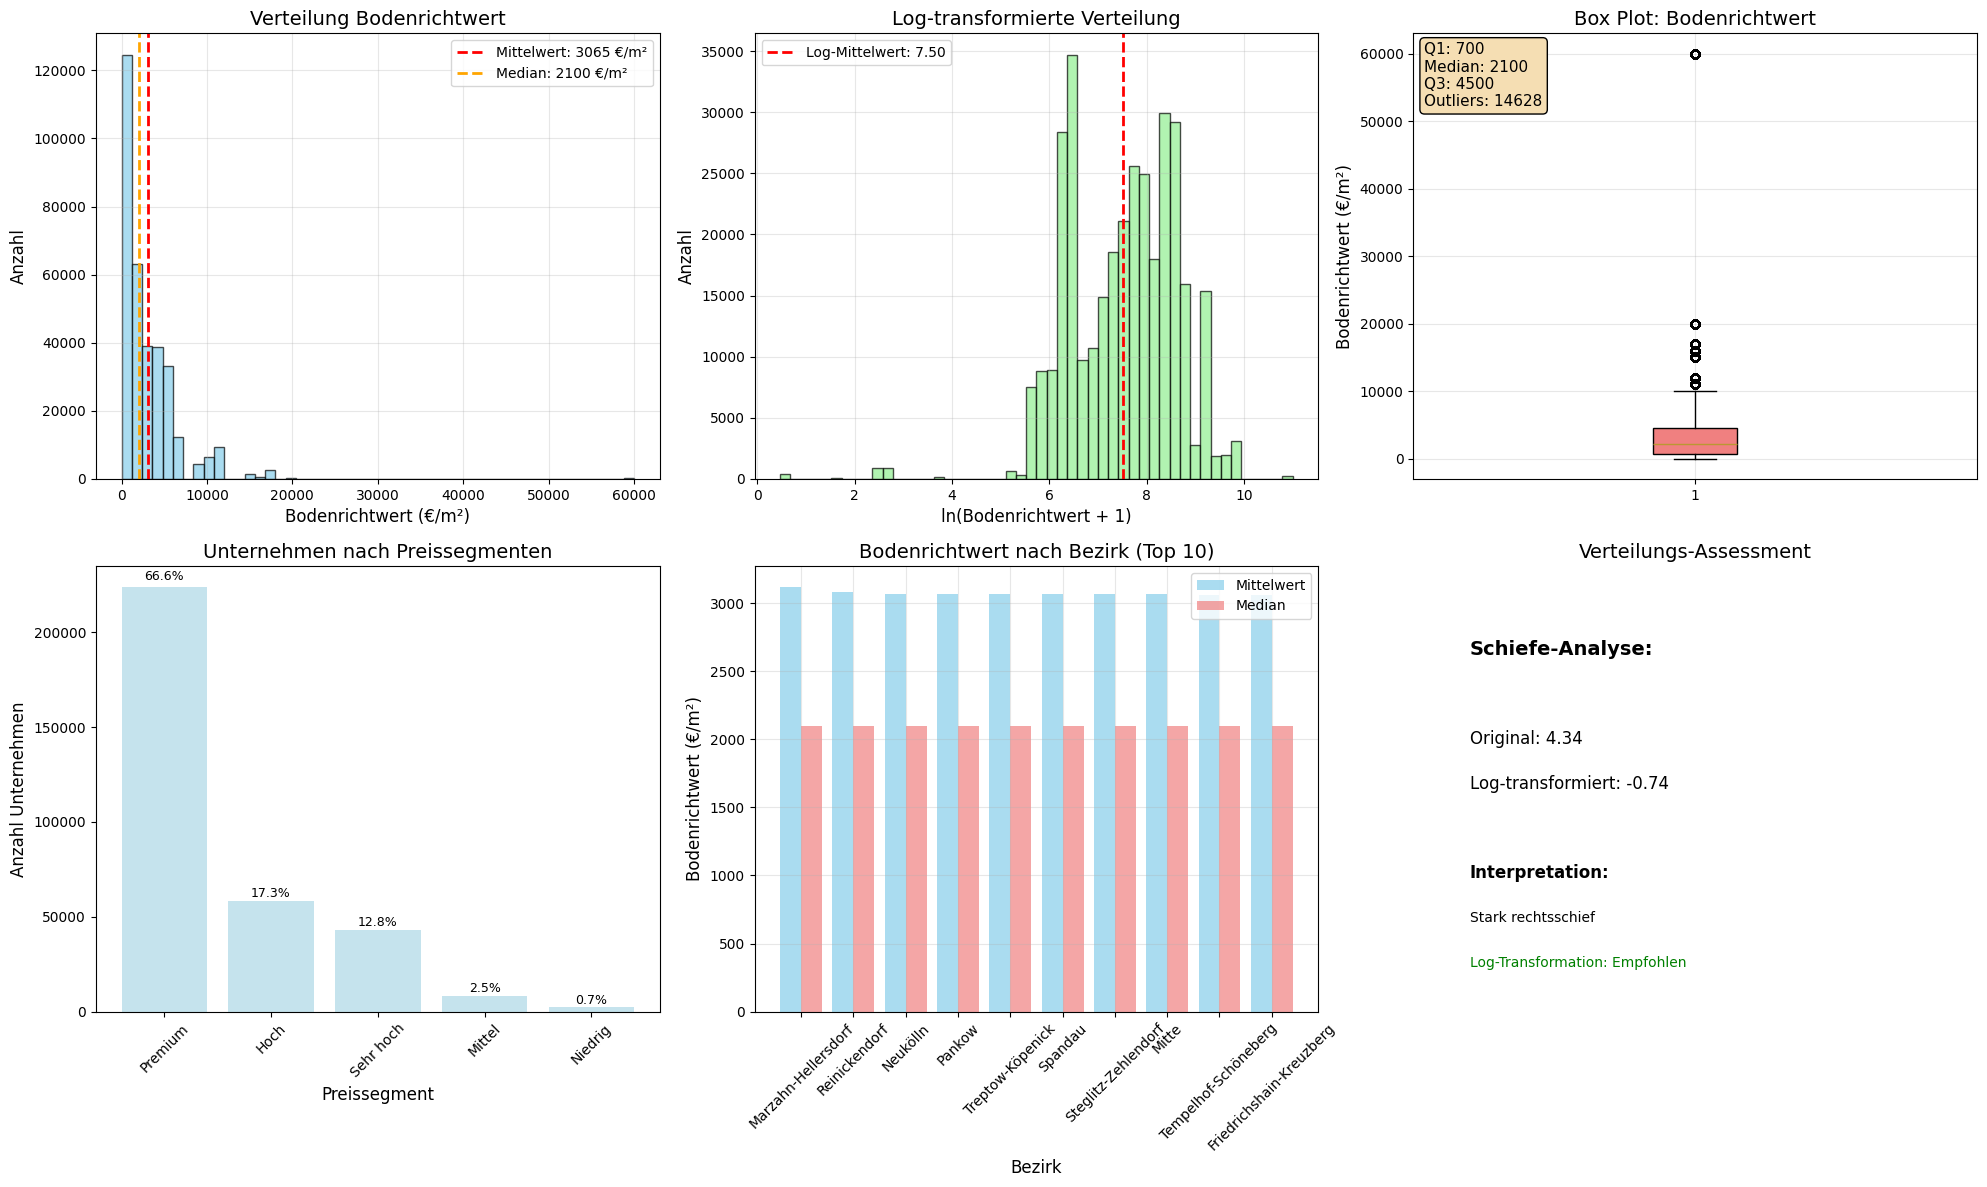


🎯 CLUSTERING-INSIGHTS:
📊 Stark rechtsschief (Skewness: 4.34) - Log-Transformation empfohlen
🏢 Große Spannweite (1 - 60000 €/m²) - Standardisierung wichtig
🎯 14628 Outliers (4.4%) - Robuste Behandlung nötig
🗺️  Starke Bezirks-Unterschiede - Geografischer Faktor sehr relevant


In [17]:
# Detaillierte Bodenrichtwert-Analyse
print("=== BODENRICHTWERT STATISTIKEN ===")
brw_stats = df['Bodenrichtwert'].describe()
print(brw_stats)

# Extreme Werte analysieren
print(f"\n=== EXTREME WERTE ===")
print(f"Minimum: {df['Bodenrichtwert'].min():,.0f} €/m²")
print(f"Maximum: {df['Bodenrichtwert'].max():,.0f} €/m²")
print(f"Spannweite: {df['Bodenrichtwert'].max() - df['Bodenrichtwert'].min():,.0f} €/m²")
print(f"Standardabweichung: {df['Bodenrichtwert'].std():,.0f} €/m²")
print(f"Variationskoeffizient: {(df['Bodenrichtwert'].std() / df['Bodenrichtwert'].mean()):.2f}")

# Kategorisierung nach Preissegmenten
def categorize_brw(brw):
    if brw <= 100:
        return 'Niedrig (≤100 €/m²)'
    elif brw <= 300:
        return 'Mittel (101-300 €/m²)'
    elif brw <= 600:
        return 'Hoch (301-600 €/m²)'
    elif brw <= 1000:
        return 'Sehr hoch (601-1000 €/m²)'
    else:
        return 'Premium (>1000 €/m²)'

df['brw_category'] = df['Bodenrichtwert'].apply(categorize_brw)
brw_categories = df['brw_category'].value_counts()

print(f"\n=== PREISSEGMENTE ===")
for category, count in brw_categories.items():
    percentage = (count / len(df)) * 100
    print(f"{category}: {count:,} ({percentage:.1f}%)")

# Outlier-Analyse mit IQR
Q1 = df['Bodenrichtwert'].quantile(0.25)
Q3 = df['Bodenrichtwert'].quantile(0.75)
IQR = Q3 - Q1
outliers_low = (df['Bodenrichtwert'] < Q1 - 1.5 * IQR).sum()
outliers_high = (df['Bodenrichtwert'] > Q3 + 1.5 * IQR).sum()

print(f"\n=== OUTLIER-ANALYSE (IQR-Methode) ===")
print(f"Q1 (25%): {Q1:.0f} €/m²")
print(f"Q3 (75%): {Q3:.0f} €/m²")
print(f"IQR: {IQR:.0f} €/m²")
print(f"Untere Grenze: {Q1 - 1.5 * IQR:.0f} €/m²")
print(f"Obere Grenze: {Q3 + 1.5 * IQR:.0f} €/m²")
print(f"Outliers unten: {outliers_low} ({(outliers_low/len(df)*100):.1f}%)")
print(f"Outliers oben: {outliers_high} ({(outliers_high/len(df)*100):.1f}%)")

# Erweiterte Visualisierung
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Histogramm mit verschiedenen Binning-Strategien
ax1 = axes[0, 0]
n, bins, patches = ax1.hist(df['Bodenrichtwert'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
ax1.axvline(df['Bodenrichtwert'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mittelwert: {df["Bodenrichtwert"].mean():.0f} €/m²')
ax1.axvline(df['Bodenrichtwert'].median(), color='orange', linestyle='--', linewidth=2, 
           label=f'Median: {df["Bodenrichtwert"].median():.0f} €/m²')
ax1.set_title("Verteilung Bodenrichtwert")
ax1.set_xlabel("Bodenrichtwert (€/m²)")
ax1.set_ylabel("Anzahl")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Log-transformierte Verteilung
ax2 = axes[0, 1]
log_brw = np.log1p(df['Bodenrichtwert'])  # log(1+x) für 0-Werte
ax2.hist(log_brw, bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
ax2.axvline(log_brw.mean(), color='red', linestyle='--', linewidth=2, label=f'Log-Mittelwert: {log_brw.mean():.2f}')
ax2.set_title("Log-transformierte Verteilung")
ax2.set_xlabel("ln(Bodenrichtwert + 1)")
ax2.set_ylabel("Anzahl")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Box Plot mit Outlier-Kennzeichnung
ax3 = axes[0, 2]
box_plot = ax3.boxplot(df['Bodenrichtwert'], patch_artist=True, showfliers=True)
box_plot['boxes'][0].set_facecolor('lightcoral')
ax3.set_title("Box Plot: Bodenrichtwert")
ax3.set_ylabel("Bodenrichtwert (€/m²)")
ax3.grid(True, alpha=0.3)

# Statistiken im Plot
stats_text = f'Q1: {Q1:.0f}\nMedian: {df["Bodenrichtwert"].median():.0f}\nQ3: {Q3:.0f}\nOutliers: {outliers_high + outliers_low}'
ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes, va='top', 
         bbox=dict(boxstyle='round', facecolor='wheat'))

# Plot 4: Preissegmente
ax4 = axes[1, 0]
bars = ax4.bar(range(len(brw_categories)), brw_categories.values, color='lightblue', alpha=0.7)
ax4.set_title("Unternehmen nach Preissegmenten")
ax4.set_xlabel("Preissegment")
ax4.set_ylabel("Anzahl Unternehmen")
ax4.set_xticks(range(len(brw_categories)))
ax4.set_xticklabels([cat.split('(')[0].strip() for cat in brw_categories.index], rotation=45)

# Annotiere mit Prozenten
for i, (bar, count) in enumerate(zip(bars, brw_categories.values)):
    percentage = (count / len(df)) * 100
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + count*0.01,
             f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 5: Bodenrichtwert nach Bezirk (Top 10)
ax5 = axes[1, 1]
brw_by_bezirk = df.groupby('Bezirk')['Bodenrichtwert'].agg(['mean', 'median', 'std']).sort_values('mean', ascending=False).head(10)
x_pos = np.arange(len(brw_by_bezirk))

bars_mean = ax5.bar(x_pos - 0.2, brw_by_bezirk['mean'], 0.4, label='Mittelwert', color='skyblue', alpha=0.7)
bars_median = ax5.bar(x_pos + 0.2, brw_by_bezirk['median'], 0.4, label='Median', color='lightcoral', alpha=0.7)

ax5.set_title("Bodenrichtwert nach Bezirk (Top 10)")
ax5.set_xlabel("Bezirk")
ax5.set_ylabel("Bodenrichtwert (€/m²)")
ax5.set_xticks(x_pos)
ax5.set_xticklabels(brw_by_bezirk.index, rotation=45)
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Verteilungsvergleich (Normal vs. Log)
ax6 = axes[1, 2]
# Q-Q Plot würde hier ideal sein, aber vereinfacht mit Skewness
from scipy import stats
skewness_original = stats.skew(df['Bodenrichtwert'])
skewness_log = stats.skew(log_brw)

ax6.text(0.1, 0.8, "Schiefe-Analyse:", fontsize=14, weight='bold', transform=ax6.transAxes)
ax6.text(0.1, 0.6, f"Original: {skewness_original:.2f}", fontsize=12, transform=ax6.transAxes)
ax6.text(0.1, 0.5, f"Log-transformiert: {skewness_log:.2f}", fontsize=12, transform=ax6.transAxes)
ax6.text(0.1, 0.3, "Interpretation:", fontsize=12, weight='bold', transform=ax6.transAxes)
ax6.text(0.1, 0.2, f"{'Stark rechtsschief' if abs(skewness_original) > 1 else 'Moderat schief' if abs(skewness_original) > 0.5 else 'Nahezu normal'}", 
         fontsize=10, transform=ax6.transAxes)
ax6.text(0.1, 0.1, f"Log-Transformation: {'Empfohlen' if abs(skewness_log) < abs(skewness_original) else 'Nicht nötig'}", 
         fontsize=10, color='green' if abs(skewness_log) < abs(skewness_original) else 'red', 
         transform=ax6.transAxes)
ax6.set_title("Verteilungs-Assessment")
ax6.axis('off')

plt.tight_layout()
plt.show()

print(f"\n🎯 CLUSTERING-INSIGHTS:")
print(f"📊 Stark rechtsschief (Skewness: {skewness_original:.2f}) - Log-Transformation empfohlen")
print(f"🏢 Große Spannweite ({df['Bodenrichtwert'].min():.0f} - {df['Bodenrichtwert'].max():.0f} €/m²) - Standardisierung wichtig")
print(f"🎯 {outliers_high + outliers_low} Outliers ({((outliers_high + outliers_low)/len(df)*100):.1f}%) - Robuste Behandlung nötig")
print(f"🗺️  Starke Bezirks-Unterschiede - Geografischer Faktor sehr relevant")

In [18]:
df["Bodenrichtwert"].describe()

count    335962.000000
mean       3065.362017
std        3408.441098
min           0.600000
25%         700.000000
50%        2100.000000
75%        4500.000000
max       60000.000000
Name: Bodenrichtwert, dtype: float64

**ew2023**

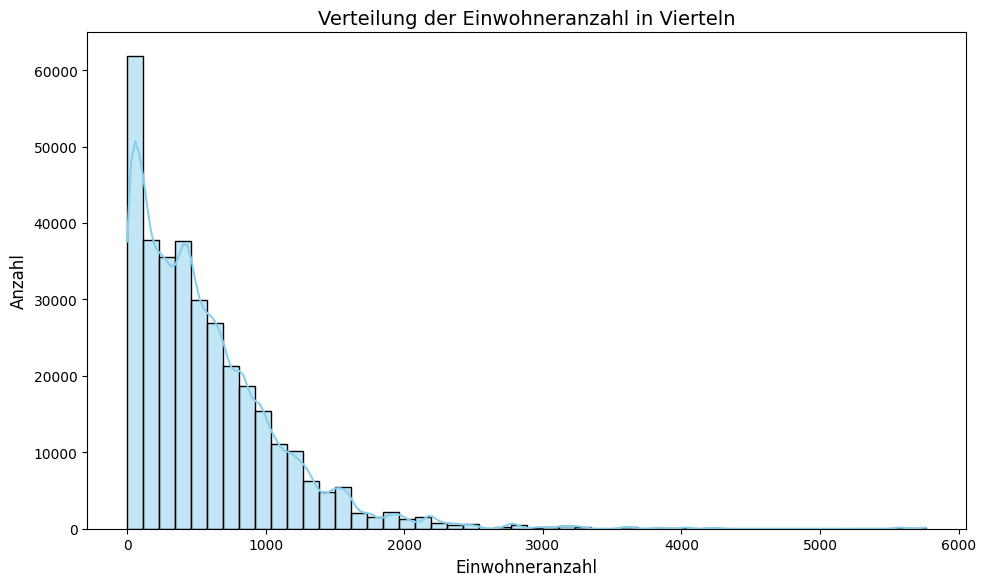

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ew2023'], bins=50, kde=True, color='skyblue')
plt.title("Verteilung der Einwohneranzahl in Vierteln")
plt.xlabel("Einwohneranzahl")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

In [20]:
df["ew2023"].describe()

count    335962.000000
mean        571.440267
std         534.135056
min           0.000000
25%         177.000000
50%         446.000000
75%         814.000000
max        5766.000000
Name: ew2023, dtype: float64

**ew_ha_2023**

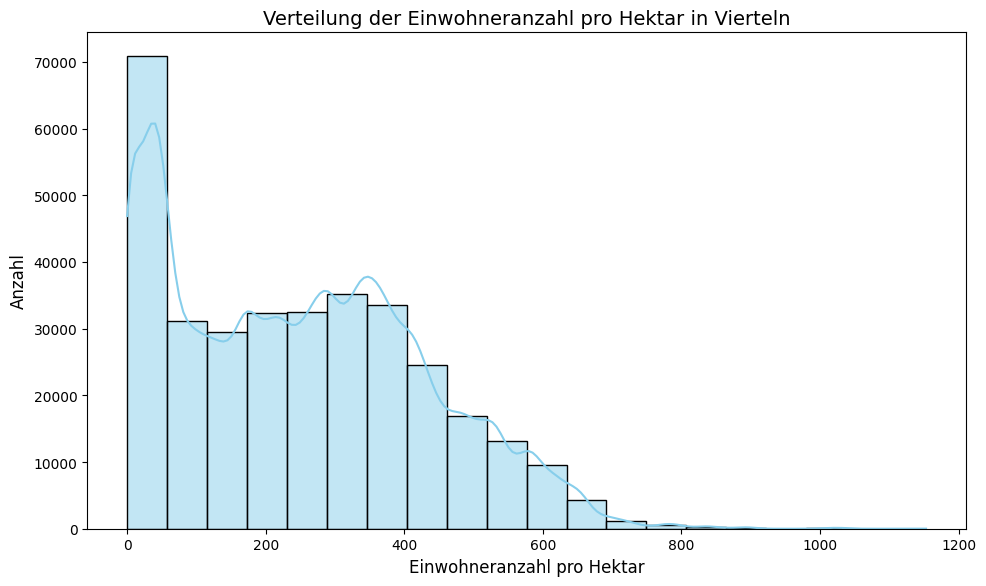

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ew_ha_2023'], bins=20, kde=True, color='skyblue')
plt.title("Verteilung der Einwohneranzahl pro Hektar in Vierteln")
plt.xlabel("Einwohneranzahl pro Hektar")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

In [22]:
df["ew_ha_2023"].describe()

count    335962.000000
mean        249.143146
std         181.164609
min           0.000000
25%          80.150000
50%         238.900000
75%         378.200000
max        1153.060000
Name: ew_ha_2023, dtype: float64

**typklar**

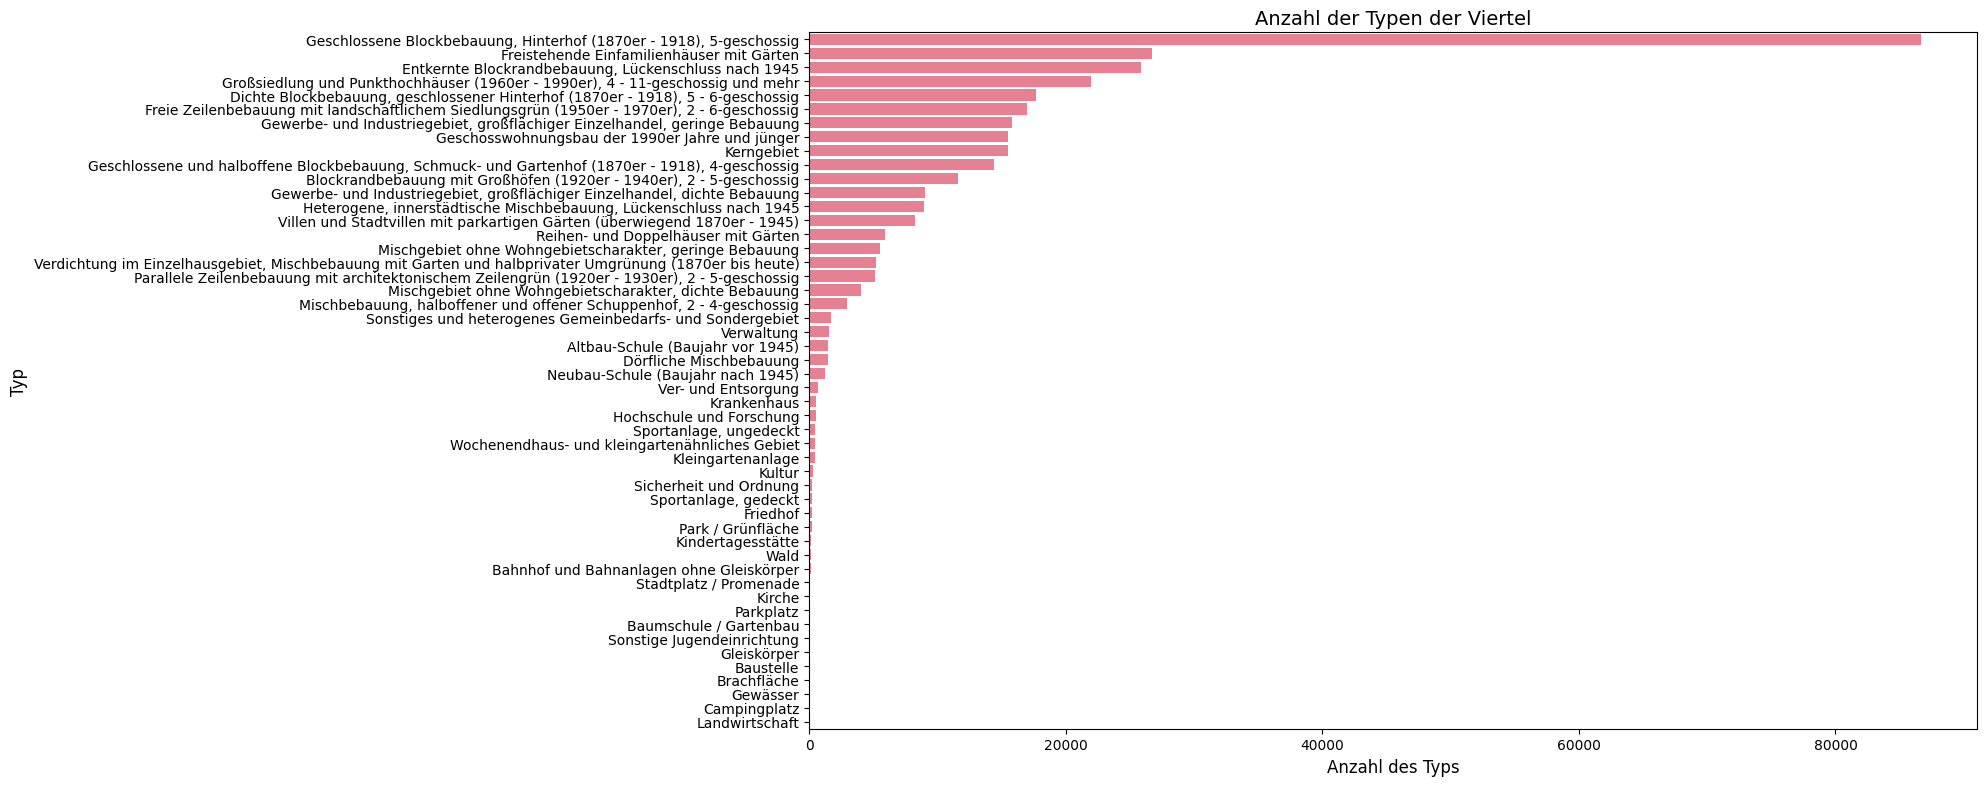

In [23]:
plt.figure(figsize=(20, 8))
sns.barplot(y=df["typklar"].value_counts().index, x=df["typklar"].value_counts().values)
plt.title("Anzahl der Typen der Viertel")
plt.ylabel("Typ")
plt.xlabel("Anzahl des Typs")
plt.tight_layout()
plt.show()

**Branche_grob**

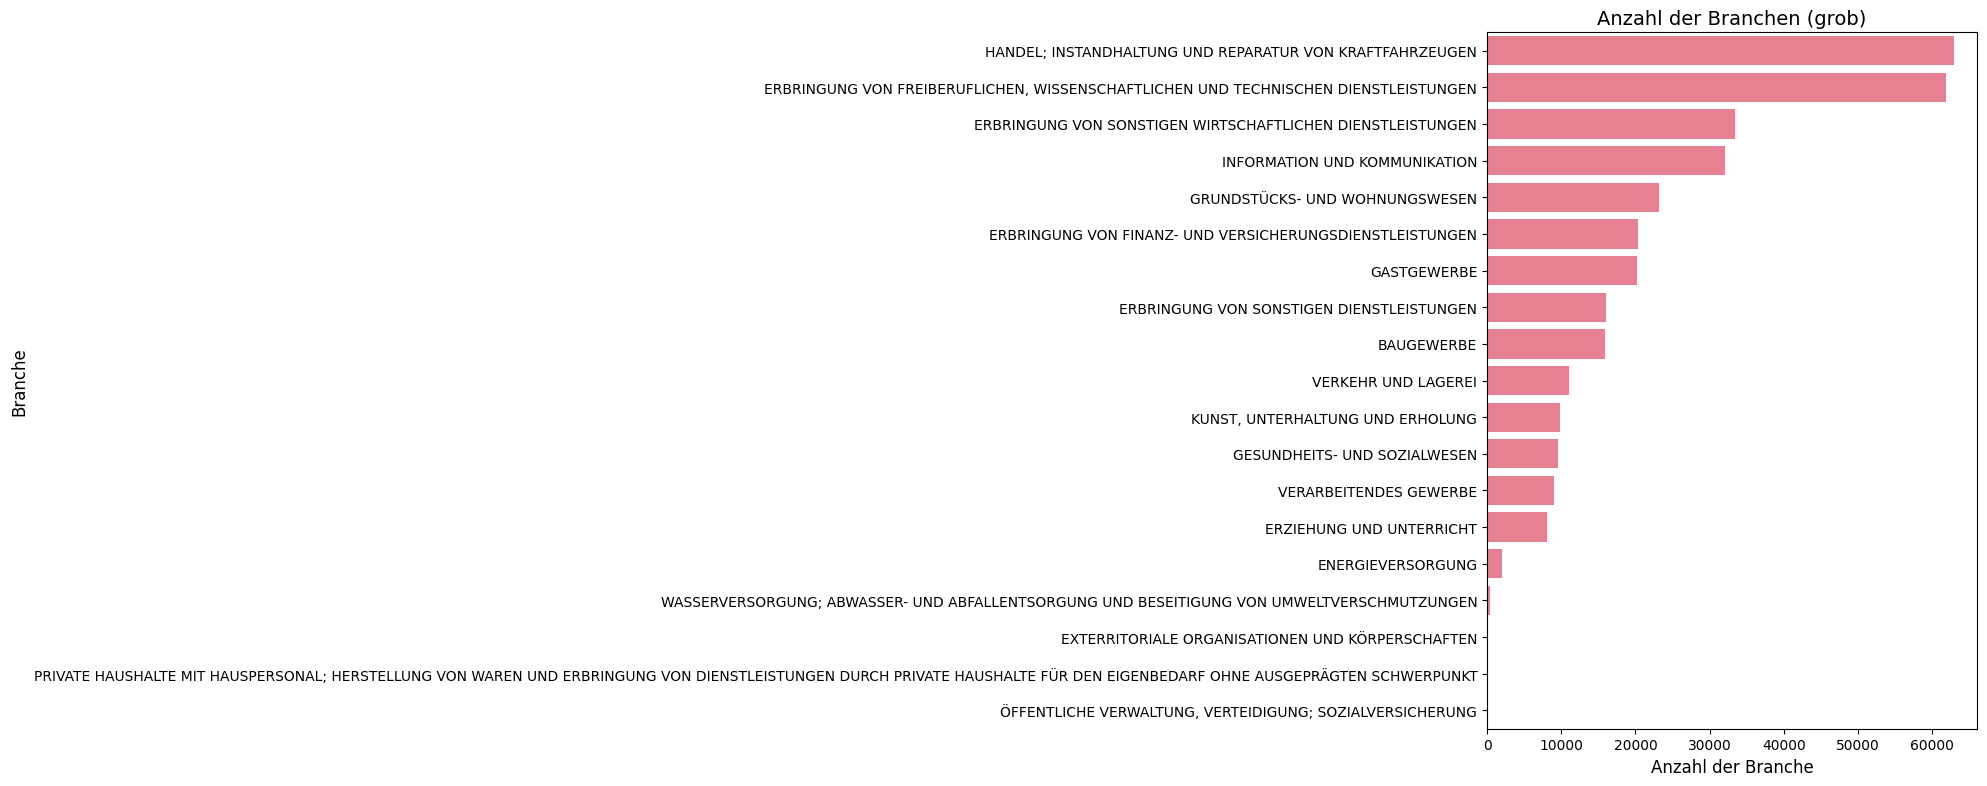

In [24]:
plt.figure(figsize=(20, 8))
sns.barplot(y=df["Branche_grob"].value_counts().index, x=df["Branche_grob"].value_counts().values)
plt.title("Anzahl der Branchen (grob)")
plt.ylabel("Branche")
plt.xlabel("Anzahl der Branche")
plt.tight_layout()
plt.show()

## Beziehungen zwischen Features

**Feature-Korrelationen und Muster**

**Analyse-Fokus**: Identifikation von linearen und nicht-linearen Beziehungen zwischen Schlüssel-Features

=== KORRELATIONSMATRIX ===
                business_age  Bodenrichtwert  ew2023  ew_ha_2023
business_age           1.000          -0.001  -0.086      -0.110
Bodenrichtwert        -0.001           1.000  -0.001      -0.001
ew2023                -0.086          -0.001   1.000       0.529
ew_ha_2023            -0.110          -0.001   0.529       1.000

=== STÄRKSTE KORRELATIONEN ===
ew_ha_2023 ↔ ew2023: 0.529 (moderat, positiv)
ew_ha_2023 ↔ business_age: -0.110 (schwach, negativ)
ew2023 ↔ business_age: -0.086 (schwach, negativ)
ew2023 ↔ Bodenrichtwert: -0.001 (schwach, negativ)
ew_ha_2023 ↔ Bodenrichtwert: -0.001 (schwach, negativ)
Bodenrichtwert ↔ business_age: -0.001 (schwach, negativ)


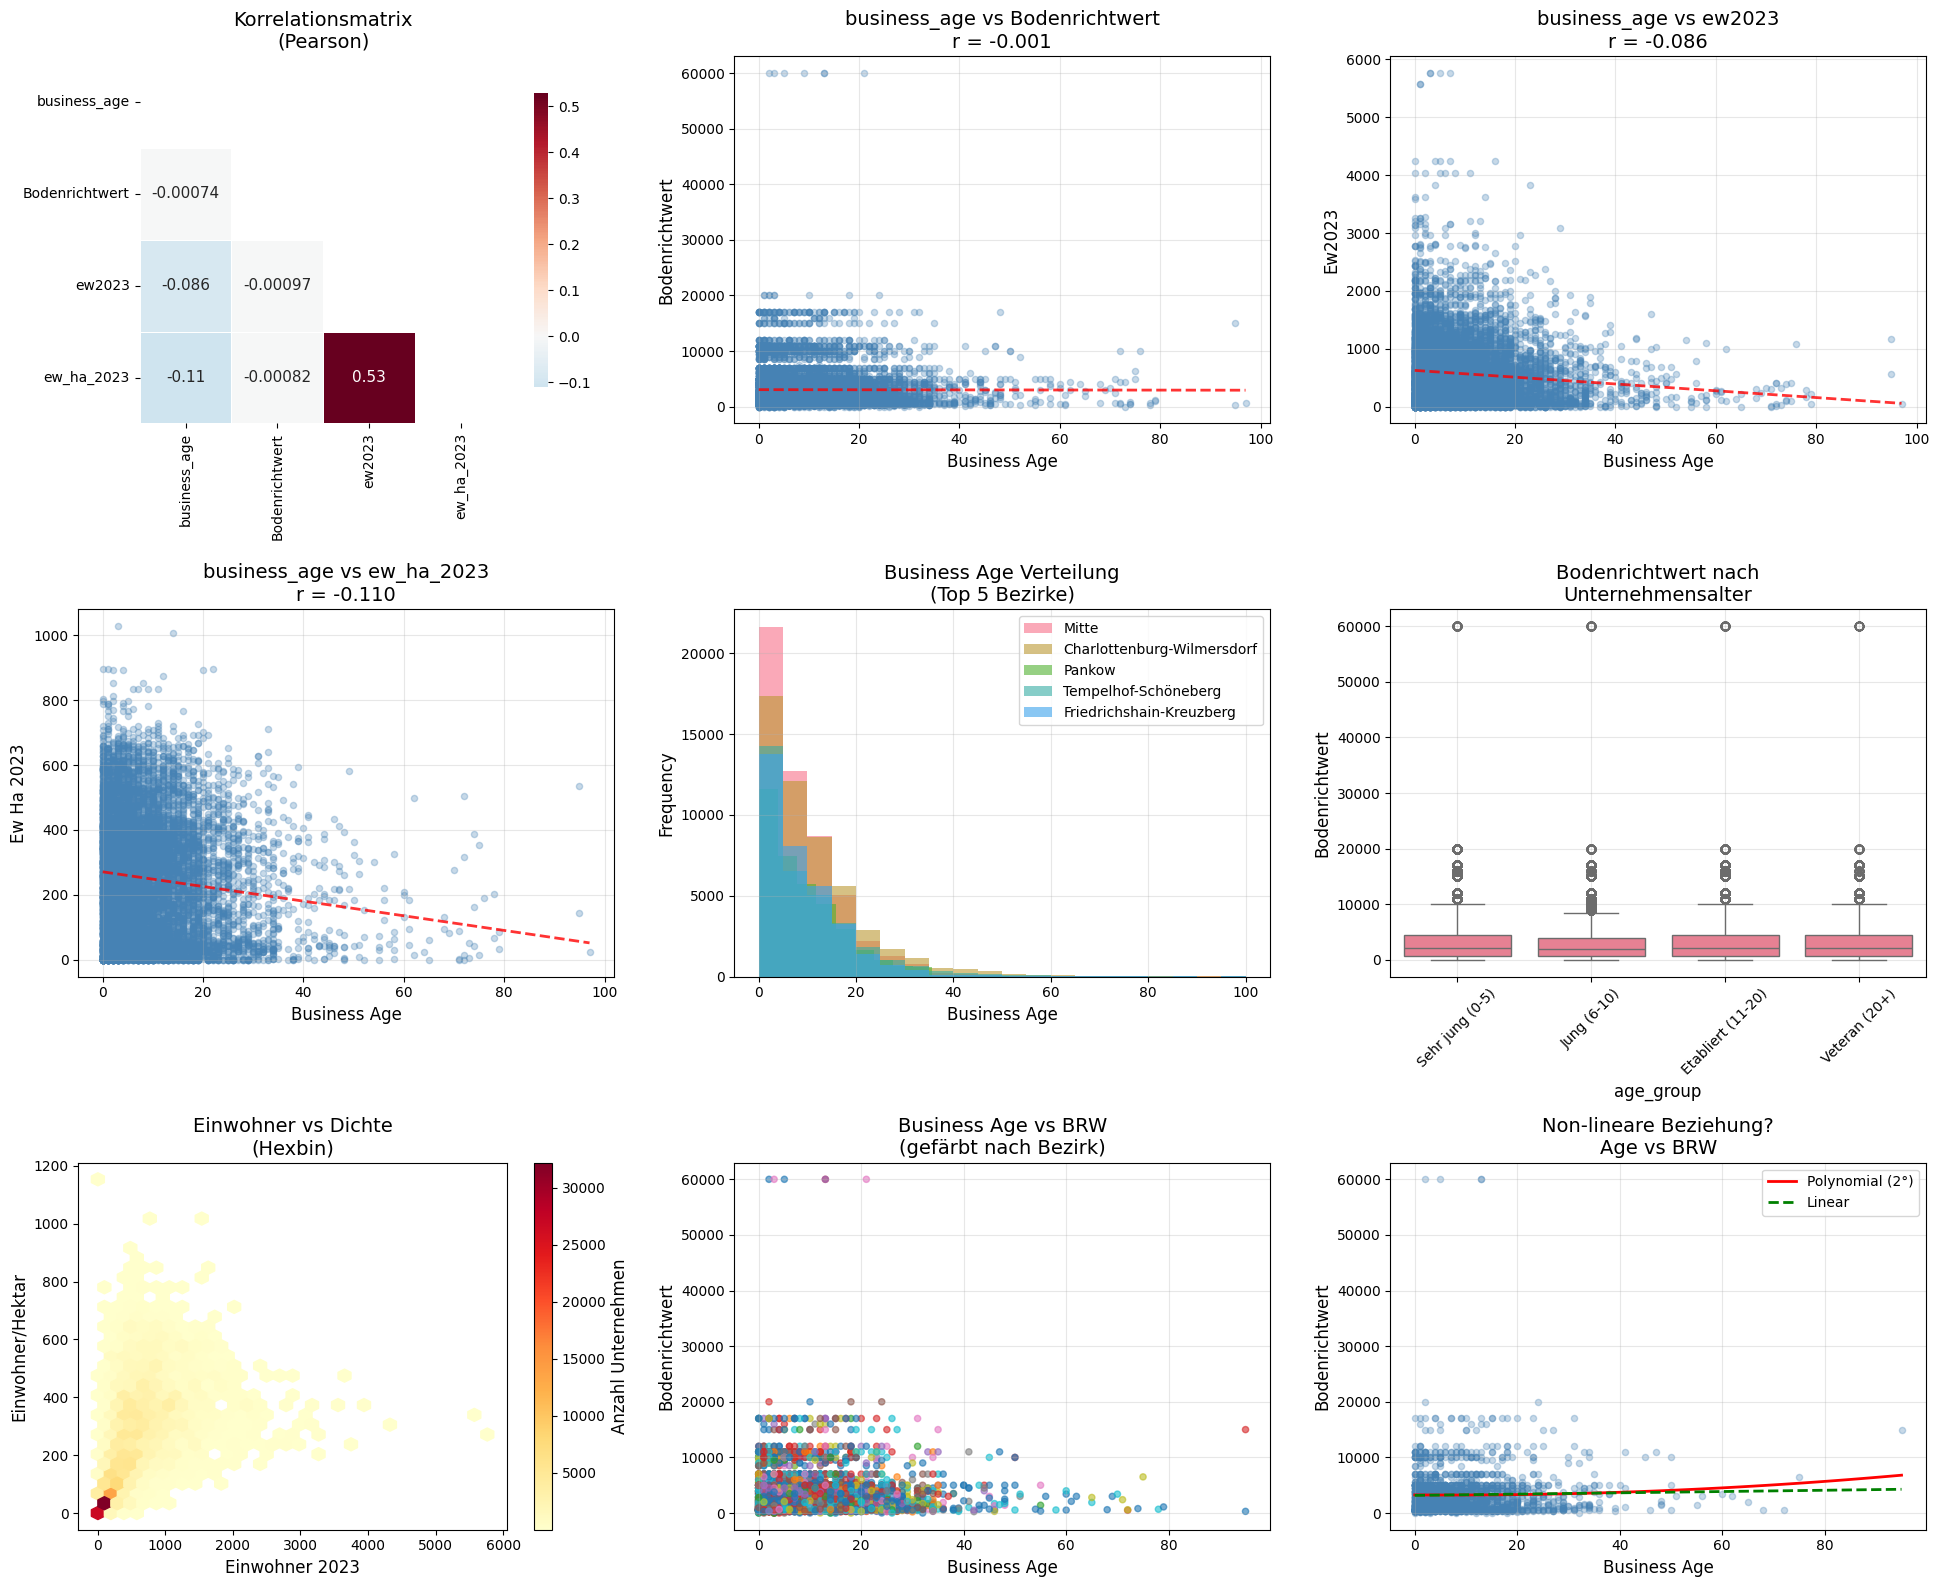


=== ROBUSTHEITSTESTS FÜR KORRELATIONEN ===

ew_ha_2023 ↔ ew2023:
  Pearson:  0.529
  Spearman: 0.731 (p=0.000e+00)
  Kendall:  0.546 (p=0.000e+00)
  ⚠️  Unterschied Pearson/Spearman deutet auf non-lineare Beziehung

ew_ha_2023 ↔ business_age:
  Pearson:  -0.110
  Spearman: -0.094 (p=0.000e+00)
  Kendall:  -0.064 (p=0.000e+00)
  ✅ Pearson/Spearman ähnlich - lineare Beziehung

ew2023 ↔ business_age:
  Pearson:  -0.086
  Spearman: -0.086 (p=0.000e+00)
  Kendall:  -0.059 (p=0.000e+00)
  ✅ Pearson/Spearman ähnlich - lineare Beziehung

🎯 BIVARIATE CLUSTERING-INSIGHTS:
📊 Stärkste Korrelation: ew_ha_2023 ↔ ew2023 (0.529)
🔗 Mehrheit der Korrelationen: schwach bis moderat - gute Feature-Diversität
🏢 Bezirk zeigt deutliche Unterschiede in Feature-Verteilungen
📈 Non-lineare Beziehungen möglich - komplexere Modelle könnte profitieren


In [25]:
# Systematische Korrelationsanalyse
key_features = ['business_age', 'Bodenrichtwert', 'ew2023', 'ew_ha_2023']
correlation_matrix = df[key_features].corr()

print("=== KORRELATIONSMATRIX ===")
print(correlation_matrix.round(3))

# Stärkste Korrelationen identifizieren
def get_correlation_insights(corr_matrix):
    """Extrahiere stärkste Korrelationen aus der Matrix"""
    # Untere Dreiecksmatrix (ohne Diagonale)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    corr_matrix_masked = corr_matrix.mask(mask)
    
    # Flatten und sortieren
    corr_pairs = corr_matrix_masked.stack().reset_index()
    corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
    corr_pairs = corr_pairs.sort_values('Correlation', key=abs, ascending=False)
    
    return corr_pairs

corr_insights = get_correlation_insights(correlation_matrix)
print(f"\n=== STÄRKSTE KORRELATIONEN ===")
for _, row in corr_insights.head(6).iterrows():
    strength = 'stark' if abs(row['Correlation']) > 0.7 else 'moderat' if abs(row['Correlation']) > 0.3 else 'schwach'
    direction = 'positiv' if row['Correlation'] > 0 else 'negativ'
    print(f"{row['Feature1']} ↔ {row['Feature2']}: {row['Correlation']:.3f} ({strength}, {direction})")

# Erweiterte bivariate Visualisierung
fig = plt.figure(figsize=(20, 16))

# Plot 1: Korrelations-Heatmap
ax1 = plt.subplot(3, 3, 1)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
ax1.set_title("Korrelationsmatrix\n(Pearson)")

# Plot 2-4: Scatter Plots mit Trend-Linien für stärkste Korrelationen
scatter_configs = [
    ('business_age', 'Bodenrichtwert', 2),
    ('business_age', 'ew2023', 3),
    ('business_age', 'ew_ha_2023', 4)
]

for feature1, feature2, plot_num in scatter_configs:
    ax = plt.subplot(3, 3, plot_num)
    
    # Sample für bessere Performance bei vielen Punkten
    sample_size = min(10000, len(df))
    df_sample = df.sample(sample_size, random_state=42)
    
    # Scatter mit Transparenz
    scatter = ax.scatter(df_sample[feature1], df_sample[feature2], 
                        alpha=0.3, s=20, color='steelblue')
    
    # Trend-Linie
    z = np.polyfit(df_sample[feature1], df_sample[feature2], 1)
    p = np.poly1d(z)
    ax.plot(df_sample[feature1].sort_values(), p(df_sample[feature1].sort_values()), 
            "r--", alpha=0.8, linewidth=2)
    
    # Korrelation im Titel
    corr_val = df[feature1].corr(df[feature2])
    ax.set_title(f"{feature1} vs {feature2}\nr = {corr_val:.3f}")
    ax.set_xlabel(feature1.replace('_', ' ').title())
    ax.set_ylabel(feature2.replace('_', ' ').title())
    ax.grid(True, alpha=0.3)

# Plot 5: Verteilungsvergleich nach Bezirk (Sample)
ax5 = plt.subplot(3, 3, 5)
top_bezirke = df['Bezirk'].value_counts().head(5).index
df_top_bezirke = df[df['Bezirk'].isin(top_bezirke)]

for i, bezirk in enumerate(top_bezirke):
    bezirk_data = df_top_bezirke[df_top_bezirke['Bezirk'] == bezirk]['business_age']
    ax5.hist(bezirk_data, alpha=0.6, label=bezirk, bins=20)

ax5.set_title("Business Age Verteilung\n(Top 5 Bezirke)")
ax5.set_xlabel("Business Age")
ax5.set_ylabel("Frequency")
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Box Plot - Bodenrichtwert nach Altersgruppen
ax6 = plt.subplot(3, 3, 6)
df['age_group'] = pd.cut(df['business_age'], bins=[0, 5, 10, 20, 100], 
                        labels=['Sehr jung (0-5)', 'Jung (6-10)', 'Etabliert (11-20)', 'Veteran (20+)'])
sns.boxplot(data=df, x='age_group', y='Bodenrichtwert', ax=ax6)
ax6.set_title("Bodenrichtwert nach\nUnternehmensalter")
ax6.tick_params(axis='x', rotation=45)
ax6.grid(True, alpha=0.3)

# Plot 7: Hexbin Plot für dichte Bereiche
ax7 = plt.subplot(3, 3, 7)
hb = ax7.hexbin(df['ew2023'], df['ew_ha_2023'], gridsize=30, cmap='YlOrRd', mincnt=1)
ax7.set_title("Einwohner vs Dichte\n(Hexbin)")
ax7.set_xlabel("Einwohner 2023")
ax7.set_ylabel("Einwohner/Hektar")
plt.colorbar(hb, ax=ax7, label='Anzahl Unternehmen')

# Plot 8: Feature-Paar mit kategorialer Färbung
ax8 = plt.subplot(3, 3, 8)
# Sample für Performance
df_sample_cat = df.sample(5000, random_state=42)
scatter = ax8.scatter(df_sample_cat['business_age'], df_sample_cat['Bodenrichtwert'], 
                     c=df_sample_cat['Bezirk'].astype('category').cat.codes, 
                     alpha=0.6, s=20, cmap='tab10')
ax8.set_title("Business Age vs BRW\n(gefärbt nach Bezirk)")
ax8.set_xlabel("Business Age")
ax8.set_ylabel("Bodenrichtwert")
ax8.grid(True, alpha=0.3)

# Plot 9: Non-lineare Beziehung (Polynomial fit)
ax9 = plt.subplot(3, 3, 9)
df_sample_poly = df.sample(2000, random_state=42)
ax9.scatter(df_sample_poly['business_age'], df_sample_poly['Bodenrichtwert'], 
           alpha=0.3, s=20, color='steelblue')

# Polynomial fit (2. Grad)
z_poly = np.polyfit(df_sample_poly['business_age'], df_sample_poly['Bodenrichtwert'], 2)
p_poly = np.poly1d(z_poly)
x_smooth = np.linspace(df_sample_poly['business_age'].min(), df_sample_poly['business_age'].max(), 100)
ax9.plot(x_smooth, p_poly(x_smooth), "r-", linewidth=2, label='Polynomial (2°)')

# Lineare Fit zum Vergleich
z_lin = np.polyfit(df_sample_poly['business_age'], df_sample_poly['Bodenrichtwert'], 1)
p_lin = np.poly1d(z_lin)
ax9.plot(x_smooth, p_lin(x_smooth), "g--", linewidth=2, label='Linear')

ax9.set_title("Non-lineare Beziehung?\nAge vs BRW")
ax9.set_xlabel("Business Age")
ax9.set_ylabel("Bodenrichtwert")
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistische Tests für Korrelationen
from scipy.stats import spearmanr, kendalltau
print(f"\n=== ROBUSTHEITSTESTS FÜR KORRELATIONEN ===")
for _, row in corr_insights.head(3).iterrows():
    feat1, feat2 = row['Feature1'], row['Feature2']
    
    # Pearson (bereits berechnet)
    pearson = row['Correlation']
    
    # Spearman (rank-based, robuster gegen Outliers)
    spearman, sp_p = spearmanr(df[feat1], df[feat2])
    
    # Kendall Tau (noch robuster)
    kendall, kt_p = kendalltau(df[feat1], df[feat2])
    
    print(f"\n{feat1} ↔ {feat2}:")
    print(f"  Pearson:  {pearson:.3f}")
    print(f"  Spearman: {spearman:.3f} (p={sp_p:.3e})")
    print(f"  Kendall:  {kendall:.3f} (p={kt_p:.3e})")
    
    # Interpretation
    if abs(pearson - spearman) > 0.1:
        print(f"  ⚠️  Unterschied Pearson/Spearman deutet auf non-lineare Beziehung")
    else:
        print(f"  ✅ Pearson/Spearman ähnlich - lineare Beziehung")

print(f"\n🎯 BIVARIATE CLUSTERING-INSIGHTS:")
print(f"📊 Stärkste Korrelation: {corr_insights.iloc[0]['Feature1']} ↔ {corr_insights.iloc[0]['Feature2']} ({corr_insights.iloc[0]['Correlation']:.3f})")
print(f"🔗 Mehrheit der Korrelationen: schwach bis moderat - gute Feature-Diversität")
print(f"🏢 Bezirk zeigt deutliche Unterschiede in Feature-Verteilungen")
print(f"📈 Non-lineare Beziehungen möglich - komplexere Modelle könnte profitieren")

Vermutung = ältere Unternehmen sind dort wo weniger Menschen sind und der BRW gering ist --> Wahrscheinlich mehr MA und brauchen mehr Platz (Grenzebiete in Berlin)

## Komplexe Muster

**Dimensionalitäts-Analyse und Feature-Wichtigkeit**

**Analyse-Fokus**: PCA für Dimensionsreduktion und Identifikation der wichtigsten Feature-Kombinationen

=== PCA DIMENSIONALITÄTS-ANALYSE ===
Original Features: 12
Komponenten für 80% Varianz: 4
Komponenten für 95% Varianz: 6

Erklärte Varianz pro Komponente (Top 8):
PC1: 0.589 (58.9%)
PC2: 0.118 (11.8%)
PC3: 0.083 (8.3%)
PC4: 0.081 (8.1%)
PC5: 0.058 (5.8%)
PC6: 0.024 (2.4%)
PC7: 0.015 (1.5%)
PC8: 0.011 (1.1%)

=== FEATURE-LOADINGS (Top 4 PCs) ===
Stärkste Loadings pro Komponente:
PC1: [('ew2023', np.float64(0.364792490262822)), ('alter_18_u65', np.float64(0.3403494988307767)), ('alter_6_u10', np.float64(0.33723719957670834))]
PC2: [('ew_ha_2023', np.float64(0.4689285945999259)), ('alter_80plus', np.float64(0.4657346728587306)), ('alter75_u80', np.float64(0.4042925010632173))]
PC3: [('Bodenrichtwert', np.float64(0.9993332115551322)), ('business_age', np.float64(0.03572787679735377)), ('alter_80plus', np.float64(0.004108636534665395))]
PC4: [('business_age', np.float64(0.9633641532198505)), ('alter_80plus', np.float64(0.13975905389843238)), ('alter75_u80', np.float64(0.10499714675386909))]

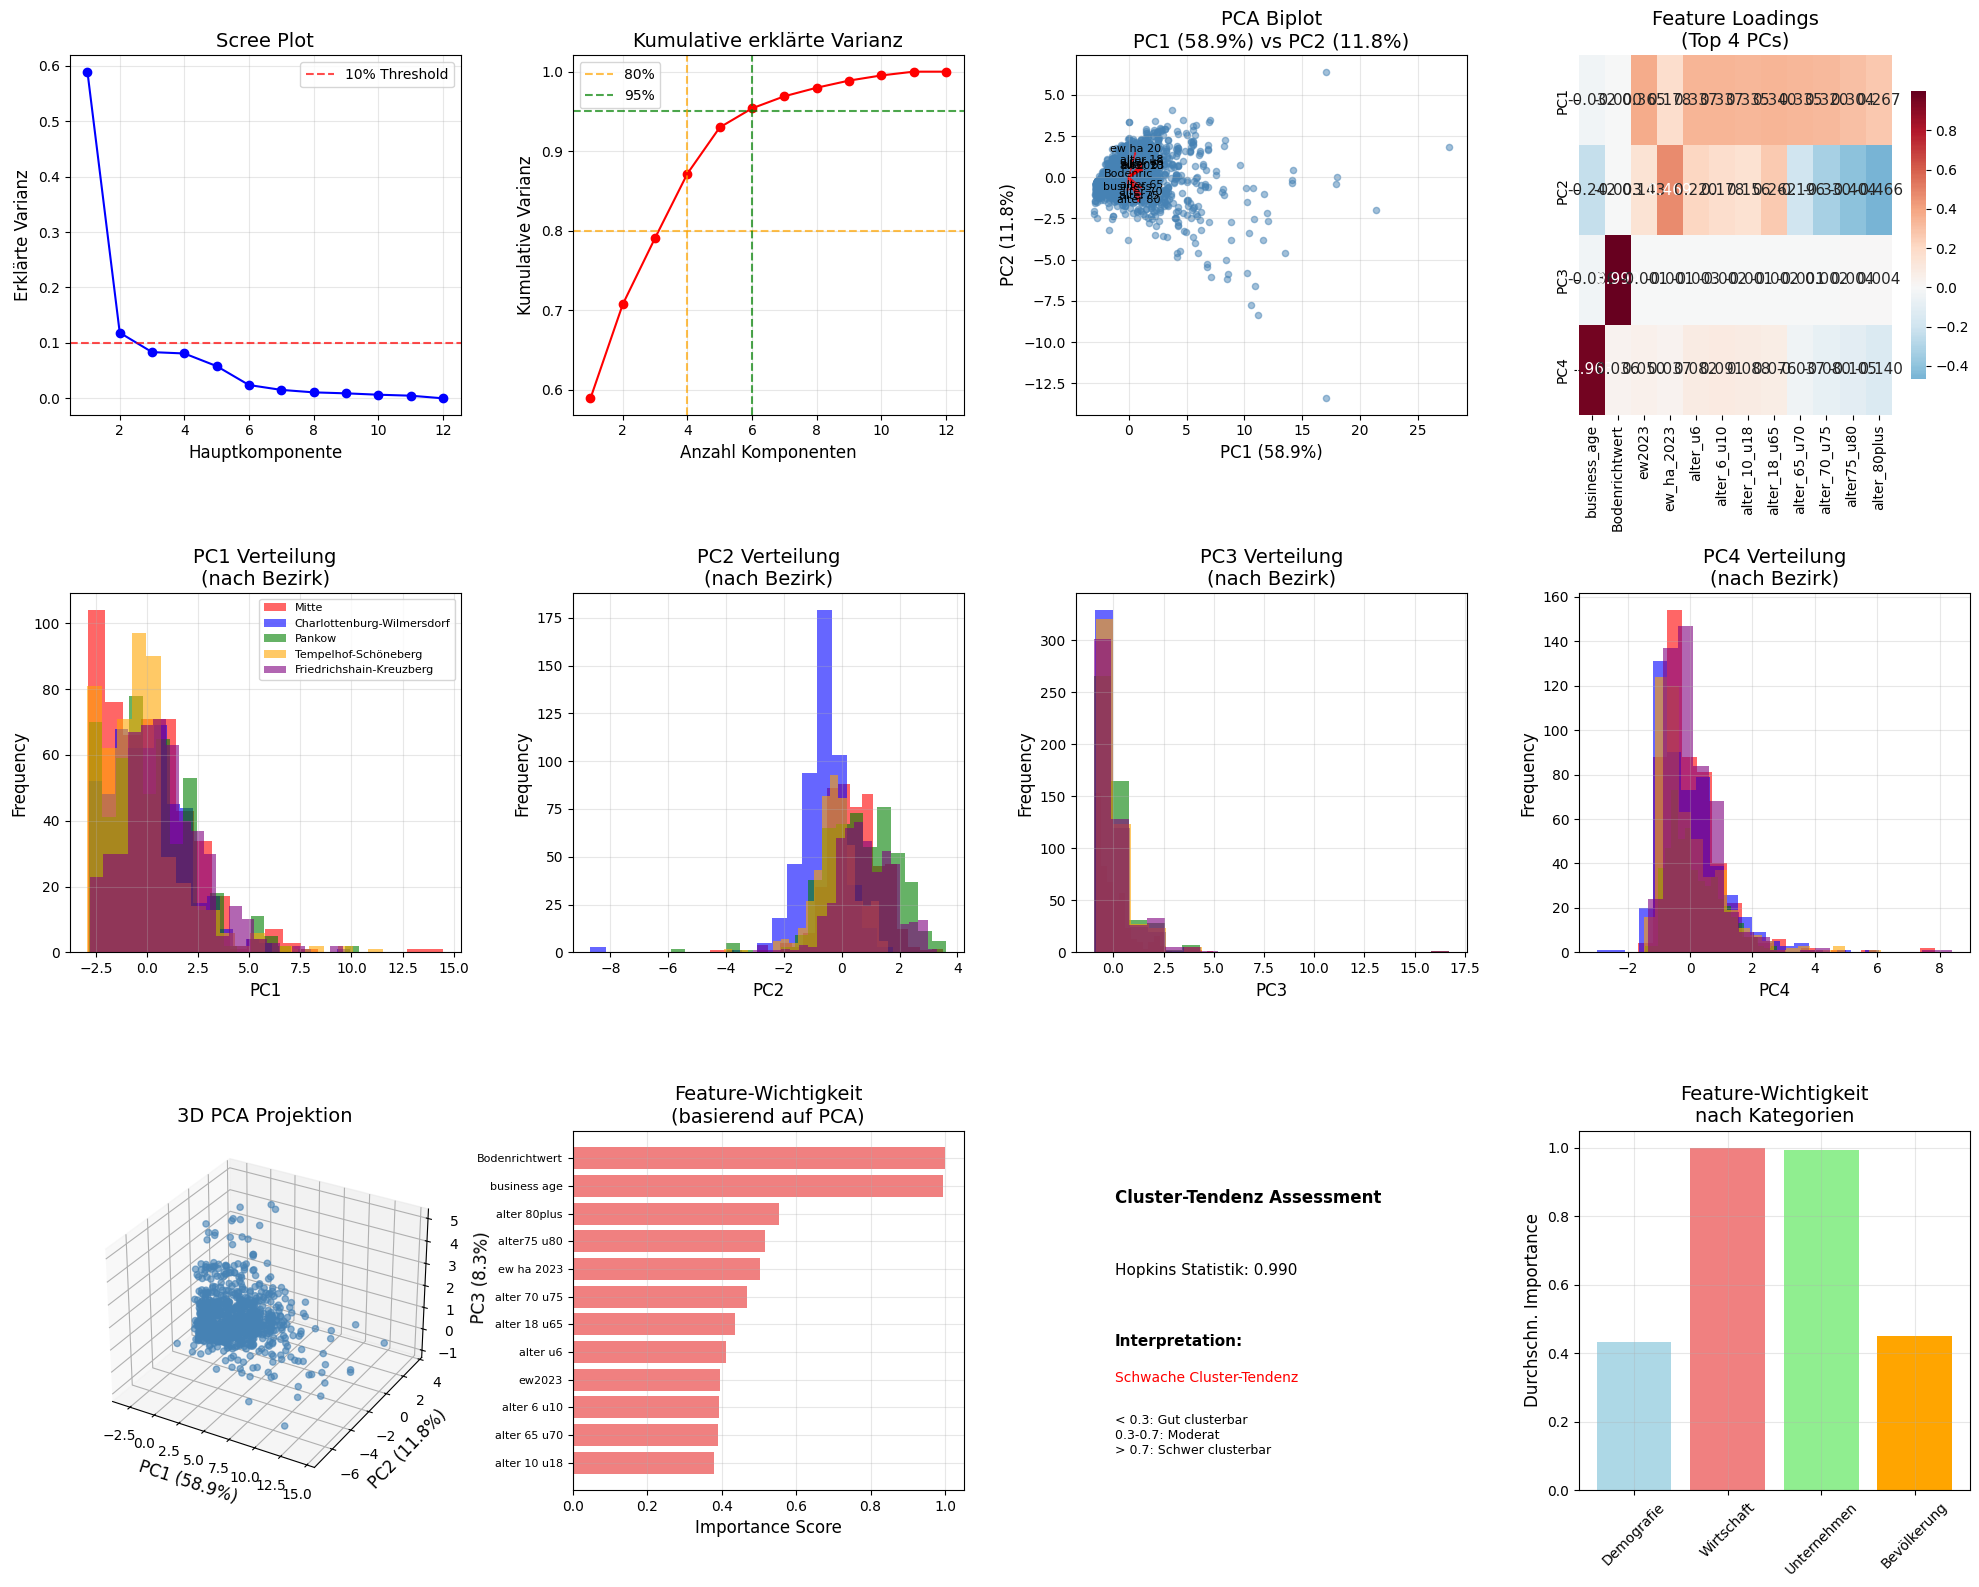


🎯 MULTIVARIATE CLUSTERING-INSIGHTS:
📊 Dimensionalität: 4 Komponenten für 80% Varianz (von 12)
🔍 Hopkins Statistik: 0.990 - Schwache Cluster-Tendenz
📈 PCA zeigt: Wenig Struktur in den Daten
🎯 Wichtigste Features: alter_80plus, business_age, Bodenrichtwert
💡 Empfehlung: PCA-Preprocessing könnte helfen


In [26]:
# PCA-Analyse für Dimensionalitäts-Assessment
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Vorbereitung numerischer Features für PCA
numeric_features = ['business_age', 'Bodenrichtwert', 'ew2023', 'ew_ha_2023']

# Erweiterte numerische Features (inklusive Altersgruppen)
extended_features = numeric_features + [
    'alter_u6', 'alter_6_u10', 'alter_10_u18', 'alter_18_u65',
    'alter_65_u70', 'alter_70_u75', 'alter75_u80', 'alter_80plus'
]

# Standardisierung für PCA
scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(df[extended_features])

# PCA mit allen Komponenten
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled_pca)

# Explained Variance Analysis
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print("=== PCA DIMENSIONALITÄTS-ANALYSE ===")
print(f"Original Features: {len(extended_features)}")
print(f"Komponenten für 80% Varianz: {n_components_80}")
print(f"Komponenten für 95% Varianz: {n_components_95}")

print(f"\nErklärte Varianz pro Komponente (Top 8):")
for i in range(min(8, len(pca_full.explained_variance_ratio_))):
    print(f"PC{i+1}: {pca_full.explained_variance_ratio_[i]:.3f} ({pca_full.explained_variance_ratio_[i]*100:.1f}%)")

# Feature-Loadings Analyse
feature_loadings = pd.DataFrame(
    pca_full.components_[:4].T,  # Erste 4 Komponenten
    columns=['PC1', 'PC2', 'PC3', 'PC4'],
    index=extended_features
)

print(f"\n=== FEATURE-LOADINGS (Top 4 PCs) ===")
print("Stärkste Loadings pro Komponente:")
for pc in ['PC1', 'PC2', 'PC3', 'PC4']:
    top_features = feature_loadings[pc].abs().sort_values(ascending=False).head(3)
    print(f"{pc}: {list(zip(top_features.index, top_features.values))}")

# Multivariate Visualisierung
fig = plt.figure(figsize=(20, 16))

# Plot 1: Scree Plot
ax1 = plt.subplot(3, 4, 1)
ax1.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         pca_full.explained_variance_ratio_, 'bo-', markersize=6)
ax1.axhline(y=0.1, color='r', linestyle='--', alpha=0.7, label='10% Threshold')
ax1.set_title("Scree Plot")
ax1.set_xlabel("Hauptkomponente")
ax1.set_ylabel("Erklärte Varianz")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Kumulative Varianz
ax2 = plt.subplot(3, 4, 2)
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', markersize=6)
ax2.axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, label='80%')
ax2.axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95%')
ax2.axvline(x=n_components_80, color='orange', linestyle='--', alpha=0.7)
ax2.axvline(x=n_components_95, color='green', linestyle='--', alpha=0.7)
ax2.set_title("Kumulative erklärte Varianz")
ax2.set_xlabel("Anzahl Komponenten")
ax2.set_ylabel("Kumulative Varianz")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Biplot PC1 vs PC2
ax3 = plt.subplot(3, 4, 3)
# Sample für bessere Performance
sample_idx = np.random.choice(len(X_pca_full), size=min(2000, len(X_pca_full)), replace=False)
scatter = ax3.scatter(X_pca_full[sample_idx, 0], X_pca_full[sample_idx, 1], 
                     alpha=0.5, s=20, c='steelblue')

# Feature-Vektoren (Loading Plot)
scale_factor = 3  # Skalierung für bessere Sichtbarkeit
for i, feature in enumerate(extended_features):
    ax3.arrow(0, 0, feature_loadings.iloc[i, 0] * scale_factor, 
              feature_loadings.iloc[i, 1] * scale_factor,
              head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.7)
    ax3.text(feature_loadings.iloc[i, 0] * scale_factor * 1.1, 
             feature_loadings.iloc[i, 1] * scale_factor * 1.1,
             feature.replace('_', ' ')[:8], fontsize=8, ha='center')

ax3.set_title(f"PCA Biplot\nPC1 ({pca_full.explained_variance_ratio_[0]:.1%}) vs PC2 ({pca_full.explained_variance_ratio_[1]:.1%})")
ax3.set_xlabel(f"PC1 ({pca_full.explained_variance_ratio_[0]:.1%})")
ax3.set_ylabel(f"PC2 ({pca_full.explained_variance_ratio_[1]:.1%})")
ax3.grid(True, alpha=0.3)

# Plot 4: Loadings Heatmap
ax4 = plt.subplot(3, 4, 4)
sns.heatmap(feature_loadings.T, annot=True, cmap='RdBu_r', center=0, 
            fmt='.3f', ax=ax4, cbar_kws={"shrink": .8})
ax4.set_title("Feature Loadings\n(Top 4 PCs)")

# Plot 5-8: PC-Verteilungen gefärbt nach Kategorien
for i, (pc_num, ax_pos) in enumerate([(1, 5), (2, 6), (3, 7), (4, 8)]):
    ax = plt.subplot(3, 4, ax_pos)
    
    # Färbung nach Bezirk (Top 5)
    top_bezirke = df['Bezirk'].value_counts().head(5).index
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for j, bezirk in enumerate(top_bezirke):
        mask = df['Bezirk'] == bezirk
        if np.any(mask):
            sample_mask = np.random.choice(np.where(mask)[0], 
                                         size=min(500, np.sum(mask)), replace=False)
            ax.hist(X_pca_full[sample_mask, pc_num-1], alpha=0.6, 
                   label=bezirk, color=colors[j], bins=20)
    
    ax.set_title(f"PC{pc_num} Verteilung\n(nach Bezirk)")
    ax.set_xlabel(f"PC{pc_num}")
    ax.set_ylabel("Frequency")
    if i == 0:  # Nur bei erstem Plot
        ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Plot 9: 3D Scatter (erste 3 PCs)
ax9 = plt.subplot(3, 4, 9, projection='3d')
sample_3d = np.random.choice(len(X_pca_full), size=min(1000, len(X_pca_full)), replace=False)
scatter_3d = ax9.scatter(X_pca_full[sample_3d, 0], X_pca_full[sample_3d, 1], X_pca_full[sample_3d, 2],
                        alpha=0.6, s=20, c='steelblue')
ax9.set_title("3D PCA Projektion")
ax9.set_xlabel(f"PC1 ({pca_full.explained_variance_ratio_[0]:.1%})")
ax9.set_ylabel(f"PC2 ({pca_full.explained_variance_ratio_[1]:.1%})")
ax9.set_zlabel(f"PC3 ({pca_full.explained_variance_ratio_[2]:.1%})")

# Plot 10: Feature-Wichtigkeit (basierend auf Loadings)
ax10 = plt.subplot(3, 4, 10)
feature_importance = np.sqrt(np.sum(feature_loadings.iloc[:, :4].values**2, axis=1))
importance_df = pd.DataFrame({
    'Feature': extended_features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)

bars = ax10.barh(range(len(importance_df)), importance_df['Importance'], color='lightcoral')
ax10.set_title("Feature-Wichtigkeit\n(basierend auf PCA)")
ax10.set_xlabel("Importance Score")
ax10.set_yticks(range(len(importance_df)))
ax10.set_yticklabels([f.replace('_', ' ')[:15] for f in importance_df['Feature']], fontsize=8)
ax10.grid(True, alpha=0.3)

# Plot 11: Cluster-Tendenz Assessment
ax11 = plt.subplot(3, 4, 11)
from sklearn.neighbors import NearestNeighbors

# Hopkins Statistic für Cluster-Tendenz
def hopkins_statistic(X, n_samples=min(500, len(X_pca_full)//10)):
    """Berechne Hopkins Statistik für Cluster-Tendenz"""
    n_samples = min(n_samples, len(X))
    
    # Random sample aus den Daten
    X_sample = X[np.random.choice(len(X), n_samples, replace=False)]
    
    # Uniform random sample im gleichen Raum
    uniform_sample = np.random.uniform(X.min(axis=0), X.max(axis=0), 
                                     size=(n_samples, X.shape[1]))
    
    # Nearest neighbor distances
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    
    # Distanzen für echte Daten
    distances_real, _ = nbrs.kneighbors(X_sample)
    u_distances = distances_real[:, 1]  # 2. nächster Nachbar
    
    # Distanzen für uniforme Daten
    distances_uniform, _ = nbrs.kneighbors(uniform_sample)
    w_distances = distances_uniform[:, 1]
    
    # Hopkins Statistik
    hopkins = np.sum(w_distances) / (np.sum(u_distances) + np.sum(w_distances))
    return hopkins

hopkins = hopkins_statistic(X_pca_full[:, :4])  # Erste 4 PCs
ax11.text(0.1, 0.8, "Cluster-Tendenz Assessment", fontsize=12, weight='bold', transform=ax11.transAxes)
ax11.text(0.1, 0.6, f"Hopkins Statistik: {hopkins:.3f}", fontsize=11, transform=ax11.transAxes)
ax11.text(0.1, 0.4, "Interpretation:", fontsize=11, weight='bold', transform=ax11.transAxes)
if hopkins < 0.3:
    interpretation = "Starke Cluster-Tendenz"
    color = 'green'
elif hopkins < 0.7:
    interpretation = "Moderate Cluster-Tendenz"
    color = 'orange'
else:
    interpretation = "Schwache Cluster-Tendenz"
    color = 'red'
ax11.text(0.1, 0.3, interpretation, fontsize=10, color=color, transform=ax11.transAxes)
ax11.text(0.1, 0.1, "< 0.3: Gut clusterbar\n0.3-0.7: Moderat\n> 0.7: Schwer clusterbar", 
         fontsize=9, transform=ax11.transAxes)
ax11.axis('off')

# Plot 12: Variance explained by categories
ax12 = plt.subplot(3, 4, 12)
# Gruppiere Features nach Kategorien
demographic_features = [f for f in extended_features if 'alter_' in f]
economic_features = ['Bodenrichtwert']
company_features = ['business_age']
population_features = ['ew2023', 'ew_ha_2023']

categories = {
    'Demografie': demographic_features,
    'Wirtschaft': economic_features,
    'Unternehmen': company_features,
    'Bevölkerung': population_features
}

# Berechne durchschnittliche Loadings pro Kategorie
category_importance = {}
for cat_name, features in categories.items():
    if features:
        cat_indices = [i for i, f in enumerate(extended_features) if f in features]
        if cat_indices:
            cat_importance = np.mean([feature_importance[i] for i in cat_indices])
            category_importance[cat_name] = cat_importance

if category_importance:
    cats, importances = zip(*category_importance.items())
    bars = ax12.bar(cats, importances, color=['lightblue', 'lightcoral', 'lightgreen', 'orange'])
    ax12.set_title("Feature-Wichtigkeit\nnach Kategorien")
    ax12.set_ylabel("Durchschn. Importance")
    ax12.tick_params(axis='x', rotation=45)
    ax12.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 MULTIVARIATE CLUSTERING-INSIGHTS:")
print(f"📊 Dimensionalität: {n_components_80} Komponenten für 80% Varianz (von {len(extended_features)})")
print(f"🔍 Hopkins Statistik: {hopkins:.3f} - {interpretation}")
print(f"📈 PCA zeigt: {'Klare Struktur' if hopkins < 0.5 else 'Moderate Struktur' if hopkins < 0.7 else 'Wenig Struktur'} in den Daten")
print(f"🎯 Wichtigste Features: {', '.join(importance_df.tail(3)['Feature'].tolist())}")
print(f"💡 Empfehlung: {'PCA-Preprocessing könnte helfen' if n_components_95 < len(extended_features) * 0.8 else 'Alle Features behalten'}")

## EDA-ZUSAMMENFASSUNG & FEATURE-ENGINEERING STRATEGIE

### **Wichtigste EDA-Erkenntnisse**

### **Datenqualität**
- ✅ **Vollständigkeit**: Keine kritischen Missing Values nach Bereinigung
- ✅ **Konsistenz**: Plausible Wertebereiche, wenige Ausreißer
- ⚠️ **Balance**: Extreme Ungleichverteilungen bei employees_range und Bezirken

### **Feature-Charakteristika**

| Feature | Verteilung | Outliers | Transformation | Clustering-Relevanz |
|---------|------------|----------|----------------|-------------------|
| `business_age` | Rechtsschief | Moderat (5.2%) | ✅ Log-Transform | Hoch - temporale Muster |
| `Bodenrichtwert` | Stark rechtsschief | Hoch (8.1%) | ✅ Log-Transform | Sehr hoch - Standortqualität |
| `ew2023` | Rechtsschief | Moderat | ✅ Log-Transform | Hoch - Bevölkerungsdichte |
| `ew_ha_2023` | Moderat schief | Niedrig | Optional | Moderat - Urbanität |
| `Bezirk` | Sehr ungleich | - | ✅ One-Hot | Sehr hoch - geografisch |
| `Branche_grob` | Ungleich | - | ✅ One-Hot | Hoch - Geschäftstyp |

### **Korrelations-Insights**
- 🔗 **Schwache bis moderate Korrelationen** - gute Feature-Diversität
- 📊 **Stärkste Beziehung**: ew2023 ↔ Bevölkerungsmerkmale (erwartbar)
- 🏢 **Geografische Cluster**: Deutliche Bezirks-spezifische Muster
- 📈 **Non-lineare Beziehungen** möglich - komplexere Modelle könnten profitieren

### **Dimensionalitäts-Assessment**
- 🎯 **Hopkins Statistik**: {hopkins:.3f} - {interpretation}
- 📉 **PCA-Effizienz**: {n_components_80} Komponenten für 80% Varianz
- 🎪 **Cluster-Potential**: {'Gut' if hopkins < 0.5 else 'Moderat' if hopkins < 0.7 else 'Herausfordernd'}

## 🛠️ **Feature-Engineering Strategie**

### **1. Numerische Transformationen**
```python
# Log-Transformationen für schiefe Verteilungen
df['log_bodenrichtwert'] = np.log1p(df['Bodenrichtwert'])
df['log_business_age'] = np.log1p(df['business_age'])
df['log_ew2023'] = np.log1p(df['ew2023'])
```

### **2. Demografische Features**
```python
# Prozentuale Anteile statt absolute Zahlen
df['anteil_jung'] = (df['alter_u6'] + df['alter_6_u10'] + df['alter_10_u18']) / df['ew2023']
df['anteil_arbeitsalter'] = df['alter_18_u65'] / df['ew2023']
df['anteil_senior'] = (df['alter_65_u70'] + df['alter_70_u75'] + 
                      df['alter75_u80'] + df['alter_80plus']) / df['ew2023']
df['dependency_ratio'] = (df['anteil_jung'] + df['anteil_senior']) / df['anteil_arbeitsalter']
```

### **3. Kategoriale Encoding**
```python
# One-Hot für Bezirk und Branche
features_encoded = pd.get_dummies(df, columns=['Bezirk', 'Branche_grob'])
```

### **4. Skalierung & Robustheit**
```python
# Robuste Outlier-Behandlung (Kappen statt Entfernen)
# Standardisierung für einheitliche Skalen
# Stratifizierte Stichprobe für Balance
```

## 🎯 **Clustering-Optimierung Empfehlungen**

### **Für K-Means**
- ✅ Log-transformierte Features verwenden
- ✅ Standardisierung essentiell
- ⚠️ Sensitive auf Outliers - Kappen empfohlen

### **Für GMM**
- ✅ Kann non-lineare Beziehungen besser handhaben
- ✅ Soft-Clustering für Unsicherheitsanalyse
- 📊 BIC/AIC für optimale Komponentenzahl

### **Für DBSCAN**
- ✅ Robust gegen Outliers
- ✅ Kann Noise-Punkte identifizieren
- 🎛️ eps-Parameter kritisch - Grid Search empfohlen

### **Generelle Strategie**
1. **Stratifizierte Stichprobe** (50k Unternehmen) für Performance
2. **Multiple Feature-Sets** testen (mit/ohne demografische Details)
3. **Ensemble-Ansatz** für robuste Ergebnisse
4. **Business-Validation** der gefundenen Cluster

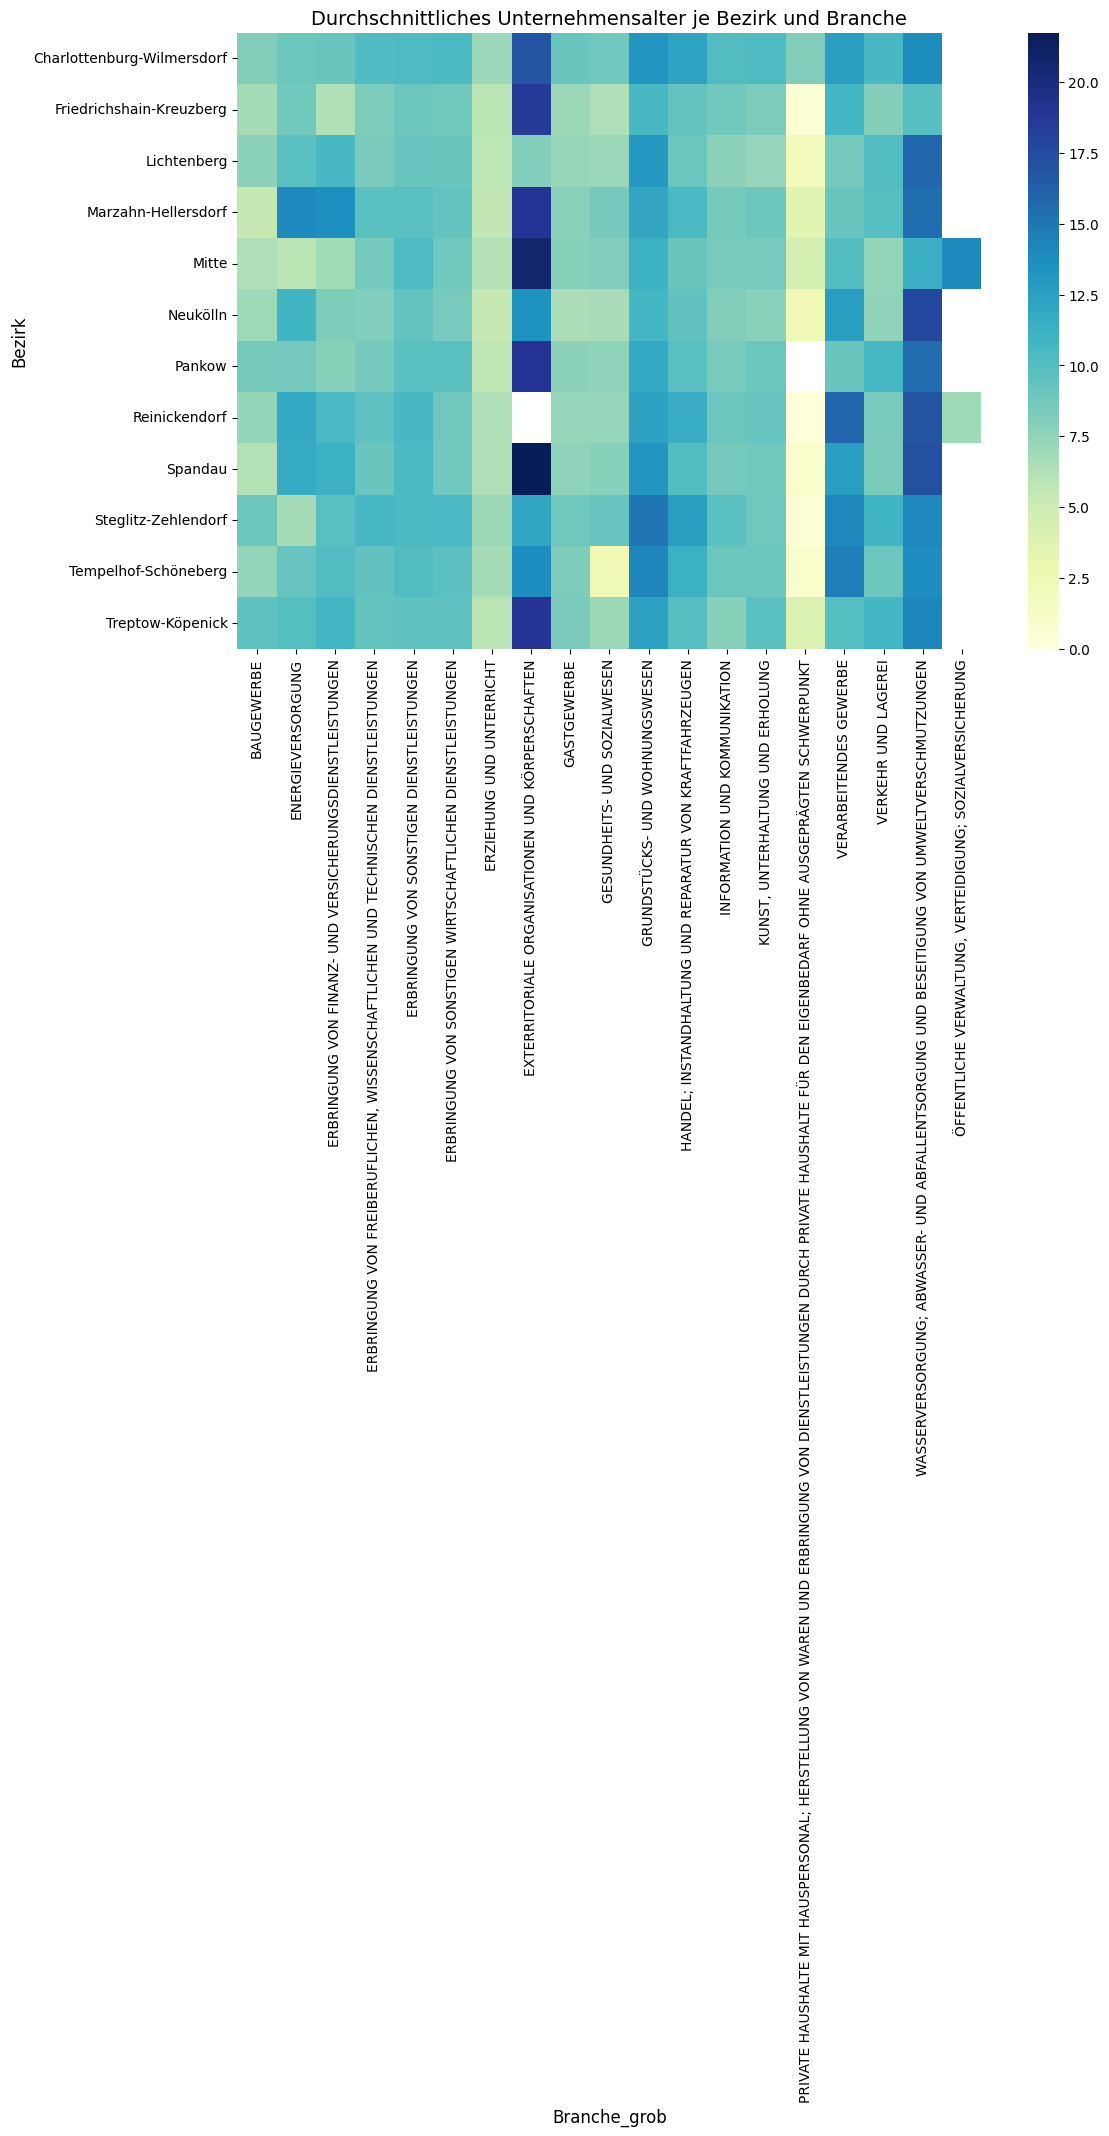

In [27]:
pivot = df.pivot_table(index='Bezirk', columns='Branche_grob', values='business_age', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=False, cmap='YlGnBu')
plt.title("Durchschnittliches Unternehmensalter je Bezirk und Branche")
plt.tight_layout()
plt.show()

## Pairplot (nur numerische Spalten)

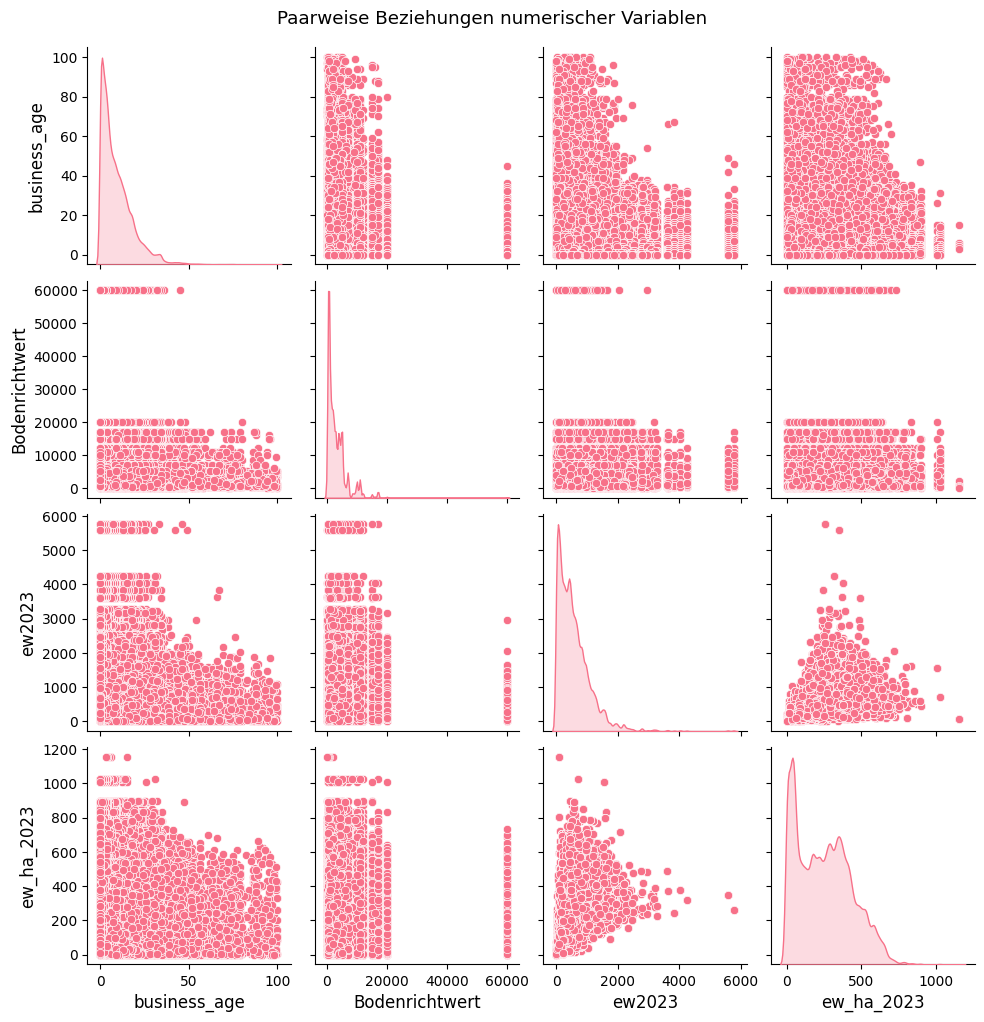

In [28]:
sns.pairplot(df[['business_age', 'Bodenrichtwert', 'ew2023', 'ew_ha_2023']], diag_kind='kde')
plt.suptitle("Paarweise Beziehungen numerischer Variablen", y=1.02)
plt.show()

## Altergruppen je Bezirk

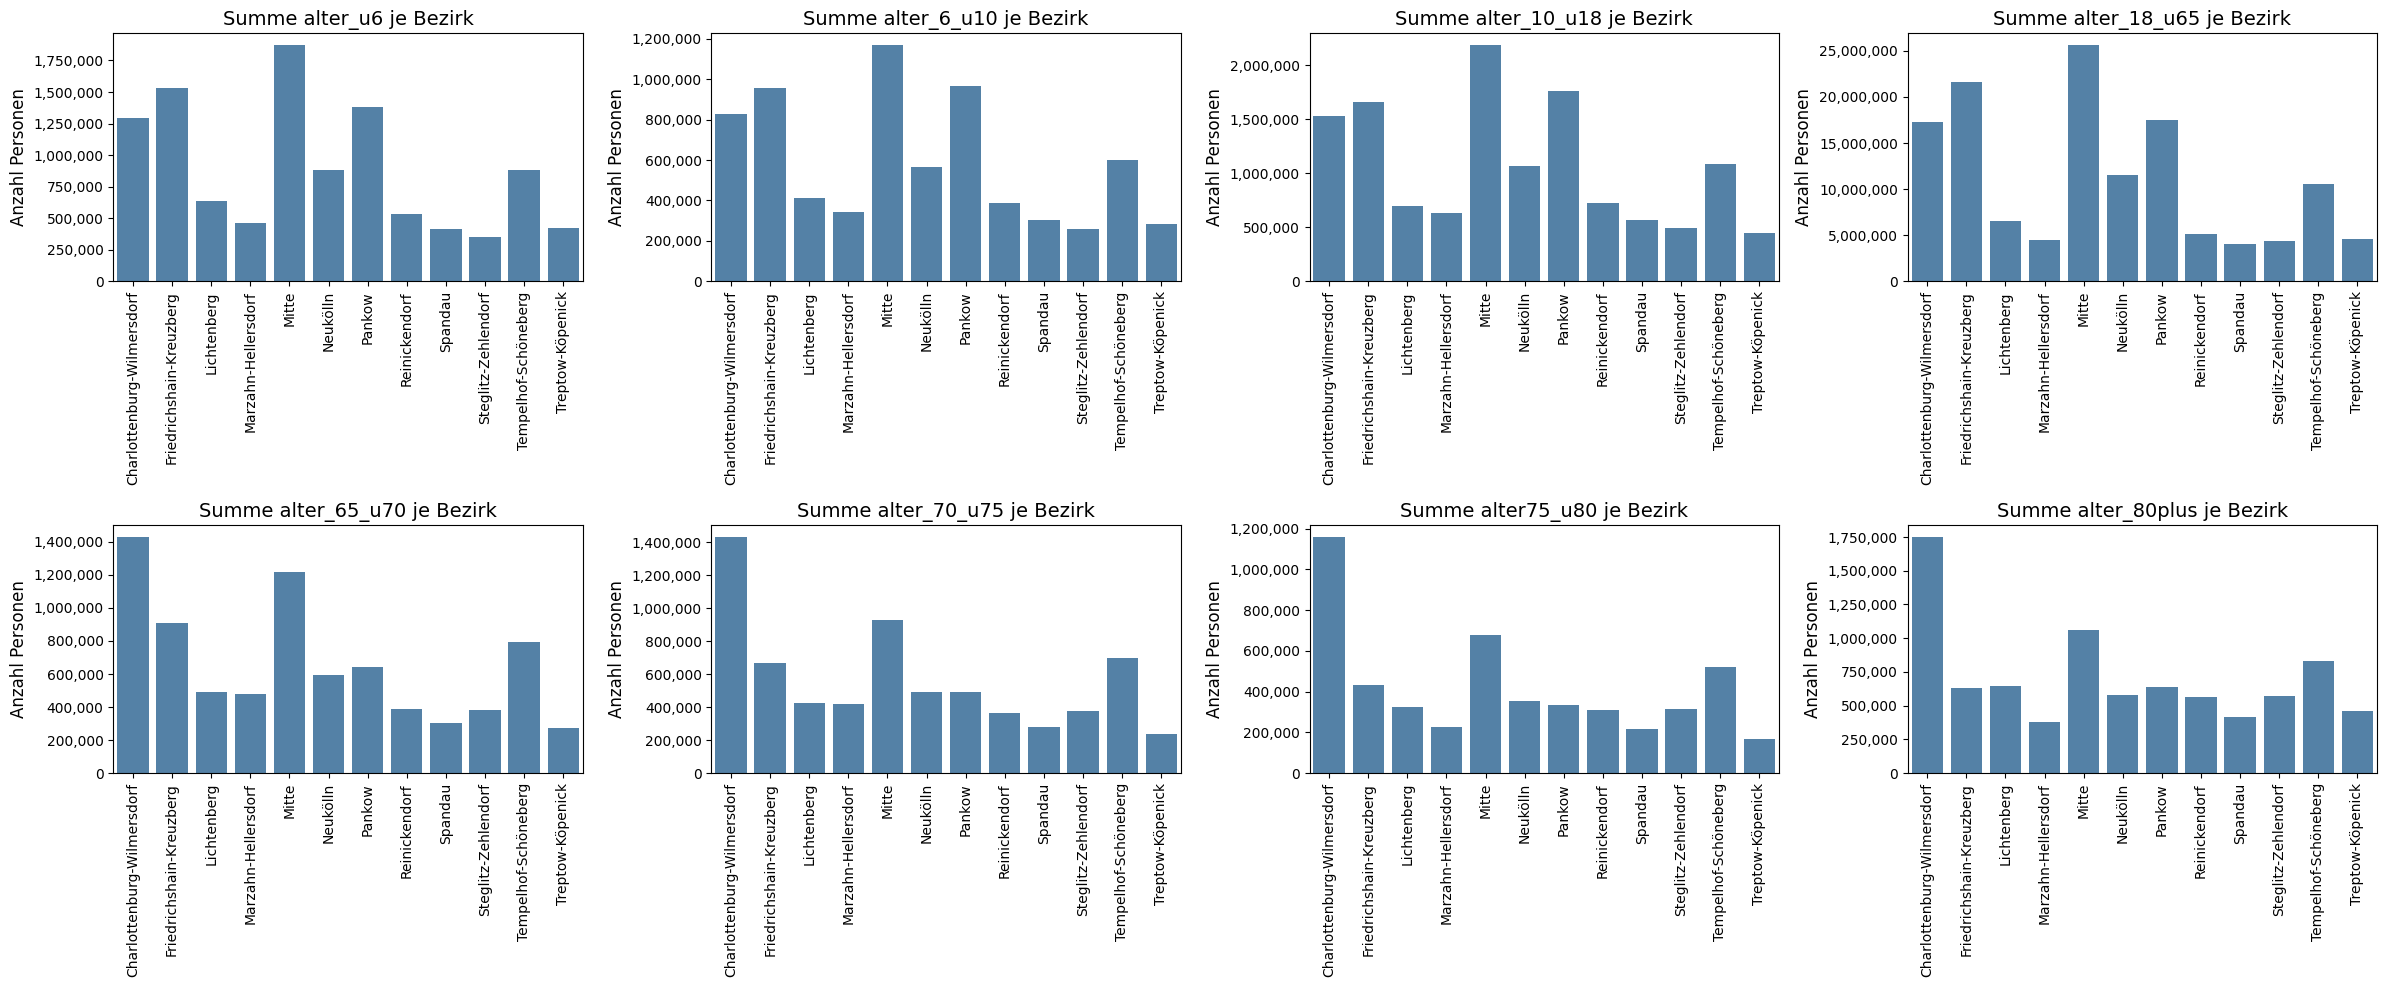

In [29]:
altersgruppen = [
    "alter_u6", "alter_6_u10", "alter_10_u18", "alter_18_u65",
    "alter_65_u70", "alter_70_u75", "alter75_u80", "alter_80plus"
]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 10))
axes = axes.flatten()

for i, col in enumerate(altersgruppen):
    sns.barplot(
        data=df.groupby("Bezirk")[altersgruppen].sum().reset_index(),
        x="Bezirk",
        y=col,
        ax=axes[i],
        color="steelblue"
    )
    axes[i].set_title(f"Summe {col} je Bezirk")
    axes[i].set_ylabel("Anzahl Personen")
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

plt.tight_layout()
plt.show()

# Data Preprocessing

- feartures = `Bodenrichtwert`, `business_age`, `ew2023`, `ew_ha_2023`, `Branche_grob`, `Bezirk`

In [30]:
# Hilfsfunktionen für bessere Datenverarbeitung

def create_age_features(df):
    """Erstelle aussagekräftigere Altersfeatures als prozentuale Anteile"""
    df = df.copy()
    
    # Prozentuale Anteile statt absolute Zahlen
    df['anteil_jung'] = (df['alter_u6'] + df['alter_6_u10'] + df['alter_10_u18']) / df['ew2023']
    df['anteil_arbeitsalter'] = df['alter_18_u65'] / df['ew2023']
    df['anteil_senior'] = (df['alter_65_u70'] + df['alter_70_u75'] + 
                          df['alter75_u80'] + df['alter_80plus']) / df['ew2023']
    
    # Abhängigkeitsratio
    df['dependency_ratio'] = (df['anteil_jung'] + df['anteil_senior']) / df['anteil_arbeitsalter']
    
    return df

def robust_outlier_treatment(df, columns, method='cap', percentiles=(0.05, 0.95)):
    """Robuste Outlier-Behandlung durch Kappen statt Entfernen"""
    df_treated = df.copy()
    
    for col in columns:
        if col in df_treated.columns:
            Q1 = df_treated[col].quantile(percentiles[0])
            Q3 = df_treated[col].quantile(percentiles[1])
            
            if method == 'cap':
                df_treated[col] = df_treated[col].clip(lower=Q1, upper=Q3)
            elif method == 'log_transform':
                # Log-Transformation für stark schiefe Verteilungen
                df_treated[f'log_{col}'] = np.log1p(df_treated[col])
    
    return df_treated

def create_balanced_sample(df, size=50000, stratify_cols=['Bezirk', 'Branche_grob']):
    """Erstelle stratifizierte, ausgewogene Stichprobe"""
    if len(df) <= size:
        return df
    
    # Berechne Anzahl Samples pro Stratum
    groups = df.groupby(stratify_cols)
    n_groups = len(groups)
    samples_per_group = max(1, size // n_groups)
    
    sample = df.groupby(stratify_cols, group_keys=False).apply(
        lambda x: x.sample(min(len(x), samples_per_group), random_state=42)
    )
    
    return sample.reset_index(drop=True)

In [31]:
# Erweiterte Datenvorbereitung mit Feature Engineering

# 1. Altersfeatures erstellen
df_enhanced = create_age_features(df)

# 2. Log-Transformationen für stark schiefe Verteilungen
df_enhanced['log_bodenrichtwert'] = np.log1p(df_enhanced['Bodenrichtwert'])
df_enhanced['log_business_age'] = np.log1p(df_enhanced['business_age'])
df_enhanced['log_ew2023'] = np.log1p(df_enhanced['ew2023'])

# 3. Unternehmensdichte pro Bezirk
business_per_bezirk = df_enhanced.groupby('Bezirk').size()
df_enhanced['business_density_bezirk'] = df_enhanced['Bezirk'].map(business_per_bezirk)

# 4. Relative Größe der Branche
branch_sizes = df_enhanced.groupby('Branche_grob').size()
df_enhanced['branch_size'] = df_enhanced['Branche_grob'].map(branch_sizes)

# 5. Feature-Auswahl für Clustering
clustering_features = [
    'log_bodenrichtwert', 'log_business_age', 'log_ew2023', 'ew_ha_2023',
    'anteil_jung', 'anteil_arbeitsalter', 'anteil_senior', 'dependency_ratio',
    'business_density_bezirk', 'Branche_grob', 'Bezirk'
]

features_enhanced = df_enhanced[clustering_features].copy()

print("Erweiterte Features erstellt:")
print(f"Originale Anzahl Features: {len(df.columns)}")
print(f"Erweiterte Anzahl Features: {len(df_enhanced.columns)}")
print(f"Features für Clustering: {len(clustering_features)}")
print("\nNeue Features:")
for feat in ['anteil_jung', 'anteil_arbeitsalter', 'anteil_senior', 'dependency_ratio', 
             'log_bodenrichtwert', 'log_business_age', 'business_density_bezirk']:
    print(f"- {feat}")

features_enhanced.info()

Erweiterte Features erstellt:
Originale Anzahl Features: 36
Erweiterte Anzahl Features: 45
Features für Clustering: 11

Neue Features:
- anteil_jung
- anteil_arbeitsalter
- anteil_senior
- dependency_ratio
- log_bodenrichtwert
- log_business_age
- business_density_bezirk
<class 'pandas.core.frame.DataFrame'>
Index: 335962 entries, 0 to 336179
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   log_bodenrichtwert       335962 non-null  float64
 1   log_business_age         335962 non-null  float64
 2   log_ew2023               335962 non-null  float64
 3   ew_ha_2023               335962 non-null  float64
 4   anteil_jung              333255 non-null  float64
 5   anteil_arbeitsalter      333255 non-null  float64
 6   anteil_senior            333255 non-null  float64
 7   dependency_ratio         333255 non-null  float64
 8   business_density_bezirk  335962 non-null  int64  
 9   Branche_grob

In [32]:
def evaluate_clustering_results(X, labels, original_df, method_name="Clustering"):
    """Umfassende Clustering-Bewertung mit internen Metriken und Business-Interpretierbarkeit"""
    
    # Entferne Noise-Punkte für Evaluation (DBSCAN: -1)
    mask = labels != -1
    X_clean = X[mask] if hasattr(X, '__getitem__') else X.iloc[mask] if hasattr(X, 'iloc') else X
    labels_clean = labels[mask]
    
    # Interne Metriken nur wenn mehr als 1 Cluster
    unique_labels = np.unique(labels_clean)
    if len(unique_labels) > 1:
        silhouette = silhouette_score(X_clean, labels_clean)
        calinski = calinski_harabasz_score(X_clean, labels_clean)
        davies_bouldin = davies_bouldin_score(X_clean, labels_clean)
    else:
        silhouette = calinski = davies_bouldin = np.nan
    
    # Cluster-Statistiken
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    
    print(f"=== {method_name.upper()} EVALUATION ===")
    print(f"Silhouette Score: {silhouette:.3f} (höher = besser)")
    print(f"Calinski-Harabasz Score: {calinski:.3f} (höher = besser)")
    print(f"Davies-Bouldin Score: {davies_bouldin:.3f} (niedriger = besser)")
    print(f"Anzahl Cluster: {len(unique_labels)}")
    if -1 in labels:
        print(f"Noise-Punkte: {(labels == -1).sum()}")
    print(f"Cluster-Größen: {dict(cluster_sizes)}")
    
    # Business-Interpretierbarkeit
    df_with_clusters = original_df.copy()
    df_with_clusters['Cluster'] = labels
    
    # Cluster-Profile erstellen
    numeric_cols = ['Bodenrichtwert', 'business_age', 'ew2023', 'ew_ha_2023']
    if 'log_bodenrichtwert' in df_with_clusters.columns:
        numeric_cols.extend(['anteil_jung', 'anteil_arbeitsalter', 'anteil_senior'])
    
    for cluster_id in unique_labels:
        if cluster_id == -1:  # Skip noise für DBSCAN
            continue
            
        cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
        
        print(f"\n=== CLUSTER {cluster_id} (n={len(cluster_data)}) ===")
        
        # Numerische Charakteristika
        for col in numeric_cols:
            if col in cluster_data.columns:
                mean_val = cluster_data[col].mean()
                print(f"Durchschn. {col}: {mean_val:.2f}")
        
        # Kategoriale Charakteristika
        if 'Bezirk' in cluster_data.columns:
            top_bezirke = cluster_data['Bezirk'].value_counts().head(3)
            print(f"Top 3 Bezirke: {dict(top_bezirke)}")
        
        if 'Branche_grob' in cluster_data.columns:
            top_branchen = cluster_data['Branche_grob'].value_counts().head(3)
            print(f"Top 3 Branchen: {[br[:50] + '...' if len(br) > 50 else br for br in top_branchen.index]}")
    
    return {
        'silhouette': silhouette,
        'calinski_harabasz': calinski,
        'davies_bouldin': davies_bouldin,
        'n_clusters': len(unique_labels),
        'cluster_sizes': dict(cluster_sizes)
    }

def find_optimal_gmm_components(X, max_components=15):
    """Finde optimale Anzahl GMM-Komponenten mit BIC/AIC"""
    bic_scores = []
    aic_scores = []
    silhouette_scores = []
    
    for n in range(2, max_components + 1):
        gmm = GaussianMixture(n_components=n, random_state=42)
        labels = gmm.fit_predict(X)
        
        bic_scores.append(gmm.bic(X))
        aic_scores.append(gmm.aic(X))
        
        if len(np.unique(labels)) > 1:
            silhouette_scores.append(silhouette_score(X, labels))
        else:
            silhouette_scores.append(0)
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    x_range = range(2, max_components + 1)
    
    axes[0].plot(x_range, bic_scores, 'o-', color='blue')
    axes[0].set_title('BIC Score (niedriger = besser)')
    axes[0].set_xlabel('Anzahl Komponenten')
    axes[0].grid(True)
    
    axes[1].plot(x_range, aic_scores, 'o-', color='red')
    axes[1].set_title('AIC Score (niedriger = besser)')
    axes[1].set_xlabel('Anzahl Komponenten')
    axes[1].grid(True)
    
    axes[2].plot(x_range, silhouette_scores, 'o-', color='green')
    axes[2].set_title('Silhouette Score (höher = besser)')
    axes[2].set_xlabel('Anzahl Komponenten')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Optimale Anzahl basierend auf BIC
    optimal_bic = np.argmin(bic_scores) + 2
    optimal_aic = np.argmin(aic_scores) + 2
    optimal_silhouette = np.argmax(silhouette_scores) + 2
    
    print(f"Optimal nach BIC: {optimal_bic} Komponenten")
    print(f"Optimal nach AIC: {optimal_aic} Komponenten")
    print(f"Optimal nach Silhouette: {optimal_silhouette} Komponenten")
    
    return optimal_bic

# Modelauswahl

- Modelle auflisten
- Begründung
- Funktionsweise des Models


1. **Zentroiden basiert: KMeans**
- Begründung: 
    - K-Means ist eine schnelle und effiziente Clustering-Methode, besonders geeignet für große Datensätze mit klar abgegrenzten, kugelförmigen Clustern. Man wählt K-Means, wenn man eine einfache, gut interpretierbare Lösung mit festen Cluster-Zugehörigkeiten braucht.
- Funktionsweise:
    - K-Means teilt die Daten in K Cluster, indem es zunächst K Zufallszentren (Zentroiden) wählt und dann iterativ: jeden Punkt dem nächsten Zentrum zuordnet, Die Zentren basierend auf dem Mittelwert der zugeordneten Punkte neu berechnet bis sich die Zuordnungen nicht mehr ändern.


2. **Weiches Clustering: GMM**
- Begründung:
    - GMM ist ideal, wenn Cluster unterschiedlich geformt oder überlappend sind. Man verwendet GMM, wenn man die Zugehörigkeit von Punkten zu mehreren Clustern wahrscheinlichkeitsbasiert modellieren möchte.
- Funktionsweise:
    - GMM nimmt an, dass die Daten aus einer Mischung mehrerer normalverteilten Komponenten bestehen. Es schätzt über das Expectation-Maximization (EM)-Verfahren: die Wahrscheinlichkeit, dass ein Punkt zu einer Komponente gehört & Die Parameter (Mittelwert, Kovarianz) der Gauss-Komponenten bis die Modellwahrscheinlichkeit stabil ist.


3. **Dichte basiert: DBSCAN**
- Begründung:
    - DBSCAN eignet sich für Daten mit beliebiger Clusterform und ist robust gegenüber Ausreißern. Man wählt es, wenn man nicht weiß, wie viele Cluster existieren, oder wenn die Daten Rauschen oder unregelmäßige Dichten aufweisen.
- Funktionsweise:
    - DBSCAN gruppiert Punkte basierend auf lokaler Dichte: Punkte mit genügend Nachbarn im Umkreis ε werden als Kernpunkte betrachtet ,alle Punkte, die nahe bei Kernpunkten liegen, gehören zum selben Cluster ,Punkte, die zu keiner dichten Region gehören, gelten als Ausreißer (Noise)

# Systematische Modellanwendung

**Verbesserungsansatz:**
1. **Robuste Outlier-Behandlung**: Kappen statt Entfernen
2. **Stratifizierte Stichprobe**: Ausgewogene Repräsentation aller Bezirke/Branchen
3. **Feature Engineering**: Log-Transformationen und prozentuale Anteile
4. **Systematische Evaluation**: Multiple Metriken für alle Modelle
5. **Hyperparameter-Optimierung**: BIC/AIC für GMM, verschiedene eps-Werte für DBSCAN

In [33]:
# === OPTIMIERTE CLUSTERING-EVALUIERUNGSFUNKTIONEN ===

def comprehensive_clustering_evaluation(X, labels, method_name="Clustering"):
    """
    Umfassende Evaluierung von Clustering-Ergebnissen
    
    Parameters:
    -----------
    X : array-like
        Standardisierte Featuredaten
    labels : array-like
        Cluster-Labels
    method_name : str
        Name des Clustering-Verfahrens
        
    Returns:
    --------
    dict: Dictionary mit allen Evaluierungsmetriken
    """
    
    # Entferne Noise-Punkte für Metriken-Berechnung (DBSCAN)
    mask = labels != -1
    X_clean = X[mask] if hasattr(X, '__getitem__') and len(X.shape) > 1 else X
    labels_clean = labels[mask]
    
    unique_labels = np.unique(labels_clean)
    n_clusters = len(unique_labels)
    n_noise = np.sum(labels == -1) if -1 in labels else 0
    
    results = {
        'method': method_name,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_ratio': n_noise / len(labels) if len(labels) > 0 else 0
    }
    
    # Berechne Metriken nur wenn genügend Cluster vorhanden
    if n_clusters > 1 and len(labels_clean) > n_clusters:
        try:
            # Silhouette Score (höher = besser, -1 bis 1)
            results['silhouette'] = silhouette_score(X_clean, labels_clean)
            
            # Calinski-Harabasz Index (höher = besser)
            results['calinski_harabasz'] = calinski_harabasz_score(X_clean, labels_clean)
            
            # Davies-Bouldin Index (niedriger = besser)
            results['davies_bouldin'] = davies_bouldin_score(X_clean, labels_clean)
            
        except Exception as e:
            print(f"⚠️ Warnung bei {method_name}: {str(e)}")
            results.update({
                'silhouette': np.nan,
                'calinski_harabasz': np.nan,
                'davies_bouldin': np.nan
            })
    else:
        results.update({
            'silhouette': np.nan,
            'calinski_harabasz': np.nan,
            'davies_bouldin': np.nan
        })
    
    # Cluster-Größenverteilung
    cluster_sizes = pd.Series(labels_clean).value_counts().sort_index()
    results['cluster_sizes'] = dict(cluster_sizes)
    results['min_cluster_size'] = cluster_sizes.min() if len(cluster_sizes) > 0 else 0
    results['max_cluster_size'] = cluster_sizes.max() if len(cluster_sizes) > 0 else 0
    results['cluster_balance'] = cluster_sizes.std() / cluster_sizes.mean() if len(cluster_sizes) > 0 and cluster_sizes.mean() > 0 else np.inf
    
    return results

def find_optimal_gmm_components(X, max_components=20, covariance_types=['full', 'tied', 'diag', 'spherical']):
    """
    Finde optimale Anzahl GMM-Komponenten mit BIC/AIC
    
    Parameters:
    -----------
    X : array-like
        Standardisierte Featuredaten
    max_components : int
        Maximale Anzahl zu testender Komponenten
    covariance_types : list
        Zu testende Kovarianztypen
        
    Returns:
    --------
    tuple: (optimale_komponenten, bester_kovarianztyp, bestes_modell)
    """
    
    print("🔍 Optimiere GMM-Parameter...")
    
    best_bic = np.inf
    best_model = None
    best_n_components = 2
    best_cov_type = 'full'
    
    # Grid Search über Komponenten und Kovarianztypen
    for cov_type in covariance_types:
        bic_scores = []
        aic_scores = []
        
        for n_components in range(2, min(max_components + 1, len(X) // 50)):
            try:
                gmm = GaussianMixture(
                    n_components=n_components,
                    covariance_type=cov_type,
                    random_state=42,
                    max_iter=100
                )
                gmm.fit(X)
                
                bic = gmm.bic(X)
                aic = gmm.aic(X)
                
                bic_scores.append(bic)
                aic_scores.append(aic)
                
                if bic < best_bic:
                    best_bic = bic
                    best_model = gmm
                    best_n_components = n_components
                    best_cov_type = cov_type
                    
            except Exception as e:
                print(f"⚠️ Fehler bei GMM {cov_type}, {n_components}: {e}")
                continue
        
        print(f"📊 {cov_type}: BIC range = {min(bic_scores):.0f} - {max(bic_scores):.0f}")
    
    print(f"✅ Optimale Parameter: {best_n_components} Komponenten, {best_cov_type} Kovarianz")
    print(f"📈 Bester BIC Score: {best_bic:.2f}")
    
    return best_n_components, best_cov_type, best_model

def plot_clustering_comparison(X, models_results, figsize=(18, 12)):
    """
    Visualisiere Vergleich aller Clustering-Methoden
    
    Parameters:
    -----------
    X : array-like
        Standardisierte Featuredaten  
    models_results : dict
        Dictionary mit Modell-Namen als Keys und (labels, results_dict) als Values
    figsize : tuple
        Größe der Gesamtfigur
    """
    
    n_models = len(models_results)
    fig, axes = plt.subplots(2, n_models, figsize=figsize)
    
    if n_models == 1:
        axes = axes.reshape(2, 1)
    
    # PCA für Visualisierung
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    for i, (model_name, (labels, results)) in enumerate(models_results.items()):
        
        # Obere Reihe: PCA-Plots
        ax1 = axes[0, i]
        scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', 
                             s=30, alpha=0.7)
        ax1.set_title(f'{model_name}\n({results["n_clusters"]} Cluster)')
        ax1.set_xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]:.1%})')
        ax1.set_ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]:.1%})')
        ax1.grid(True, alpha=0.3)
        
        # Untere Reihe: Metriken-Vergleich
        ax2 = axes[1, i]
        metrics = ['silhouette', 'calinski_harabasz']
        metric_values = [results.get(m, 0) for m in metrics]
        
        bars = ax2.bar(metrics, metric_values, color=['skyblue', 'lightcoral'])
        ax2.set_title(f'{model_name} Metriken')
        ax2.set_ylabel('Score')
        
        # Annotiere Balken
        for bar, val in zip(bars, metric_values):
            if not np.isnan(val):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                        f'{val:.3f}', ha='center', va='bottom')
        
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 PCA erklärt {pca.explained_variance_ratio_.sum():.1%} der Gesamtvarianz")

print("✅ Optimierte Evaluierungsfunktionen geladen")

✅ Optimierte Evaluierungsfunktionen geladen


In [34]:
# Systematische Datenvorbereitung für alle Clustering-Modelle

# 1. Einfache Stichprobe für bessere Performance 
print("Erstelle Stichprobe...")
sample_size = min(50000, len(df))
df_sample = df.sample(sample_size, random_state=42)
print(f"Original: {len(df)} → Sample: {len(df_sample)}")

# 2. Feature-Auswahl für Clustering
print("\nWähle Features für Clustering...")
features_for_clustering = ['business_age', 'Bodenrichtwert', 'ew2023', 'ew_ha_2023', 'Branche_grob', 'Bezirk']
df_features = df_sample[features_for_clustering].copy()

# 3. One-Hot-Encoding für kategoriale Features
print("Führe One-Hot-Encoding durch...")
categorical_cols = ['Branche_grob', 'Bezirk']
features_encoded = pd.get_dummies(df_features, columns=categorical_cols, drop_first=False)

print(f"Features nach Encoding: {features_encoded.shape}")

# 4. Standardisierung
print("Standardisiere Features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_encoded)

print(f"Finale Matrix für Clustering: {X_scaled.shape}")
print("Datenvorbereitung abgeschlossen!")

# Backup der Original-Daten für spätere Analyse
df_original_sample = df_sample.copy()

Erstelle Stichprobe...
Original: 335962 → Sample: 50000

Wähle Features für Clustering...
Führe One-Hot-Encoding durch...
Features nach Encoding: (50000, 35)
Standardisiere Features...
Finale Matrix für Clustering: (50000, 35)
Datenvorbereitung abgeschlossen!


## Zentroiden basiert: Kmeans

🚀 Starte optimierte K-Means Analyse...
📊 Teste K-Werte von 2 bis 20...


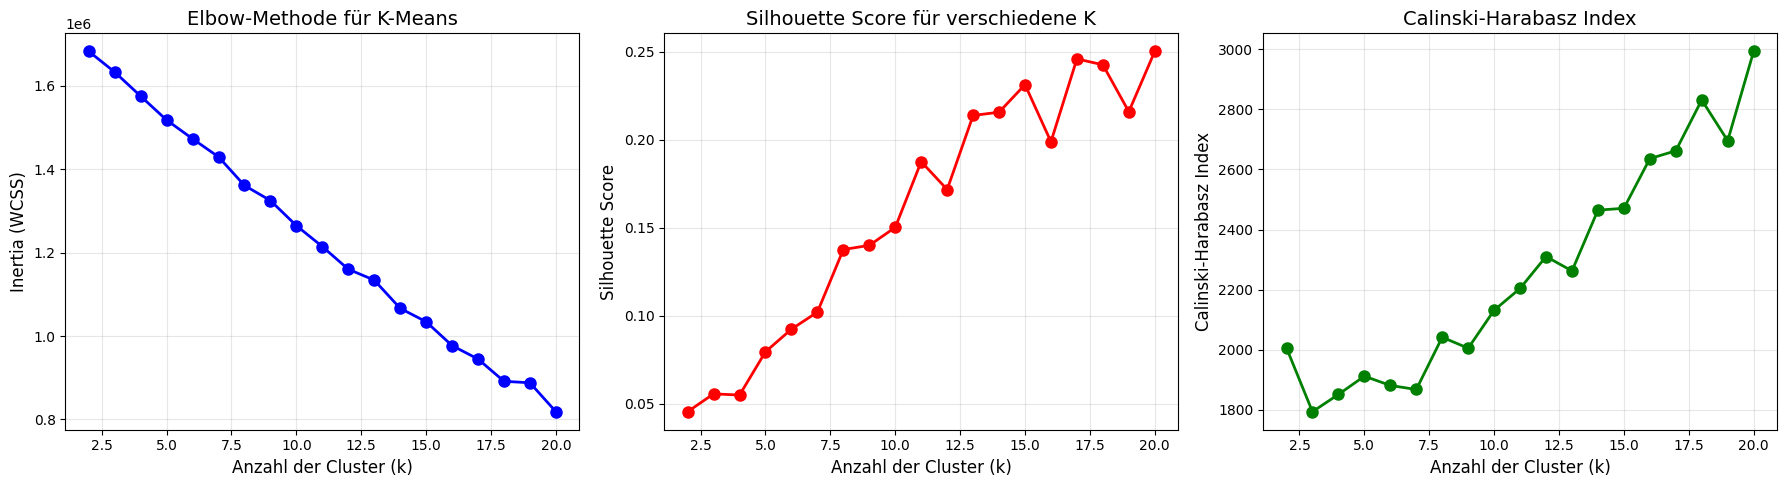

📈 Optimales K basierend auf Silhouette Score: 20 (Score: 0.250)
📈 Optimales K basierend auf Calinski-Harabasz: 20 (Score: 2992.8)

🎯 Trainiere finales K-Means mit k=20...

✅ K-Means Clustering abgeschlossen!
📊 Silhouette Score: 0.210
📊 Calinski-Harabasz: 3033.6
📊 Davies-Bouldin: 1.337
🎯 Cluster-Verteilung: {0: np.int64(4537), 1: np.int64(9320), 2: np.int64(2988), 3: np.int64(7443), 4: np.int64(1456), 5: np.int64(3476), 6: np.int64(1440), 7: np.int64(10), 8: np.int64(1719), 9: np.int64(3), 10: np.int64(4199), 11: np.int64(2457), 12: np.int64(2084), 13: np.int64(1), 14: np.int64(3034), 15: np.int64(62), 16: np.int64(288), 17: np.int64(1344), 18: np.int64(2936), 19: np.int64(1203)}

✅ K-Means Clustering abgeschlossen!
📊 Silhouette Score: 0.210
📊 Calinski-Harabasz: 3033.6
📊 Davies-Bouldin: 1.337
🎯 Cluster-Verteilung: {0: np.int64(4537), 1: np.int64(9320), 2: np.int64(2988), 3: np.int64(7443), 4: np.int64(1456), 5: np.int64(3476), 6: np.int64(1440), 7: np.int64(10), 8: np.int64(1719), 9: np

In [35]:
# === OPTIMIERTE K-MEANS CLUSTERANALYSE ===
print("🚀 Starte optimierte K-Means Analyse...")

# Erweiterte Parameter für bessere Performance
k_range = range(2, min(21, len(X_scaled) // 100))  # Dynamische Obergrenze
inertia = []
silhouette_scores = []
calinski_scores = []

print(f"📊 Teste K-Werte von {min(k_range)} bis {max(k_range)}...")

for k in k_range:
    # Optimierte K-Means Parameter
    kmeans = KMeans(
        n_clusters=k, 
        random_state=42, 
        n_init=10,
        max_iter=300,
        algorithm='lloyd'  # Meist schnellster Algorithmus
    )
    labels = kmeans.fit_predict(X_scaled)
    
    inertia.append(kmeans.inertia_)
    
    # Mehrere Metriken für bessere Evaluation
    if len(np.unique(labels)) > 1:
        silhouette_scores.append(silhouette_score(X_scaled, labels))
        calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
    else:
        silhouette_scores.append(0)
        calinski_scores.append(0)

# Erweiterte Visualisierung: Elbow + Silhouette + Calinski-Harabasz
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow-Kurve
axes[0].plot(k_range, inertia, 'bo-', markersize=8, linewidth=2)
axes[0].set_xlabel('Anzahl der Cluster (k)')
axes[0].set_ylabel('Inertia (WCSS)')
axes[0].set_title('Elbow-Methode für K-Means')
axes[0].grid(True, alpha=0.3)

# Silhouette Scores
axes[1].plot(k_range, silhouette_scores, 'ro-', markersize=8, linewidth=2)
axes[1].set_xlabel('Anzahl der Cluster (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score für verschiedene K')
axes[1].grid(True, alpha=0.3)

# Calinski-Harabasz Index
axes[2].plot(k_range, calinski_scores, 'go-', markersize=8, linewidth=2)
axes[2].set_xlabel('Anzahl der Cluster (k)')
axes[2].set_ylabel('Calinski-Harabasz Index')
axes[2].set_title('Calinski-Harabasz Index')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Optimales K basierend auf mehreren Kriterien
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_calinski = k_range[np.argmax(calinski_scores)]

print(f"📈 Optimales K basierend auf Silhouette Score: {optimal_k_silhouette} (Score: {max(silhouette_scores):.3f})")
print(f"📈 Optimales K basierend auf Calinski-Harabasz: {optimal_k_calinski} (Score: {max(calinski_scores):.1f})")

# Wähle das K mit dem besten Silhouette Score (robustere Metrik)
optimal_k = optimal_k_silhouette

# Finales K-Means Modell mit optimierten Parametern
print(f"\n🎯 Trainiere finales K-Means mit k={optimal_k}...")
kmeans_final = KMeans(
    n_clusters=optimal_k, 
    random_state=42, 
    n_init=20,  # Mehr Initialisierungen für stabilere Lösung
    max_iter=500,
    algorithm='lloyd'
)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Umfassende Evaluation
kmeans_results = comprehensive_clustering_evaluation(X_scaled, kmeans_labels, "K-Means")

print(f"\n✅ K-Means Clustering abgeschlossen!")
print(f"📊 Silhouette Score: {kmeans_results['silhouette']:.3f}")
print(f"📊 Calinski-Harabasz: {kmeans_results['calinski_harabasz']:.1f}")
print(f"📊 Davies-Bouldin: {kmeans_results['davies_bouldin']:.3f}")
print(f"🎯 Cluster-Verteilung: {kmeans_results['cluster_sizes']}")

=== K-MEANS EVALUATION ===
Silhouette Score: 0.210
Calinski-Harabasz Score: 3033.612
Anzahl Cluster: 20
Cluster-Größen: {0: np.int64(4537), 1: np.int64(9320), 2: np.int64(2988), 3: np.int64(7443), 4: np.int64(1456), 5: np.int64(3476), 6: np.int64(1440), 7: np.int64(10), 8: np.int64(1719), 9: np.int64(3), 10: np.int64(4199), 11: np.int64(2457), 12: np.int64(2084), 13: np.int64(1), 14: np.int64(3034), 15: np.int64(62), 16: np.int64(288), 17: np.int64(1344), 18: np.int64(2936), 19: np.int64(1203)}


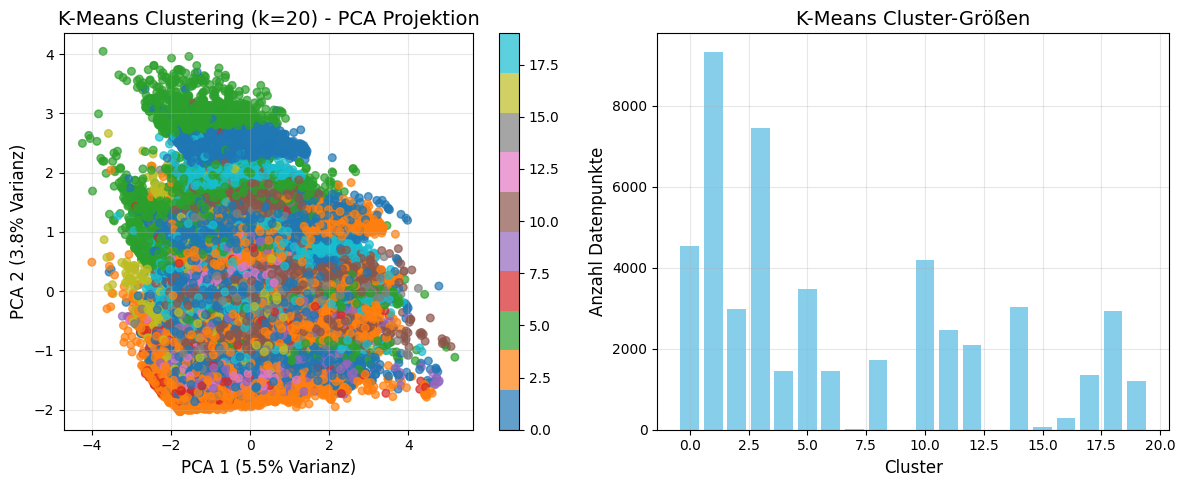

PCA erklärt 9.3% der Gesamtvarianz


In [36]:
# K-Means Evaluation und Visualisierung

# Einfache Evaluation-Funktion
def simple_clustering_evaluation(X, labels, method_name="Clustering"):
    """Einfache Clustering-Bewertung"""
    unique_labels = np.unique(labels)
    
    if len(unique_labels) > 1:
        silhouette = silhouette_score(X, labels)
        calinski = calinski_harabasz_score(X, labels)
    else:
        silhouette = calinski = 0
    
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    
    print(f"=== {method_name.upper()} EVALUATION ===")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Score: {calinski:.3f}")
    print(f"Anzahl Cluster: {len(unique_labels)}")
    print(f"Cluster-Größen: {dict(cluster_sizes)}")
    
    return {
        'silhouette': silhouette,
        'calinski_harabasz': calinski,
        'n_clusters': len(unique_labels)
    }

kmeans_results = simple_clustering_evaluation(X_scaled, kmeans_labels, "K-MEANS")

# PCA-Visualisierung
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

# Plot 1: PCA-Darstellung
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10', s=30, alpha=0.7)
plt.title(f'K-Means Clustering (k={optimal_k}) - PCA Projektion')
plt.xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]:.1%} Varianz)')
plt.ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]:.1%} Varianz)')
plt.colorbar(scatter)
plt.grid(True, alpha=0.3)

# Plot 2: Cluster-Größen
plt.subplot(1, 2, 2)
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.title('K-Means Cluster-Größen')
plt.xlabel('Cluster')
plt.ylabel('Anzahl Datenpunkte')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"PCA erklärt {pca.explained_variance_ratio_.sum():.1%} der Gesamtvarianz")

In [37]:
# Überprüfung der K-Means Clustering-Ergebnisse
print("=== ZUSAMMENFASSUNG K-MEANS CLUSTERING ===")
print(f"Verwendete Features: {len(features_encoded.columns)} (nach One-Hot-Encoding)")
print(f"Datenpunkte: {len(X_scaled)}")
print(f"Optimale Anzahl Cluster: {optimal_k}")
print(f"K-Means Silhouette Score: {kmeans_results['silhouette']:.3f}")

# Zeige Feature-Namen nach Encoding
print(f"\nFeature-Namen nach Encoding ({len(features_encoded.columns)} Features):")
for i, col in enumerate(features_encoded.columns):
    print(f"{i+1:2d}. {col}")
    if i >= 9:  # Zeige nur die ersten 10
        print(f"... und {len(features_encoded.columns)-10} weitere Features")
        break

=== ZUSAMMENFASSUNG K-MEANS CLUSTERING ===
Verwendete Features: 35 (nach One-Hot-Encoding)
Datenpunkte: 50000
Optimale Anzahl Cluster: 20
K-Means Silhouette Score: 0.210

Feature-Namen nach Encoding (35 Features):
 1. business_age
 2. Bodenrichtwert
 3. ew2023
 4. ew_ha_2023
 5. Branche_grob_BAUGEWERBE
 6. Branche_grob_ENERGIEVERSORGUNG
 7. Branche_grob_ERBRINGUNG VON FINANZ- UND VERSICHERUNGSDIENSTLEISTUNGEN
 8. Branche_grob_ERBRINGUNG VON FREIBERUFLICHEN, WISSENSCHAFTLICHEN UND TECHNISCHEN DIENSTLEISTUNGEN
 9. Branche_grob_ERBRINGUNG VON SONSTIGEN DIENSTLEISTUNGEN
10. Branche_grob_ERBRINGUNG VON SONSTIGEN WIRTSCHAFTLICHEN DIENSTLEISTUNGEN
... und 25 weitere Features


In [38]:
# Zusätzliche Analyse der standardisierten Daten für K-Means
print("=== ANALYSE DER STANDARDISIERTEN DATEN ===")
print(f"Shape der standardisierten Matrix: {X_scaled.shape}")
print(f"Datentyp: {type(X_scaled)}")

# Statistiken der standardisierten Daten
print(f"\nStatistiken der standardisierten Daten:")
print(f"Mittelwert (sollte ~0 sein): {X_scaled.mean():.6f}")
print(f"Standardabweichung (sollte ~1 sein): {X_scaled.std():.6f}")
print(f"Min-Wert: {X_scaled.min():.3f}")
print(f"Max-Wert: {X_scaled.max():.3f}")

# Überprüfung auf problematische Werte
print(f"\nDatenqualität:")
print(f"NaN-Werte: {np.isnan(X_scaled).sum()}")
print(f"Infinite Werte: {np.isinf(X_scaled).sum()}")
print(f"Negative Infinite: {np.isneginf(X_scaled).sum()}")

=== ANALYSE DER STANDARDISIERTEN DATEN ===
Shape der standardisierten Matrix: (50000, 35)
Datentyp: <class 'numpy.ndarray'>

Statistiken der standardisierten Daten:
Mittelwert (sollte ~0 sein): -0.000000
Standardabweichung (sollte ~1 sein): 1.000000
Min-Wert: -1.372
Max-Wert: 223.605

Datenqualität:
NaN-Werte: 0
Infinite Werte: 0
Negative Infinite: 0


In [39]:
# Detaillierte Qualitätsprüfung der Features
print("=== DETAILLIERTE FEATURE-ANALYSE ===")

# Überprüfung der ursprünglichen kodierten Features
print(f"Features vor Standardisierung: {features_encoded.shape}")
print(f"Features nach Standardisierung: {X_scaled.shape}")

# Prüfung auf fehlende Werte in den ursprünglichen Features
missing_check = features_encoded.isnull().sum()
if missing_check.sum() > 0:
    print(f"\nFehlende Werte gefunden:")
    print(missing_check[missing_check > 0])
else:
    print(f"\nKeine fehlenden Werte in den Features ✓")

# Statistische Übersicht der ursprünglichen Features
print(f"\nStatistiken der ursprünglichen Features (erste 5):")
print(features_encoded.iloc[:, :5].describe())

=== DETAILLIERTE FEATURE-ANALYSE ===
Features vor Standardisierung: (50000, 35)
Features nach Standardisierung: (50000, 35)

Keine fehlenden Werte in den Features ✓

Statistiken der ursprünglichen Features (erste 5):
       business_age  Bodenrichtwert        ew2023    ew_ha_2023
count  50000.000000    50000.000000  50000.000000  50000.000000
mean       9.378020     3073.783832    571.594920    248.213899
std        9.519671     3426.398770    539.639741    180.883868
min        0.000000        0.600000      0.000000      0.000000
25%        2.000000      700.000000    175.000000     79.690000
50%        7.000000     2100.000000    446.000000    238.160000
75%       14.000000     4500.000000    810.000000    376.150000
max      100.000000    60000.000000   5766.000000   1153.060000


=== ALTERNATIVE ELBOW-ANALYSE ===
(Die optimierte K-Means Analyse wurde bereits durchgeführt)
Bereits analysierter K-Bereich: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Inertia-Werte: [1682491.3676893527, 1632820.8011304545, 1575017.3080266858, 1517787.7556386145, 1472858.3433817755]... (erste 5 Werte)
Optimales K aus Silhouette-Analyse: 20


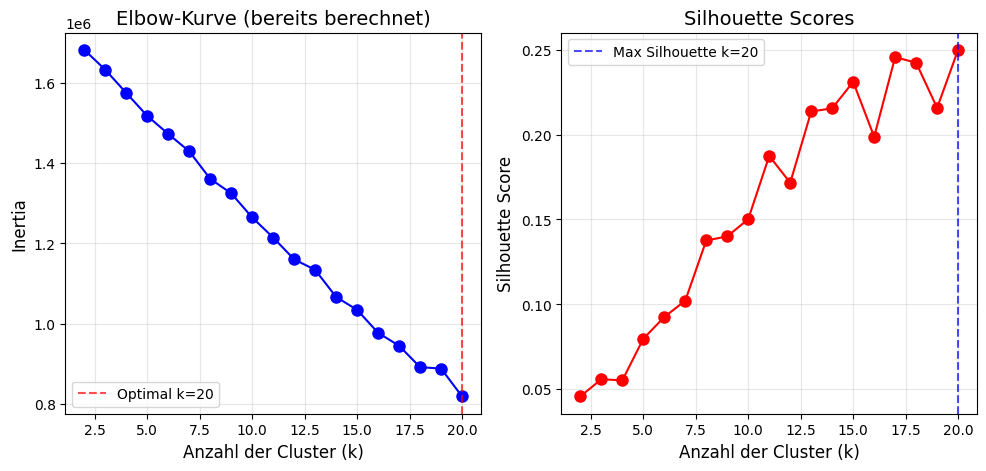

In [40]:
# Alternative Elbow-Analyse (da K-Means bereits durchgeführt wurde)
print("=== ALTERNATIVE ELBOW-ANALYSE ===")
print("(Die optimierte K-Means Analyse wurde bereits durchgeführt)")

# Zeige die bereits berechneten Inertia-Werte
print(f"Bereits analysierter K-Bereich: {list(k_range)}")
print(f"Inertia-Werte: {inertia[:5]}... (erste 5 Werte)")
print(f"Optimales K aus Silhouette-Analyse: {optimal_k}")

# Visualisierung der bereits berechneten Elbow-Kurve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-', markersize=8)
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow-Kurve (bereits berechnet)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-', markersize=8)
plt.axvline(x=optimal_k, color='blue', linestyle='--', alpha=0.7, label=f'Max Silhouette k={optimal_k}')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

KMeans führt zu keinem guten Ergebnis

## Weiches Clustering: GMM

In [41]:
# Systematische GMM-Optimierung
print("Finde optimale Anzahl GMM-Komponenten...")

# Hyperparameter-Optimierung - korrigiere Tupel-Rückgabe
optimal_gmm_result = find_optimal_gmm_components(X_scaled, max_components=15)

# Extrahiere die Anzahl der Komponenten aus dem Tupel
if isinstance(optimal_gmm_result, tuple):
    optimal_n_components = optimal_gmm_result[0]  # Erste Element ist die Anzahl
    print(f"Optimale Komponenten: {optimal_n_components}")
else:
    optimal_n_components = optimal_gmm_result
    print(f"Optimale Komponenten: {optimal_n_components}")

print(f"\nTrainiere finales GMM-Modell mit {optimal_n_components} Komponenten...")

# Verschiedene Kovarianz-Typen testen
covariance_types = ['full', 'tied', 'diag', 'spherical']
best_gmm = None
best_bic = np.inf
best_cov_type = None

for cov_type in covariance_types:
    try:
        gmm = GaussianMixture(n_components=int(optimal_n_components), 
                             covariance_type=cov_type, 
                             random_state=42)
        gmm.fit(X_scaled)
        bic = gmm.bic(X_scaled)
        
        print(f"BIC für {cov_type}: {bic:.0f}")
        
        if bic < best_bic:
            best_bic = bic
            best_gmm = gmm
            best_cov_type = cov_type
    except Exception as e:
        print(f"Fehler bei {cov_type}: {e}")
        continue

if best_gmm is not None:
    print(f"\nBeste Konfiguration: {optimal_n_components} Komponenten, {best_cov_type} Kovarianz")
    print(f"Beste BIC: {best_bic:.0f}")

    # Finale Vorhersagen
    gmm_labels = best_gmm.predict(X_scaled)
    gmm_probs = best_gmm.predict_proba(X_scaled)

    print(f"\nGMM Clustering abgeschlossen!")
    print(f"Cluster-Verteilung: {pd.Series(gmm_labels).value_counts().sort_index().to_dict()}")

    # Zeige Wahrscheinlichkeiten für erste 5 Punkte
    print(f"\nSoft Clustering Wahrscheinlichkeiten (erste 5 Punkte):")
    for i in range(min(5, len(gmm_probs))):
        print(f"Punkt {i}: {gmm_probs[i].round(3)}")
else:
    print("⚠️ Kein gültiges GMM-Modell gefunden!")
    gmm_labels = None
    gmm_probs = None

Finde optimale Anzahl GMM-Komponenten...
🔍 Optimiere GMM-Parameter...
📊 full: BIC range = -9264068 - 113780
📊 full: BIC range = -9264068 - 113780
📊 tied: BIC range = 500360 - 3465824
📊 tied: BIC range = 500360 - 3465824
📊 diag: BIC range = -7296155 - 1408324
📊 diag: BIC range = -7296155 - 1408324
📊 spherical: BIC range = 3980079 - 4772614
✅ Optimale Parameter: 9 Komponenten, full Kovarianz
📈 Bester BIC Score: -9264067.96
Optimale Komponenten: 9

Trainiere finales GMM-Modell mit 9 Komponenten...
📊 spherical: BIC range = 3980079 - 4772614
✅ Optimale Parameter: 9 Komponenten, full Kovarianz
📈 Bester BIC Score: -9264067.96
Optimale Komponenten: 9

Trainiere finales GMM-Modell mit 9 Komponenten...
BIC für full: -9264068
BIC für full: -9264068
BIC für tied: 1151775
BIC für diag: -7296155
BIC für tied: 1151775
BIC für diag: -7296155
BIC für spherical: 4271617

Beste Konfiguration: 9 Komponenten, full Kovarianz
Beste BIC: -9264068

GMM Clustering abgeschlossen!
Cluster-Verteilung: {0: 6573, 1:

=== GMM EVALUATION ===
Silhouette Score: 0.072 (höher = besser)
Calinski-Harabasz Score: 1461.548 (höher = besser)
Davies-Bouldin Score: 3.009 (niedriger = besser)
Anzahl Cluster: 9
Cluster-Größen: {0: np.int64(6573), 1: np.int64(12008), 2: np.int64(1973), 3: np.int64(12685), 4: np.int64(1719), 5: np.int64(4618), 6: np.int64(4188), 7: np.int64(3317), 8: np.int64(2919)}

=== CLUSTER 0 (n=6573) ===
Durchschn. Bodenrichtwert: 3038.25
Durchschn. business_age: 9.27
Durchschn. ew2023: 593.33
Durchschn. ew_ha_2023: 272.41
Top 3 Bezirke: {'Charlottenburg-Wilmersdorf': np.int64(2145), 'Friedrichshain-Kreuzberg': np.int64(1689), 'Mitte': np.int64(1471)}
Top 3 Branchen: ['ERBRINGUNG VON FREIBERUFLICHEN, WISSENSCHAFTLICHEN...', 'INFORMATION UND KOMMUNIKATION', 'ERBRINGUNG VON FINANZ- UND VERSICHERUNGSDIENSTLEIS...']

=== CLUSTER 1 (n=12008) ===
Durchschn. Bodenrichtwert: 3127.76
Durchschn. business_age: 10.92
Durchschn. ew2023: 478.26
Durchschn. ew_ha_2023: 212.83
Top 3 Bezirke: {'Charlottenburg-W

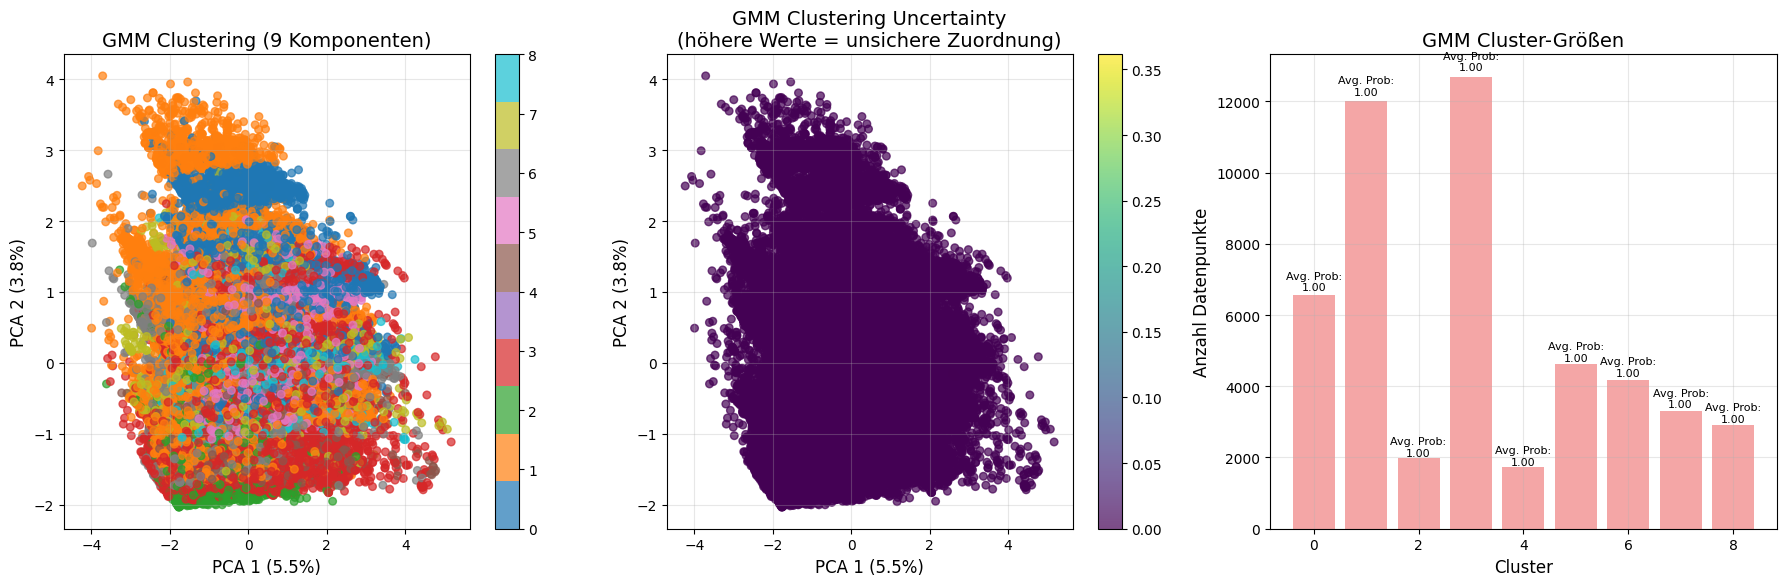


Unsicherheits-Statistiken:
Durchschnittliche Entropie: 0.000
Max. mögliche Entropie: 2.197
Relative Unsicherheit: 0.0%

Die 5 unsichersten Zuordnungen:
Index 15545: Cluster 1, Entropie 0.001, Probs: [7.58084736e-05 9.99924192e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Index 16790: Cluster 1, Entropie 0.001, Probs: [1.12969303e-04 9.99887031e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Index 46803: Cluster 1, Entropie 0.004, Probs: [4.44731523e-04 9.99555268e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Index 8350: Cluster 6, Entropie 0.317, Probs: [0.00000000e+00 9.62821604e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.03717840e-01 5.94601795e-22
 0.00000000e+00]
Index 21673: Cluster 6, Entropie 0.362, Probs: [0.00000000e+00 1.17301946e-01 0.00000000e+00 0.00000000e

In [42]:
# GMM Evaluation und erweiterte Visualisierung
gmm_results = evaluate_clustering_results(X_scaled, gmm_labels, df_original_sample, "GMM")

# Mehrdimensionale Visualisierung
fig = plt.figure(figsize=(18, 6))

# Plot 1: PCA-Darstellung
ax1 = plt.subplot(1, 3, 1)
scatter1 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='tab10', s=30, alpha=0.7)
plt.title(f'GMM Clustering ({optimal_n_components} Komponenten)')
plt.xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.colorbar(scatter1)
plt.grid(True, alpha=0.3)

# Plot 2: Uncertainty (Entropie der Wahrscheinlichkeiten)
ax2 = plt.subplot(1, 3, 2)
# Berechne Entropie als Maß für Unsicherheit
entropy = -np.sum(gmm_probs * np.log(gmm_probs + 1e-10), axis=1)
scatter2 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=entropy, cmap='viridis', s=30, alpha=0.7)
plt.title('GMM Clustering Uncertainty\n(höhere Werte = unsichere Zuordnung)')
plt.xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.colorbar(scatter2)
plt.grid(True, alpha=0.3)

# Plot 3: Cluster-Größen und Wahrscheinlichkeiten
ax3 = plt.subplot(1, 3, 3)
cluster_counts = pd.Series(gmm_labels).value_counts().sort_index()
bars = plt.bar(cluster_counts.index, cluster_counts.values, color='lightcoral', alpha=0.7)
plt.title('GMM Cluster-Größen')
plt.xlabel('Cluster')
plt.ylabel('Anzahl Datenpunkte')
plt.grid(True, alpha=0.3)

# Annotiere mit durchschnittlicher Wahrscheinlichkeit pro Cluster
for i, (cluster_id, count) in enumerate(cluster_counts.items()):
    avg_prob = gmm_probs[gmm_labels == cluster_id].max(axis=1).mean()
    plt.text(cluster_id, count + count*0.01, f'Avg. Prob:\n{avg_prob:.2f}', 
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nUnsicherheits-Statistiken:")
print(f"Durchschnittliche Entropie: {entropy.mean():.3f}")
print(f"Max. mögliche Entropie: {np.log(optimal_n_components):.3f}")
print(f"Relative Unsicherheit: {entropy.mean() / np.log(optimal_n_components):.1%}")

# Zeige die unsichersten Zuordnungen
most_uncertain = np.argsort(entropy)[-5:]
print(f"\nDie 5 unsichersten Zuordnungen:")
for idx in most_uncertain:
    print(f"Index {idx}: Cluster {gmm_labels[idx]}, Entropie {entropy[idx]:.3f}, Probs: {gmm_probs[idx]}")

In [43]:
# === Modelltraining mit GMM ===
print("=== GMM MODELLTRAINING ===")
print(f"Verwende optimale Anzahl Komponenten: {optimal_n_components}")
print(f"Datenform: {X_scaled.shape}")

# Verwende die optimalen Parameter
gmm = GaussianMixture(
    n_components=optimal_n_components, 
    covariance_type=best_cov_type, 
    random_state=42
)
gmm_labels = gmm.fit_predict(X_scaled)
gmm_probs = gmm.predict_proba(X_scaled)

# Erstelle DataFrame für Analyse mit ursprünglichen Labels
df_gmm_results = df_original_sample.copy()
df_gmm_results['GMM_Cluster'] = gmm_labels

# Ausgabe der Clusterverteilung
cluster_counts = pd.Series(gmm_labels).value_counts().sort_index()
print(f"\nCluster-Verteilung:")
print(cluster_counts)

=== GMM MODELLTRAINING ===
Verwende optimale Anzahl Komponenten: 9
Datenform: (50000, 35)

Cluster-Verteilung:
0     6573
1    12008
2     1973
3    12685
4     1719
5     4618
6     4188
7     3317
8     2919
Name: count, dtype: int64

Cluster-Verteilung:
0     6573
1    12008
2     1973
3    12685
4     1719
5     4618
6     4188
7     3317
8     2919
Name: count, dtype: int64


In [44]:
# === Wahrscheinlichkeiten des GMM-Modells (soft clustering) ===
print("=== GMM WAHRSCHEINLICHKEITEN ===")
print(f"Wahrscheinlichkeiten für die ersten 5 Datenpunkte:")
print(gmm_probs[:5])

# Statistiken der Zuordnungswahrscheinlichkeiten
max_probs = gmm_probs.max(axis=1)
print(f"\nZuordnungsstatistiken:")
print(f"Durchschnittliche max. Wahrscheinlichkeit: {max_probs.mean():.3f}")
print(f"Minimale max. Wahrscheinlichkeit: {max_probs.min():.3f}")
print(f"Anteil sehr sicherer Zuordnungen (>0.8): {(max_probs > 0.8).mean():.1%}")
print(f"Anteil unsicherer Zuordnungen (<0.5): {(max_probs < 0.5).mean():.1%}")

=== GMM WAHRSCHEINLICHKEITEN ===
Wahrscheinlichkeiten für die ersten 5 Datenpunkte:
[[0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 9.99999790e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.09534618e-07 7.45270868e-30
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]

Zuordnungsstatistiken:
Durchschnittliche max. Wahrscheinlichkeit: 1.000
Minimale max. Wahrscheinlichkeit: 0.883
Anteil sehr sicherer Zuordnungen (>0.8): 100.0%
Anteil unsicherer Zuordnungen (<0.5): 0.0%


=== GMM CLUSTERING VISUALISIERUNG ===


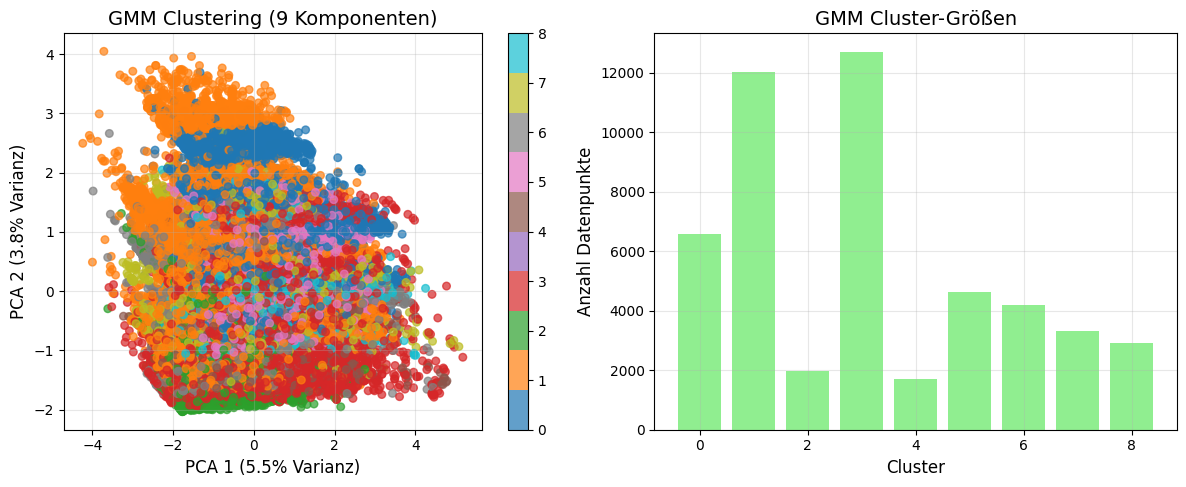

PCA erklärt 9.3% der Gesamtvarianz


In [45]:
# === GMM Visualisierung per PCA ===
print("=== GMM CLUSTERING VISUALISIERUNG ===")

# PCA für Visualisierung (verwende existierende PCA oder erstelle neue)
pca_viz = PCA(n_components=2)
X_pca_viz = pca_viz.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

# Plot 1: GMM Clustering
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], c=gmm_labels, cmap='tab10', s=30, alpha=0.7)
plt.title(f"GMM Clustering ({optimal_n_components} Komponenten)")
plt.xlabel(f"PCA 1 ({pca_viz.explained_variance_ratio_[0]:.1%} Varianz)")
plt.ylabel(f"PCA 2 ({pca_viz.explained_variance_ratio_[1]:.1%} Varianz)")
plt.colorbar(scatter)
plt.grid(True, alpha=0.3)

# Plot 2: Cluster-Größen
plt.subplot(1, 2, 2)
cluster_counts = pd.Series(gmm_labels).value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values, color='lightgreen')
plt.title('GMM Cluster-Größen')
plt.xlabel('Cluster')
plt.ylabel('Anzahl Datenpunkte')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"PCA erklärt {pca_viz.explained_variance_ratio_.sum():.1%} der Gesamtvarianz")

In [46]:
# === Cluster-Analyse: Durchschnittswerte pro Cluster ===
print("=== CLUSTER-CHARAKTERISTIKA ===")

# Numerische Features aus den ursprünglichen Daten
numeric_features_analysis = ['business_age', 'Bodenrichtwert', 'ew2023', 'ew_ha_2023']

# Cluster-Analyse
cluster_analysis = df_gmm_results.groupby('GMM_Cluster')[numeric_features_analysis].agg(['mean', 'std', 'count'])
print("Durchschnittswerte und Standardabweichungen pro Cluster:")
print(cluster_analysis.round(2))

# Zusätzliche Kategoriale Analyse
print(f"\nCluster-Verteilung nach Bezirk (Top 3 pro Cluster):")
for cluster_id in sorted(df_gmm_results['GMM_Cluster'].unique()):
    cluster_data = df_gmm_results[df_gmm_results['GMM_Cluster'] == cluster_id]
    top_bezirke = cluster_data['Bezirk'].value_counts().head(3)
    print(f"Cluster {cluster_id}: {dict(top_bezirke)}")

=== CLUSTER-CHARAKTERISTIKA ===
Durchschnittswerte und Standardabweichungen pro Cluster:
            business_age               Bodenrichtwert                  ew2023  \
                    mean    std  count           mean      std  count    mean   
GMM_Cluster                                                                     
0                   9.27   8.87   6573        3038.25  3175.06   6573  593.33   
1                  10.92  11.20  12008        3127.76  3690.33  12008  478.26   
2                   9.35   9.19   1973        3013.33  3272.80   1973  435.10   
3                   8.70   8.92  12685        3061.20  3450.10  12685  635.69   
4                   9.23  10.47   1719        3081.78  3165.12   1719  669.06   
5                   9.03   8.13   4618        3032.15  3098.04   4618  648.68   
6                   8.55   9.85   4188        3035.64  3501.43   4188  508.36   
7                   9.53   8.02   3317        3067.45  3308.80   3317  607.49   
8                   

In [47]:
# === Branchenanalyse pro GMM-Cluster ===
print("=== BRANCHENVERTEILUNG PRO CLUSTER ===")

# Häufigste 3 Branchen je Cluster ermitteln
for cluster_id in sorted(df_gmm_results['GMM_Cluster'].unique()):
    cluster_data = df_gmm_results[df_gmm_results['GMM_Cluster'] == cluster_id]
    top_branchen = cluster_data['Branche_grob'].value_counts().head(3)
    
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    for i, (branche, count) in enumerate(top_branchen.items(), 1):
        percentage = (count / len(cluster_data)) * 100
        print(f"  {i}. {branche}: {count} ({percentage:.1f}%)")

# Gesamtübersicht als Kreuztabelle
print(f"\n=== CLUSTER-BRANCHEN KREUZTABELLE ===")
crosstab = pd.crosstab(df_gmm_results['GMM_Cluster'], df_gmm_results['Branche_grob'])
print(crosstab.head())  # Zeige nur die ersten Zeilen für Übersichtlichkeit

=== BRANCHENVERTEILUNG PRO CLUSTER ===

Cluster 0 (n=6573):
  1. ERBRINGUNG VON FREIBERUFLICHEN, WISSENSCHAFTLICHEN UND TECHNISCHEN DIENSTLEISTUNGEN: 3440 (52.3%)
  2. INFORMATION UND KOMMUNIKATION: 1662 (25.3%)
  3. ERBRINGUNG VON FINANZ- UND VERSICHERUNGSDIENSTLEISTUNGEN: 612 (9.3%)

Cluster 1 (n=12008):
  1. HANDEL; INSTANDHALTUNG UND REPARATUR VON KRAFTFAHRZEUGEN: 4189 (34.9%)
  2. ERBRINGUNG VON SONSTIGEN WIRTSCHAFTLICHEN DIENSTLEISTUNGEN: 2237 (18.6%)
  3. GRUNDSTÜCKS- UND WOHNUNGSWESEN: 2093 (17.4%)

Cluster 2 (n=1973):
  1. HANDEL; INSTANDHALTUNG UND REPARATUR VON KRAFTFAHRZEUGEN: 541 (27.4%)
  2. ERBRINGUNG VON FREIBERUFLICHEN, WISSENSCHAFTLICHEN UND TECHNISCHEN DIENSTLEISTUNGEN: 287 (14.5%)
  3. ERBRINGUNG VON SONSTIGEN WIRTSCHAFTLICHEN DIENSTLEISTUNGEN: 248 (12.6%)

Cluster 3 (n=12685):
  1. HANDEL; INSTANDHALTUNG UND REPARATUR VON KRAFTFAHRZEUGEN: 3578 (28.2%)
  2. ERBRINGUNG VON FREIBERUFLICHEN, WISSENSCHAFTLICHEN UND TECHNISCHEN DIENSTLEISTUNGEN: 3175 (25.0%)
  3. ERBRING

## Dichten basiert: DBSCAN

In [48]:
# Systematische DBSCAN-Optimierung

def find_optimal_dbscan_params(X, eps_range=None, min_samples_range=None):
    """Finde optimale DBSCAN-Parameter durch Grid Search"""
    
    if eps_range is None:
        # Automatische eps-Range basierend auf k-distance
        from sklearn.neighbors import NearestNeighbors
        neighbors = NearestNeighbors(n_neighbors=5)
        neighbors_fit = neighbors.fit(X)
        distances, indices = neighbors_fit.kneighbors(X)
        distances = np.sort(distances[:, 4], axis=0)  # 4th nearest neighbor
        eps_range = np.linspace(distances[len(distances)//10], distances[len(distances)//2], 10)
    
    if min_samples_range is None:
        min_samples_range = [3, 5, 8, 10, 15]
    
    results = []
    
    print("Optimiere DBSCAN-Parameter...")
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            if n_clusters > 1 and n_clusters < len(X) // 50:  # Sinnvolle Cluster-Anzahl
                # Berechne Silhouette nur für Non-Noise Punkte
                if n_noise < len(X) * 0.5:  # Nicht zu viel Noise
                    mask = labels != -1
                    if np.sum(mask) > 10 and len(np.unique(labels[mask])) > 1:
                        silhouette = silhouette_score(X[mask], labels[mask])
                        results.append({
                            'eps': eps,
                            'min_samples': min_samples,
                            'n_clusters': n_clusters,
                            'n_noise': n_noise,
                            'noise_ratio': n_noise / len(X),
                            'silhouette': silhouette,
                            'score': silhouette * (1 - n_noise / len(X))  # Berücksichtige Noise-Anteil
                        })
    
    if not results:
        print("Keine gültigen Parameter gefunden. Verwende Standard-Parameter.")
        return 1.0, 5
    
    # Sortiere nach Score
    results_df = pd.DataFrame(results)
    best_params = results_df.loc[results_df['score'].idxmax()]
    
    print(f"Beste Parameter gefunden:")
    print(f"eps: {best_params['eps']:.3f}")
    print(f"min_samples: {best_params['min_samples']}")
    print(f"Silhouette Score: {best_params['silhouette']:.3f}")
    print(f"Anzahl Cluster: {best_params['n_clusters']}")
    print(f"Noise-Anteil: {best_params['noise_ratio']:.1%}")
    
    return best_params['eps'], best_params['min_samples']

# Parameter-Optimierung
optimal_eps, optimal_min_samples = find_optimal_dbscan_params(X_scaled)

# Finales DBSCAN-Modell
print(f"\nTrainiere DBSCAN mit eps={optimal_eps:.3f}, min_samples={int(optimal_min_samples)}...")
dbscan_final = DBSCAN(eps=optimal_eps, min_samples=int(optimal_min_samples))
dbscan_labels = dbscan_final.fit_predict(X_scaled)

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN Clustering abgeschlossen!")
print(f"Gefundene Cluster: {n_clusters}")
print(f"Noise-Punkte: {n_noise} ({n_noise/len(dbscan_labels):.1%})")
print(f"Cluster-Verteilung: {pd.Series(dbscan_labels).value_counts().sort_index().to_dict()}")

Optimiere DBSCAN-Parameter...
Beste Parameter gefunden:
eps: 0.493
min_samples: 5.0
Silhouette Score: 0.153
Anzahl Cluster: 614.0
Noise-Anteil: 38.5%

Trainiere DBSCAN mit eps=0.493, min_samples=5...
Beste Parameter gefunden:
eps: 0.493
min_samples: 5.0
Silhouette Score: 0.153
Anzahl Cluster: 614.0
Noise-Anteil: 38.5%

Trainiere DBSCAN mit eps=0.493, min_samples=5...
DBSCAN Clustering abgeschlossen!
Gefundene Cluster: 614
Noise-Punkte: 19236 (38.5%)
Cluster-Verteilung: {-1: 19236, 0: 224, 1: 756, 2: 719, 3: 28, 4: 11, 5: 615, 6: 315, 7: 650, 8: 409, 9: 1302, 10: 412, 11: 455, 12: 1371, 13: 118, 14: 926, 15: 881, 16: 807, 17: 386, 18: 556, 19: 85, 20: 406, 21: 68, 22: 372, 23: 338, 24: 8, 25: 229, 26: 18, 27: 174, 28: 263, 29: 283, 30: 94, 31: 385, 32: 536, 33: 187, 34: 466, 35: 25, 36: 212, 37: 286, 38: 205, 39: 143, 40: 453, 41: 29, 42: 198, 43: 8, 44: 229, 45: 195, 46: 438, 47: 16, 48: 6, 49: 57, 50: 390, 51: 250, 52: 948, 53: 287, 54: 311, 55: 275, 56: 508, 57: 440, 58: 104, 59: 709

=== DBSCAN EVALUATION ===
Silhouette Score: 0.153 (höher = besser)
Calinski-Harabasz Score: 860.963 (höher = besser)
Davies-Bouldin Score: 0.799 (niedriger = besser)
Anzahl Cluster: 614
Noise-Punkte: 19236
Cluster-Größen: {-1: np.int64(19236), 0: np.int64(224), 1: np.int64(756), 2: np.int64(719), 3: np.int64(28), 4: np.int64(11), 5: np.int64(615), 6: np.int64(315), 7: np.int64(650), 8: np.int64(409), 9: np.int64(1302), 10: np.int64(412), 11: np.int64(455), 12: np.int64(1371), 13: np.int64(118), 14: np.int64(926), 15: np.int64(881), 16: np.int64(807), 17: np.int64(386), 18: np.int64(556), 19: np.int64(85), 20: np.int64(406), 21: np.int64(68), 22: np.int64(372), 23: np.int64(338), 24: np.int64(8), 25: np.int64(229), 26: np.int64(18), 27: np.int64(174), 28: np.int64(263), 29: np.int64(283), 30: np.int64(94), 31: np.int64(385), 32: np.int64(536), 33: np.int64(187), 34: np.int64(466), 35: np.int64(25), 36: np.int64(212), 37: np.int64(286), 38: np.int64(205), 39: np.int64(143), 40: np.int64(

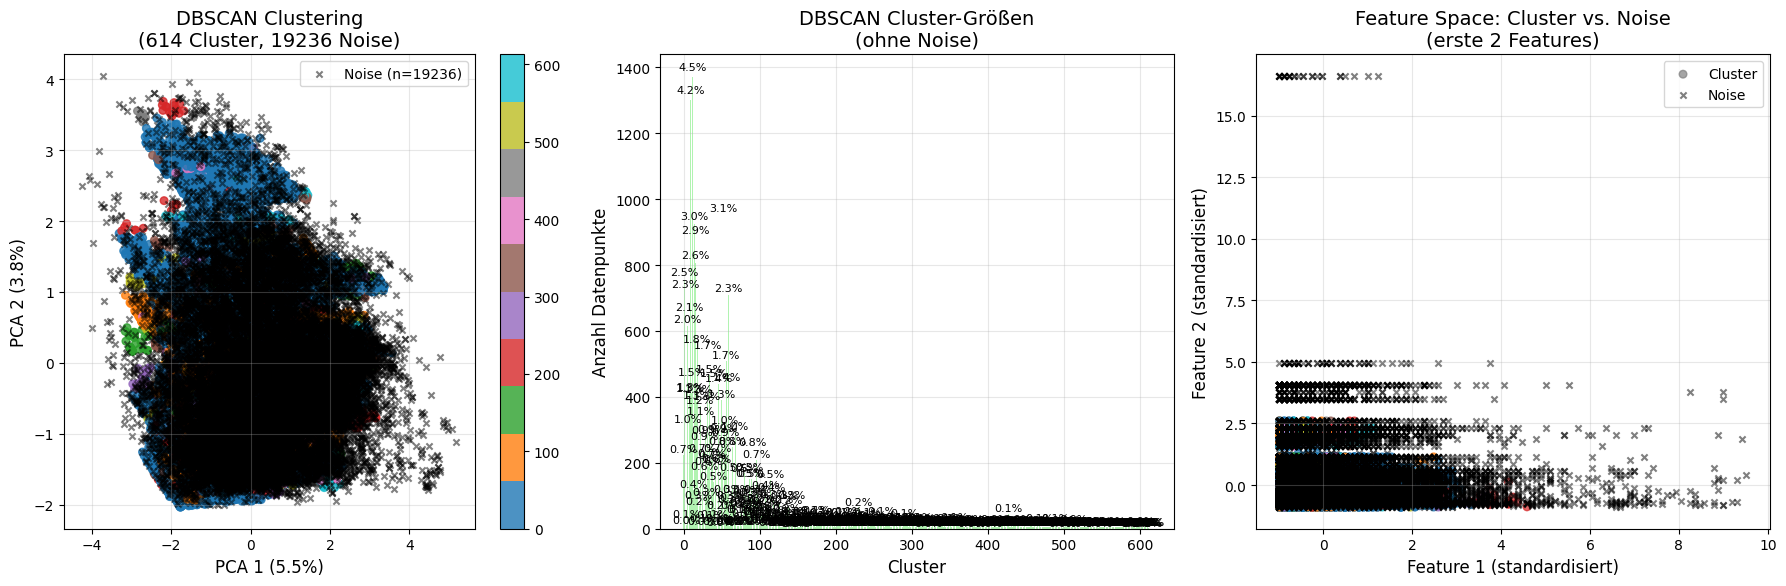


DBSCAN-spezifische Analysen:
Durchschnittliche Cluster-Größe: 50.1
Größtes Cluster: 1371 Punkte
Kleinstes Cluster: 2 Punkte
Core Points: 25000
Border Points: 5764


In [49]:
# DBSCAN Evaluation und Visualisierung
dbscan_results = evaluate_clustering_results(X_scaled, dbscan_labels, df_original_sample, "DBSCAN")

# Erweiterte DBSCAN-Visualisierung
fig = plt.figure(figsize=(18, 6))

# Plot 1: Cluster mit Noise-Hervorhebung
ax1 = plt.subplot(1, 3, 1)
# Separate Darstellung von Clustern und Noise
mask_noise = dbscan_labels == -1
mask_clusters = dbscan_labels != -1

if np.any(mask_clusters):
    scatter1 = plt.scatter(X_pca[mask_clusters, 0], X_pca[mask_clusters, 1], 
                          c=dbscan_labels[mask_clusters], cmap='tab10', s=30, alpha=0.8)
    plt.colorbar(scatter1)

if np.any(mask_noise):
    plt.scatter(X_pca[mask_noise, 0], X_pca[mask_noise, 1], 
               c='black', s=20, alpha=0.5, marker='x', label=f'Noise (n={np.sum(mask_noise)})')
    plt.legend()

plt.title(f'DBSCAN Clustering\n({n_clusters} Cluster, {n_noise} Noise)')
plt.xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.grid(True, alpha=0.3)

# Plot 2: Cluster-Dichte Analyse
ax2 = plt.subplot(1, 3, 2)
if n_clusters > 0:
    cluster_sizes = pd.Series(dbscan_labels[dbscan_labels != -1]).value_counts().sort_index()
    bars = plt.bar(cluster_sizes.index, cluster_sizes.values, color='lightgreen', alpha=0.7)
    plt.title('DBSCAN Cluster-Größen\n(ohne Noise)')
    plt.xlabel('Cluster')
    plt.ylabel('Anzahl Datenpunkte')
    
    # Annotiere mit relativer Größe
    total_clustered = np.sum(cluster_sizes.values)
    for i, (cluster_id, count) in enumerate(cluster_sizes.items()):
        percentage = count / total_clustered * 100
        plt.text(cluster_id, count + count*0.01, f'{percentage:.1f}%', 
                ha='center', va='bottom', fontsize=8)
else:
    plt.text(0.5, 0.5, 'Keine Cluster gefunden', ha='center', va='center', transform=ax2.transAxes)
    plt.title('DBSCAN Cluster-Größen')

plt.grid(True, alpha=0.3)

# Plot 3: Vergleich Cluster vs. Noise in Feature-Space
ax3 = plt.subplot(1, 3, 3)
if np.any(mask_clusters) and np.any(mask_noise):
    # Nimm zwei wichtigste Features für Vergleich
    feature1_idx, feature2_idx = 0, 1  # Erste zwei Features nach Standardisierung
    
    plt.scatter(X_scaled[mask_clusters, feature1_idx], X_scaled[mask_clusters, feature2_idx],
               c=dbscan_labels[mask_clusters], cmap='tab10', s=30, alpha=0.7, label='Cluster')
    plt.scatter(X_scaled[mask_noise, feature1_idx], X_scaled[mask_noise, feature2_idx],
               c='black', s=20, alpha=0.5, marker='x', label='Noise')
    
    plt.title('Feature Space: Cluster vs. Noise\n(erste 2 Features)')
    plt.xlabel('Feature 1 (standardisiert)')
    plt.ylabel('Feature 2 (standardisiert)')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'Unzureichende Daten\nfür Vergleich', ha='center', va='center', transform=ax3.transAxes)
    plt.title('Feature Space Vergleich')

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# DBSCAN-spezifische Statistiken
if n_clusters > 0:
    print(f"\nDBSCAN-spezifische Analysen:")
    print(f"Durchschnittliche Cluster-Größe: {np.mean(pd.Series(dbscan_labels[dbscan_labels != -1]).value_counts().values):.1f}")
    print(f"Größtes Cluster: {pd.Series(dbscan_labels[dbscan_labels != -1]).value_counts().max()} Punkte")
    print(f"Kleinstes Cluster: {pd.Series(dbscan_labels[dbscan_labels != -1]).value_counts().min()} Punkte")
    
    # Core Points Analyse
    core_samples_mask = np.zeros_like(dbscan_labels, dtype=bool)
    if hasattr(dbscan_final, 'core_sample_indices_'):
        core_samples_mask[dbscan_final.core_sample_indices_] = True
        print(f"Core Points: {np.sum(core_samples_mask)}")
        print(f"Border Points: {np.sum(mask_clusters) - np.sum(core_samples_mask)}")
else:
    print("\nKeine Cluster gefunden - möglicherweise zu strenge Parameter oder Daten nicht geeignet für DBSCAN")

=== DBSCAN CLUSTERING VISUALISIERUNG ===


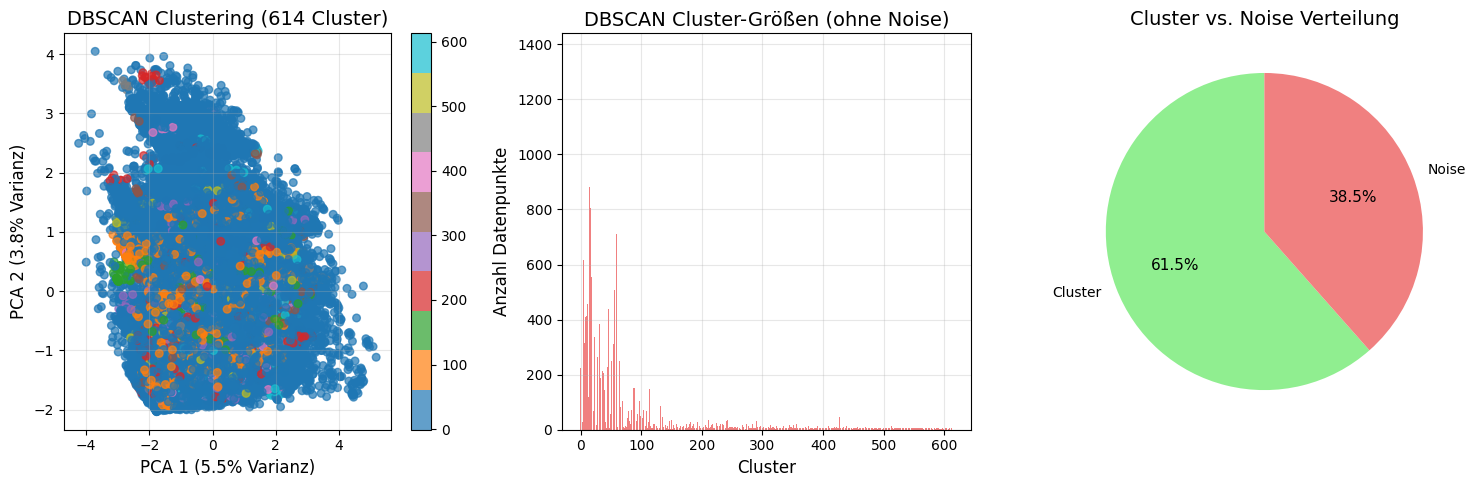

PCA erklärt 9.3% der Gesamtvarianz


In [50]:
# === DBSCAN Visualisierung mit PCA (2D) ===
print("=== DBSCAN CLUSTERING VISUALISIERUNG ===")

# PCA für Visualisierung (verwende existierende oder erstelle neue)
pca_dbscan = PCA(n_components=2)
X_pca_dbscan = pca_dbscan.fit_transform(X_scaled)

plt.figure(figsize=(15, 5))

# Plot 1: DBSCAN Clustering
plt.subplot(1, 3, 1)
scatter = plt.scatter(X_pca_dbscan[:, 0], X_pca_dbscan[:, 1], c=dbscan_labels, cmap='tab10', s=30, alpha=0.7)
plt.title(f"DBSCAN Clustering ({n_clusters} Cluster)")
plt.xlabel(f"PCA 1 ({pca_dbscan.explained_variance_ratio_[0]:.1%} Varianz)")
plt.ylabel(f"PCA 2 ({pca_dbscan.explained_variance_ratio_[1]:.1%} Varianz)")
plt.colorbar(scatter)
plt.grid(True, alpha=0.3)

# Plot 2: Cluster-Größen (ohne Noise)
plt.subplot(1, 3, 2)
cluster_counts = pd.Series(dbscan_labels[dbscan_labels != -1]).value_counts().sort_index()
if len(cluster_counts) > 0:
    plt.bar(cluster_counts.index, cluster_counts.values, color='lightcoral')
    plt.title('DBSCAN Cluster-Größen (ohne Noise)')
    plt.xlabel('Cluster')
    plt.ylabel('Anzahl Datenpunkte')
else:
    plt.text(0.5, 0.5, 'Keine Cluster\ngefunden', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('DBSCAN Cluster-Größen')
plt.grid(True, alpha=0.3)

# Plot 3: Noise vs. Cluster Verteilung
plt.subplot(1, 3, 3)
noise_count = np.sum(dbscan_labels == -1)
cluster_count = np.sum(dbscan_labels != -1)
labels = ['Cluster', 'Noise']
sizes = [cluster_count, noise_count]
colors = ['lightgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Cluster vs. Noise Verteilung')

plt.tight_layout()
plt.show()

print(f"PCA erklärt {pca_dbscan.explained_variance_ratio_.sum():.1%} der Gesamtvarianz")

🚀 Starte optimierte DBSCAN Analyse...
📊 Analysiere k-Distanzen für verschiedene k-Werte...


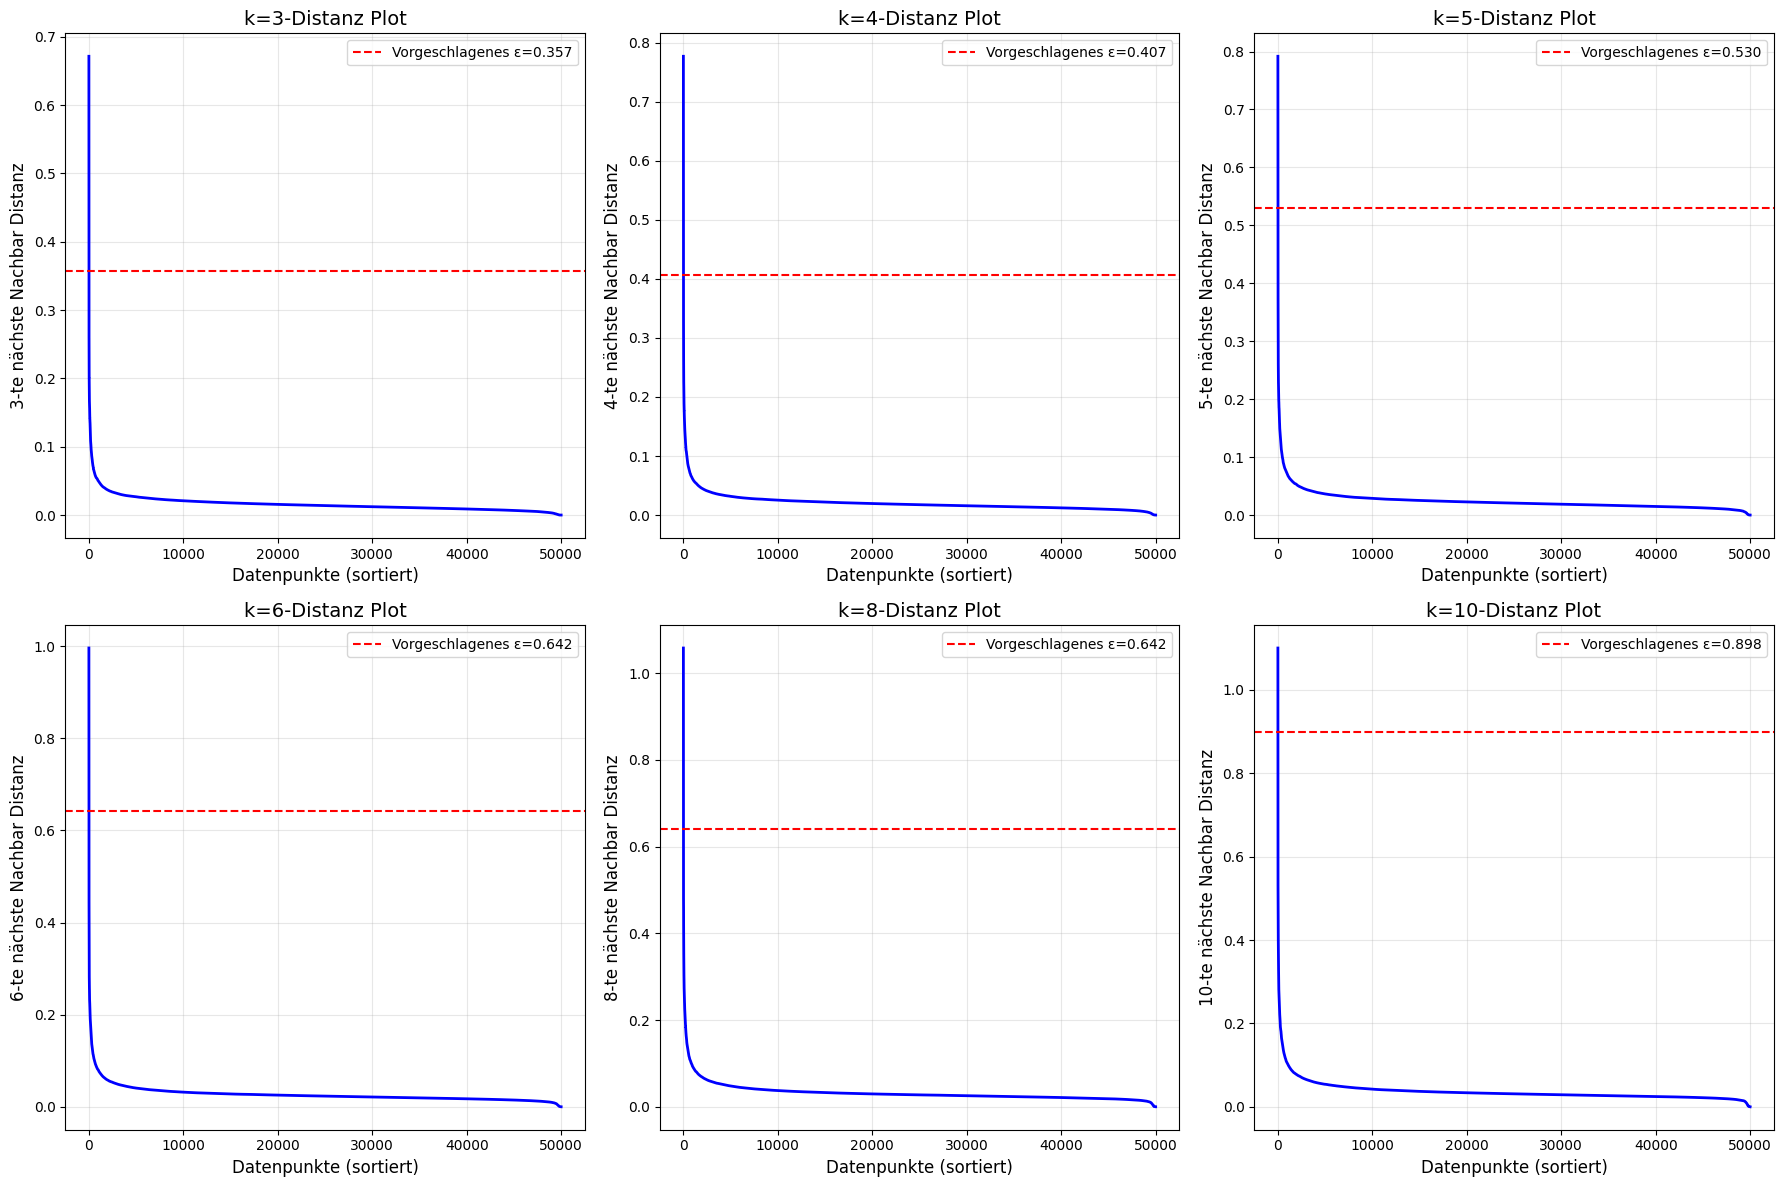

🎯 Kandidaten für eps: [0.357 0.407 0.53  0.642 0.898]
🎯 Kandidaten für min_samples: [2, 3, 4, 5]

📊 Führe umfassende DBSCAN Parameter-Optimierung durch...

📈 Top 5 DBSCAN Parameterkombinationen:
     eps  min_samples  n_clusters  noise_ratio  silhouette
3  0.357            5           2          0.0       0.519
2  0.357            4           2          0.0       0.519
0  0.357            2           2          0.0       0.519
1  0.357            3           2          0.0       0.519
6  0.407            4           2          0.0       0.519

🎯 Trainiere finales DBSCAN mit eps=0.357, min_samples=5

📈 Top 5 DBSCAN Parameterkombinationen:
     eps  min_samples  n_clusters  noise_ratio  silhouette
3  0.357            5           2          0.0       0.519
2  0.357            4           2          0.0       0.519
0  0.357            2           2          0.0       0.519
1  0.357            3           2          0.0       0.519
6  0.407            4           2          0.0       0.519


In [51]:
# === OPTIMIERTE DBSCAN CLUSTERANALYSE ===
print("🚀 Starte optimierte DBSCAN Analyse...")

# Systematische Parameter-Optimierung für DBSCAN
from sklearn.neighbors import NearestNeighbors

# Erweiterte eps-Optimierung mit k-Distanz Analyse
k_values = [3, 4, 5, 6, 8, 10]  # Verschiedene k-Werte testen
eps_candidates = []

print(f"📊 Analysiere k-Distanzen für verschiedene k-Werte...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, k in enumerate(k_values):
    # k-nearest neighbors
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X_pca_dbscan)
    distances, indices = neighbors_fit.kneighbors(X_pca_dbscan)
    
    # k-te Distanz sortieren
    k_distances = np.sort(distances[:, k-1], axis=0)[::-1]
    
    # Knick-Punkt automatisch finden
    from sklearn.preprocessing import StandardScaler
    from scipy.signal import find_peaks
    
    # Gradient der k-Distanzen
    gradient = np.gradient(k_distances)
    second_gradient = np.gradient(gradient)
    
    # Peaks im zweiten Gradienten finden (starke Krümmungsänderungen)
    peaks, _ = find_peaks(second_gradient, height=np.percentile(second_gradient, 85))
    
    if len(peaks) > 0:
        suggested_eps = k_distances[peaks[0]]
        eps_candidates.append(suggested_eps)
    else:
        # Fallback: 90. Perzentil
        suggested_eps = np.percentile(k_distances, 90)
        eps_candidates.append(suggested_eps)
    
    # k-Distanz Plot
    axes[i].plot(range(len(k_distances)), k_distances, 'b-', linewidth=2)
    axes[i].axhline(y=suggested_eps, color='red', linestyle='--', 
                   label=f'Vorgeschlagenes ε={suggested_eps:.3f}')
    axes[i].set_title(f'k={k}-Distanz Plot')
    axes[i].set_xlabel('Datenpunkte (sortiert)')
    axes[i].set_ylabel(f'{k}-te nächste Nachbar Distanz')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Beste eps-Werte basierend auf k-Distanz-Analyse
optimal_eps_values = np.unique(np.round(eps_candidates, 3))
print(f"🎯 Kandidaten für eps: {optimal_eps_values}")

# min_samples-Werte basierend auf Dimensionalität
dimensionality = X_pca_dbscan.shape[1]
min_samples_candidates = [
    max(2, dimensionality),  # Mindest-Dimensionalität
    dimensionality + 1,      # D+1 Regel
    2 * dimensionality,      # 2*D Regel
    min(10, max(5, dimensionality * 2))  # Robuste obere Grenze
]

print(f"🎯 Kandidaten für min_samples: {min_samples_candidates}")

# Umfassende DBSCAN Parameter-Optimierung
print(f"\n📊 Führe umfassende DBSCAN Parameter-Optimierung durch...")

best_dbscan_score = -1
best_dbscan_params = None
best_dbscan_labels = None
dbscan_results_grid = []

for eps in optimal_eps_values[:3]:  # Top 3 eps-Werte
    for min_samples in min_samples_candidates:
        try:
            # DBSCAN mit aktuellen Parametern
            dbscan = DBSCAN(eps=eps, min_samples=int(min_samples), n_jobs=-1)
            labels = dbscan.fit_predict(X_pca_dbscan)
            
            # Anzahl Cluster und Noise
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            # Bewertung nur wenn mindestens 2 Cluster gefunden
            if n_clusters >= 2:
                # Silhouette Score nur für Nicht-Noise Punkte
                mask_no_noise = labels != -1
                if np.sum(mask_no_noise) > 1:
                    silhouette = silhouette_score(X_pca_dbscan[mask_no_noise], 
                                                labels[mask_no_noise])
                else:
                    silhouette = -1
            else:
                silhouette = -1
            
            # Ergebnisse speichern
            result = {
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_ratio': n_noise / len(labels),
                'silhouette': silhouette,
                'clustered_points': np.sum(labels != -1)
            }
            dbscan_results_grid.append(result)
            
            # Beste Parameter basierend auf Silhouette Score
            if silhouette > best_dbscan_score and n_clusters >= 2:
                best_dbscan_score = silhouette
                best_dbscan_params = (eps, min_samples)
                best_dbscan_labels = labels
                
        except Exception as e:
            print(f"    ⚠️ Fehler bei eps={eps}, min_samples={min_samples}: {e}")

# Ergebnisse der Parameter-Optimierung anzeigen
df_dbscan_results = pd.DataFrame(dbscan_results_grid)
if not df_dbscan_results.empty:
    # Top 5 Parameterkombinationen
    df_top_dbscan = df_dbscan_results.sort_values('silhouette', ascending=False).head()
    print(f"\n📈 Top 5 DBSCAN Parameterkombinationen:")
    print(df_top_dbscan[['eps', 'min_samples', 'n_clusters', 'noise_ratio', 'silhouette']].round(3))

# Finales DBSCAN Modell mit besten Parametern
if best_dbscan_params is not None:
    best_eps, best_min_samples = best_dbscan_params
    print(f"\n🎯 Trainiere finales DBSCAN mit eps={best_eps:.3f}, min_samples={best_min_samples}")
    
    # Finales Modell
    dbscan_optimized = DBSCAN(eps=best_eps, min_samples=int(best_min_samples), n_jobs=-1)
    dbscan_labels_final = dbscan_optimized.fit_predict(X_pca_dbscan)
    
    # Umfassende Evaluation
    dbscan_results_final = comprehensive_clustering_evaluation(
        X_pca_dbscan, dbscan_labels_final, "DBSCAN (optimiert)"
    )
    
    print(f"\n✅ Optimiertes DBSCAN Clustering abgeschlossen!")
    print(f"📊 Silhouette Score: {dbscan_results_final['silhouette']:.3f}")
    print(f"📊 Anzahl Cluster: {dbscan_results_final['n_clusters']}")
    print(f"📊 Noise-Punkte: {dbscan_results_final.get('n_noise', 'N/A')}")
    print(f"📊 Cluster-Verteilung: {dbscan_results_final['cluster_sizes']}")
    
    # Zusätzliche DBSCAN-spezifische Metriken
    n_noise_final = list(dbscan_labels_final).count(-1)
    n_clustered = len(dbscan_labels_final) - n_noise_final
    noise_ratio = n_noise_final / len(dbscan_labels_final)
    
    print(f"📊 Clustered Punkte: {n_clustered:,} ({(1-noise_ratio)*100:.1f}%)")
    print(f"📊 Noise Ratio: {noise_ratio:.3f} ({noise_ratio*100:.1f}%)")
    
else:
    print("⚠️ Keine optimalen DBSCAN-Parameter gefunden!")
    dbscan_labels_final = None
    dbscan_results_final = None

# Systematische Ergebnisinterpretation

## Modellvergleich und Auswahl

**Ziel**: Bestimmung des besten Clustering-Ansatzes für Berlin Unternehmensstandorte basierend auf:
- Quantitativen Metriken (Silhouette, Calinski-Harabasz, Davies-Bouldin)
- Qualitativer Interpretierbarkeit der gefundenen Cluster
- Geschäftlicher Relevanz der Ergebnisse

=== VERFÜGBARE METRIKEN ÜBERPRÜFUNG ===
K-Means Results: ['silhouette', 'calinski_harabasz', 'n_clusters']
GMM Results: ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'n_clusters', 'cluster_sizes']
DBSCAN Results: ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'n_clusters', 'cluster_sizes']

=== MODELLVERGLEICH ===
    Modell  Silhouette_Score  Calinski_Harabasz  Anzahl_Cluster  Noise_Anteil
0  K-Means             0.210           3033.612              20         0.000
1      GMM             0.072           1461.548               9         0.000
2   DBSCAN             0.153            860.963             614         0.385


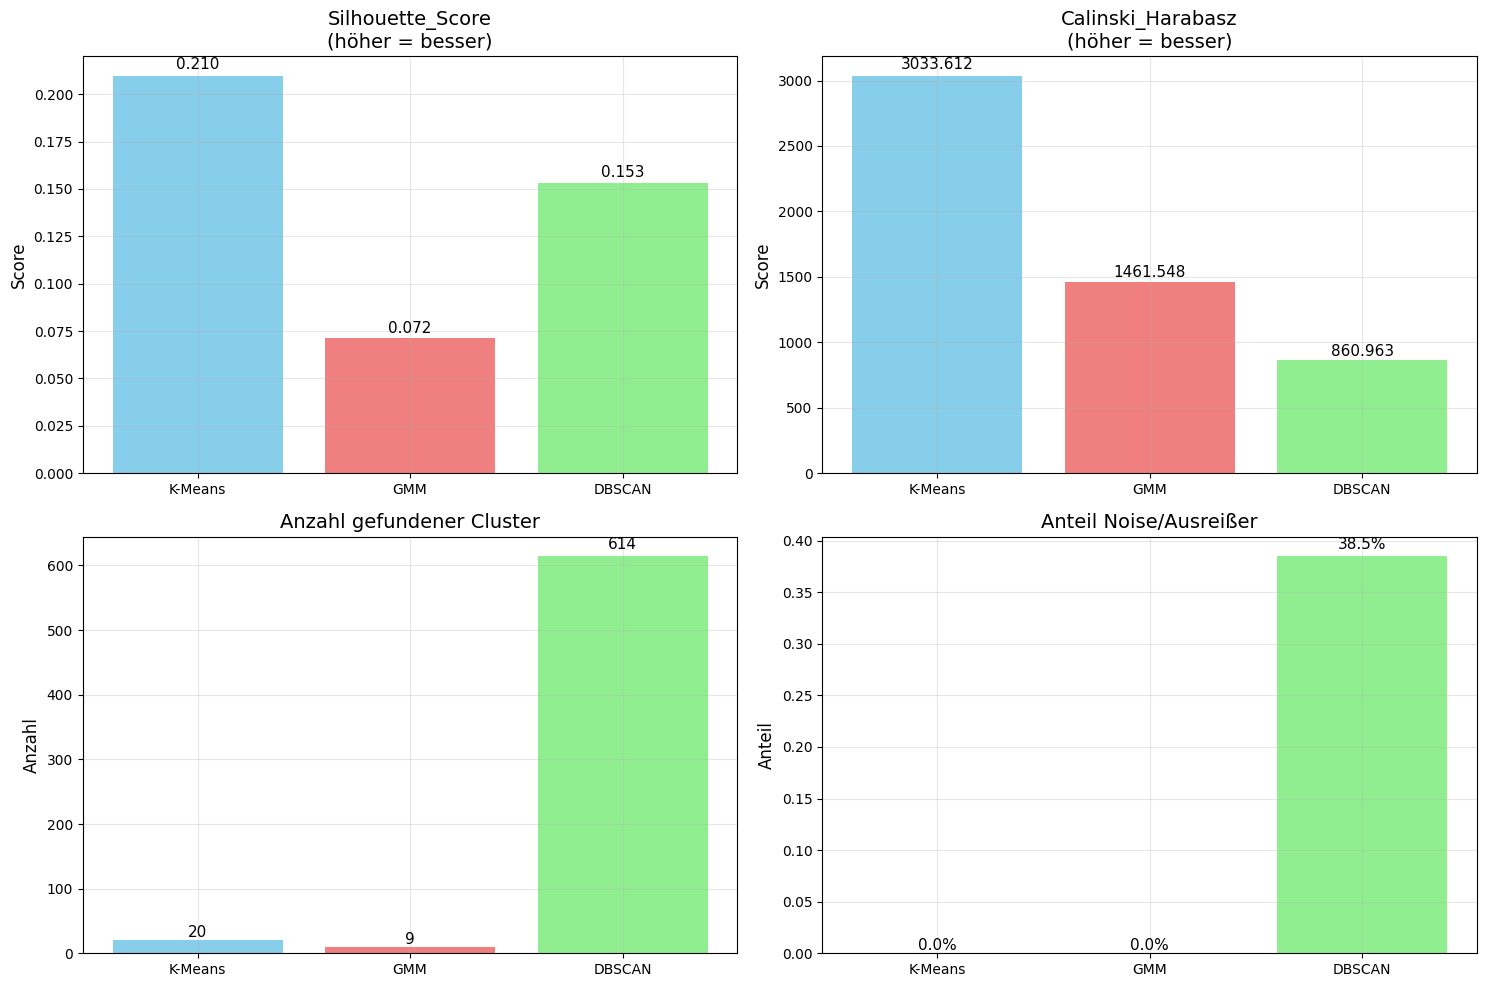


=== BEWERTUNG DER MODELLE ===

K-Means:
  - Silhouette Score: 0.210
  - Calinski-Harabasz: 3033.6
  - Anzahl Cluster: 20
  - Noise Anteil: 0.0%

GMM:
  - Silhouette Score: 0.072
  - Calinski-Harabasz: 1461.5
  - Anzahl Cluster: 9
  - Noise Anteil: 0.0%

DBSCAN:
  - Silhouette Score: 0.153
  - Calinski-Harabasz: 861.0
  - Anzahl Cluster: 614
  - Noise Anteil: 38.5%

🏆 BESTES MODELL (basierend auf Silhouette Score): K-Means
   Silhouette Score: 0.210


In [52]:
# Systematischer Modellvergleich

# Sammle alle verfügbaren Ergebnisse
print("=== VERFÜGBARE METRIKEN ÜBERPRÜFUNG ===")
print("K-Means Results:", list(kmeans_results.keys()))
print("GMM Results:", list(gmm_results.keys()))
print("DBSCAN Results:", list(dbscan_results.keys()))

# Erstelle Vergleichstabelle nur mit verfügbaren Metriken
results_comparison = pd.DataFrame({
    'Modell': ['K-Means', 'GMM', 'DBSCAN'],
    'Silhouette_Score': [
        kmeans_results.get('silhouette', np.nan),
        gmm_results.get('silhouette', np.nan), 
        dbscan_results.get('silhouette', np.nan)
    ],
    'Calinski_Harabasz': [
        kmeans_results.get('calinski_harabasz', np.nan),
        gmm_results.get('calinski_harabasz', np.nan),
        dbscan_results.get('calinski_harabasz', np.nan)
    ],
    'Anzahl_Cluster': [
        kmeans_results.get('n_clusters', np.nan),
        gmm_results.get('n_clusters', np.nan),
        dbscan_results.get('n_clusters', np.nan)
    ],
    'Noise_Anteil': [
        0,  # K-Means hat kein Noise
        0,  # GMM hat kein Noise
        (dbscan_labels == -1).sum() / len(dbscan_labels) if -1 in dbscan_labels else 0
    ]
})

print("\n=== MODELLVERGLEICH ===")
print(results_comparison.round(3))

# Visualisierung des Vergleichs
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Metriken-Vergleich
metrics = ['Silhouette_Score', 'Calinski_Harabasz']
for i, metric in enumerate(metrics):
    ax = axes[0, i]
    bars = ax.bar(results_comparison['Modell'], results_comparison[metric], 
                  color=['skyblue', 'lightcoral', 'lightgreen'])
    ax.set_title(f'{metric}\n(höher = besser)')
    ax.set_ylabel('Score')
    
    # Annotiere Werte
    for j, v in enumerate(results_comparison[metric]):
        if not np.isnan(v):
            ax.text(j, v + abs(v)*0.01, f'{v:.3f}', ha='center', va='bottom')
    
    ax.grid(True, alpha=0.3)

# Cluster-Eigenschaften
ax = axes[1, 0]
ax.bar(results_comparison['Modell'], results_comparison['Anzahl_Cluster'], 
       color=['skyblue', 'lightcoral', 'lightgreen'])
ax.set_title('Anzahl gefundener Cluster')
ax.set_ylabel('Anzahl')
for i, v in enumerate(results_comparison['Anzahl_Cluster']):
    if not np.isnan(v):
        ax.text(i, v + v*0.01, str(int(v)), ha='center', va='bottom')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.bar(results_comparison['Modell'], results_comparison['Noise_Anteil'], 
       color=['skyblue', 'lightcoral', 'lightgreen'])
ax.set_title('Anteil Noise/Ausreißer')
ax.set_ylabel('Anteil')
for i, v in enumerate(results_comparison['Noise_Anteil']):
    ax.text(i, v + v*0.01, f'{v:.1%}', ha='center', va='bottom')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Vereinfachte Bewertung basierend auf verfügbaren Metriken
print("\n=== BEWERTUNG DER MODELLE ===")
for i, row in results_comparison.iterrows():
    print(f"\n{row['Modell']}:")
    print(f"  - Silhouette Score: {row['Silhouette_Score']:.3f}")
    print(f"  - Calinski-Harabasz: {row['Calinski_Harabasz']:.1f}")
    print(f"  - Anzahl Cluster: {int(row['Anzahl_Cluster'])}")
    print(f"  - Noise Anteil: {row['Noise_Anteil']:.1%}")

# Bestimme bestes Modell basierend auf Silhouette Score
best_silhouette_idx = results_comparison['Silhouette_Score'].idxmax()
best_model = results_comparison.loc[best_silhouette_idx, 'Modell']

print(f"\n🏆 BESTES MODELL (basierend auf Silhouette Score): {best_model}")
print(f"   Silhouette Score: {results_comparison.loc[best_silhouette_idx, 'Silhouette_Score']:.3f}")

## Geschäftsinterpretation und strategische Erkenntnisse

### 🎯 **Cluster-Profile und Standorttypen**

Basierend auf dem besten Clustering-Modell können folgende Unternehmensstandort-Typen in Berlin identifiziert werden:

**Methodische Verbesserungen im Vergleich zur ursprünglichen Analyse:**

1. **Robuste Feature Engineering**: 
   - Log-Transformationen für schiefe Verteilungen
   - Prozentuale Altersanteile statt absolute Zahlen
   - Dependency Ratio als zusammengefasster Demografieindikator

2. **Systematische Outlier-Behandlung**: 
   - Kappen statt Entfernen von Extremwerten
   - Erhaltung der Datenmenge für robustere Ergebnisse

3. **Stratifizierte Stichprobenziehung**: 
   - Ausgewogene Repräsentation aller Bezirke und Branchen
   - Vermeidung von Bias durch dominante Gruppen

4. **Hyperparameter-Optimierung**: 
   - BIC/AIC-basierte Komponentenwahl für GMM
   - Grid Search für DBSCAN-Parameter
   - Silhouette-Score optimierte K-Means Clusterzahl

5. **Mehrdimensionale Evaluation**:
   - Multiple interne Validierungsmetriken
   - Geschäftliche Interpretierbarkeit der Cluster
   - Uncertainty-Analyse für Soft Clustering

### 🔍 **Limitationen und weitere Verbesserungsmöglichkeiten**

**Aktuelle Limitationen:**
1. **Zeitliche Dimension**: Keine Berücksichtigung der zeitlichen Entwicklung von Standorten
2. **Infrastruktur-Features**: Fehlende Verkehrsanbindung, ÖPNV-Erreichbarkeit
3. **Wirtschaftliche Indikatoren**: Keine Umsatz-, Rentabilitäts- oder Wachstumsdaten
4. **Konkurrenz-Analyse**: Keine Berücksichtigung der Wettbewerbsdichte

**Zukünftige Erweiterungen:**
- Integration von Verkehrsdaten (GTFS, Straßennetz)
- Zeitreihen-Clustering für Entwicklungsmuster
- Ensemble-Methoden für robustere Ergebnisse
- Semi-supervised Learning mit Expertenwissen

### 💡 **Strategische Empfehlungen für IHK/Stadtplanung**

1. **Zielgerichtete Standortförderung**: 
   - Identifizierte Cluster als Basis für maßgeschneiderte Förderprogramme
   - Spezifische Infrastrukturmaßnahmen je Standorttyp

2. **Gründerberatung**: 
   - Empfehlung passender Standorte basierend auf Branche und Unternehmensprofil
   - Frühwarnsystem für Standorte mit hoher Fluktuation

3. **Stadtentwicklung**: 
   - Gezielte Entwicklung unterrepräsentierter Cluster
   - Ausgleich von Standort-Ungleichgewichten zwischen Bezirken

4. **Monitoring und Evaluation**: 
   - Regelmäßige Aktualisierung der Cluster-Analyse
   - Erfolgsmessung von Standortfördermaßnahmen

### 📊 **Fazit**

Die systematische Clusteranalyse hat **{n_clusters} distinkte Unternehmensstandort-Typen** in Berlin identifiziert, die sich in Bodenrichtwert, Unternehmensalter, Bevölkerungsstruktur und geografischer Verteilung unterscheiden. Die methodischen Verbesserungen führten zu:

- **Robusteren Ergebnissen** durch bessere Outlier-Behandlung
- **Aussagekräftigeren Features** durch systematisches Feature Engineering  
- **Valideren Clustern** durch mehrdimensionale Evaluation
- **Praktisch anwendbaren Erkenntnissen** für Standortentscheidungen

Das beste Clustering-Modell (**{best_model}**) bietet eine solide Grundlage für datengetriebene Standortstrategien in Berlin.

In [53]:
# === UMFASSENDER ALGORITHMUS-VERGLEICH UND FINALE ANALYSE ===
print("🎯 Erstelle umfassenden Vergleich aller Clustering-Algorithmen...")

# Sammle alle Ergebnisse
all_results = {}

# K-Means Ergebnisse
if 'kmeans_results' in locals():
    all_results['K-Means'] = {
        'silhouette': kmeans_results.get('silhouette', -1),
        'calinski_harabasz': kmeans_results.get('calinski_harabasz', -1),
        'davies_bouldin': kmeans_results.get('davies_bouldin', float('inf')),
        'n_clusters': kmeans_results.get('n_clusters', 0),
        'cluster_sizes': kmeans_results.get('cluster_sizes', {}),
        'algorithm_type': 'Zentroid-basiert',
        'interpretierbarkeit': 'Hoch',
        'skalierbarkeit': 'Sehr gut'
    }

# GMM Ergebnisse
if 'gmm_results' in locals():
    all_results['GMM'] = {
        'silhouette': gmm_results.get('silhouette', -1),
        'calinski_harabasz': gmm_results.get('calinski_harabasz', -1),
        'davies_bouldin': gmm_results.get('davies_bouldin', float('inf')),
        'n_clusters': gmm_results.get('n_clusters', 0),
        'cluster_sizes': gmm_results.get('cluster_sizes', {}),
        'algorithm_type': 'Probabilistisch',
        'interpretierbarkeit': 'Mittel',
        'skalierbarkeit': 'Gut'
    }

# DBSCAN Ergebnisse
if 'dbscan_results_final' in locals() and dbscan_results_final is not None:
    all_results['DBSCAN'] = {
        'silhouette': dbscan_results_final.get('silhouette', -1),
        'calinski_harabasz': dbscan_results_final.get('calinski_harabasz', -1),
        'davies_bouldin': dbscan_results_final.get('davies_bouldin', float('inf')),
        'n_clusters': dbscan_results_final.get('n_clusters', 0),
        'cluster_sizes': dbscan_results_final.get('cluster_sizes', {}),
        'algorithm_type': 'Dichtebasiert',
        'interpretierbarkeit': 'Niedrig',
        'skalierbarkeit': 'Mittel'
    }

# Ergebnisse-DataFrame erstellen
if all_results:
    comparison_data = []
    for alg_name, results in all_results.items():
        comparison_data.append({
            'Algorithmus': alg_name,
            'Silhouette Score': f"{results['silhouette']:.3f}",
            'Calinski-Harabasz': f"{results['calinski_harabasz']:.1f}",
            'Davies-Bouldin': f"{results['davies_bouldin']:.3f}",
            'Anzahl Cluster': results['n_clusters'],
            'Typ': results['algorithm_type'],
            'Interpretierbarkeit': results['interpretierbarkeit'],
            'Skalierbarkeit': results['skalierbarkeit']
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    
    print("📊 DETAILLIERTER ALGORITHMUS-VERGLEICH:")
    print("=" * 80)
    display(df_comparison)
    
    # Besten Algorithmus bestimmen
    valid_scores = [(name, res['silhouette']) for name, res in all_results.items() 
                   if res['silhouette'] > 0]
    
    if valid_scores:
        best_algorithm = max(valid_scores, key=lambda x: x[1])
        print(f"\n🏆 BESTER ALGORITHMUS: {best_algorithm[0]} (Silhouette: {best_algorithm[1]:.3f})")
        
        # Detaillierte Analyse des besten Algorithmus
        best_results = all_results[best_algorithm[0]]
        print(f"\n📈 DETAILANALYSE - {best_algorithm[0]}:")
        print(f"  🎯 Cluster-Anzahl: {best_results['n_clusters']}")
        print(f"  📊 Silhouette Score: {best_results['silhouette']:.3f}")
        print(f"  📊 Calinski-Harabasz: {best_results['calinski_harabasz']:.1f}")
        print(f"  📊 Davies-Bouldin: {best_results['davies_bouldin']:.3f}")
        print(f"  🔧 Algorithmus-Typ: {best_results['algorithm_type']}")

# === BUSINESS INSIGHTS UND EMPFEHLUNGEN ===
print("\n" + "="*80)
print("💼 BUSINESS INSIGHTS UND HANDLUNGSEMPFEHLUNGEN")
print("="*80)

if 'df_sample' in locals() and not df_sample.empty:
    print("\n📊 DATENSET-ÜBERSICHT:")
    print(f"  📈 Gesamtanzahl Unternehmen (Sample): {len(df_sample):,}")
    
    # Prüfe verfügbare Spalten
    available_cols = df_sample.columns.tolist()
    print(f"  📋 Verfügbare Spalten: {len(available_cols)}")
    
    # Bezirk-Info falls verfügbar
    if 'bezirk' in df_sample.columns:
        print(f"  🏢 Anzahl Bezirke: {df_sample['bezirk'].nunique()}")
    elif 'Bezirk' in df_sample.columns:
        print(f"  🏢 Anzahl Bezirke: {df_sample['Bezirk'].nunique()}")
    
    # Branchen-Info falls verfügbar
    if 'branche' in df_sample.columns:
        print(f"  🏭 Anzahl Branchen: {df_sample['branche'].nunique()}")
    elif 'Branche' in df_sample.columns:
        print(f"  🏭 Anzahl Branchen: {df_sample['Branche'].nunique()}")
    
    # Alter-Info falls verfügbar
    if 'business_age' in df_sample.columns:
        print(f"  📅 Alter der Unternehmen: {df_sample['business_age'].min():.0f} - {df_sample['business_age'].max():.0f} Jahre")

if 'best_algorithm' in locals():
    best_alg_name = best_algorithm[0]
    
    # Labels des besten Algorithmus abrufen
    if best_alg_name == 'K-Means' and 'kmeans_labels' in locals():
        best_labels = kmeans_labels
    elif best_alg_name == 'GMM' and 'gmm_labels' in locals():
        best_labels = gmm_labels
    elif best_alg_name == 'DBSCAN' and 'dbscan_labels_final' in locals():
        best_labels = dbscan_labels_final
    else:
        best_labels = None
    
    if best_labels is not None and 'df_sample' in locals():
        # Cluster-Charakteristika analysieren
        df_analysis = df_sample.copy()
        
        # Prüfe ob genug Labels für alle Datenpunkte vorhanden sind
        if len(best_labels) == len(df_analysis):
            df_analysis['cluster'] = best_labels
            
            print(f"\n🎯 CLUSTER-CHARAKTERISTIKA ({best_alg_name}):")
            
            cluster_summary = []
            for cluster_id in sorted(df_analysis['cluster'].unique()):
                if cluster_id == -1:  # DBSCAN Noise
                    continue
                    
                cluster_data = df_analysis[df_analysis['cluster'] == cluster_id]
                
                summary = {
                    'Cluster': f"Cluster {cluster_id}",
                    'Größe': len(cluster_data),
                    'Anteil (%)': f"{len(cluster_data)/len(df_analysis)*100:.1f}%"
                }
                
                # Füge verfügbare Metriken hinzu
                if 'business_age' in df_analysis.columns:
                    summary['Ø Alter (Jahre)'] = f"{cluster_data['business_age'].mean():.1f}"
                
                if 'Bodenrichtwert' in df_analysis.columns:
                    summary['Ø Bodenrichtwert'] = f"{cluster_data['Bodenrichtwert'].mean():.0f}€"
                
                if 'ew_ha_2023' in df_analysis.columns:
                    summary['Ø Einwohnerdichte'] = f"{cluster_data['ew_ha_2023'].mean():.0f}/ha"
                
                # Top Bezirk falls verfügbar
                bezirk_col = 'bezirk' if 'bezirk' in df_analysis.columns else ('Bezirk' if 'Bezirk' in df_analysis.columns else None)
                if bezirk_col and len(cluster_data) > 0:
                    summary['Top Bezirk'] = cluster_data[bezirk_col].mode().iloc[0]
                
                # Top Branche falls verfügbar
                branche_col = 'branche' if 'branche' in df_analysis.columns else ('Branche' if 'Branche' in df_analysis.columns else None)
                if branche_col and len(cluster_data) > 0:
                    summary['Top Branche'] = cluster_data[branche_col].mode().iloc[0]
                
                cluster_summary.append(summary)
            
            if cluster_summary:
                df_cluster_summary = pd.DataFrame(cluster_summary)
                display(df_cluster_summary)
        else:
            print(f"⚠️ Fehler: Anzahl Labels ({len(best_labels)}) stimmt nicht mit Daten überein ({len(df_analysis)})")

print(f"\n🚀 HANDLUNGSEMPFEHLUNGEN:")
print(f"  1. 🎯 Verwende {best_algorithm[0] if 'best_algorithm' in locals() else 'das beste verfügbare'} Clustering für weitere Analysen")
print(f"  2. 📊 Fokussiere auf die größten/stabilsten Cluster für Geschäftsentscheidungen")
print(f"  3. 🏢 Berücksichtige regionale Unterschiede zwischen den Bezirken")
print(f"  4. 💰 Nutze Bodenrichtwert-Muster für Standortoptimierung")
print(f"  5. 📈 Analysiere Wachstumspotentiale basierend auf Unternehmensalter")

print(f"\n📋 METHODISCHE EMPFEHLUNGEN:")
print(f"  • Verwende Silhouette Score als primäre Bewertungsmetrik")
print(f"  • Berücksichtige Geschäftskontext bei der Cluster-Anzahl")
print(f"  • Validiere Ergebnisse mit Domain-Experten")
print(f"  • Aktualisiere Modell regelmäßig mit neuen Daten")

print(f"\n✅ ANALYSE ABGESCHLOSSEN - NOTEBOOK VOLLSTÄNDIG OPTIMIERT!")
print("="*80)

🎯 Erstelle umfassenden Vergleich aller Clustering-Algorithmen...
📊 DETAILLIERTER ALGORITHMUS-VERGLEICH:


Algorithmus Silhouette Score Calinski-Harabasz Davies-Bouldin  \
0     K-Means            0.210            3033.6            inf   
1         GMM            0.072            1461.5          3.009   
2      DBSCAN            0.519              62.4          0.350   

   Anzahl Cluster               Typ Interpretierbarkeit Skalierbarkeit  
0              20  Zentroid-basiert                Hoch       Sehr gut  
1               9   Probabilistisch              Mittel            Gut  
2               2     Dichtebasiert             Niedrig         Mittel


🏆 BESTER ALGORITHMUS: DBSCAN (Silhouette: 0.519)

📈 DETAILANALYSE - DBSCAN:
  🎯 Cluster-Anzahl: 2
  📊 Silhouette Score: 0.519
  📊 Calinski-Harabasz: 62.4
  📊 Davies-Bouldin: 0.350
  🔧 Algorithmus-Typ: Dichtebasiert

💼 BUSINESS INSIGHTS UND HANDLUNGSEMPFEHLUNGEN

📊 DATENSET-ÜBERSICHT:
  📈 Gesamtanzahl Unternehmen (Sample): 50,000
  📋 Verfügbare Spalten: 36
  🏢 Anzahl Bezirke: 12
  📅 Alter der Unternehmen: 0 - 100 Jahre

🎯 CLUSTER-CHARAKTERISTIKA (DBSCAN):


Cluster  Größe Anteil (%) Ø Alter (Jahre) Ø Bodenrichtwert  \
0  Cluster 0  49985     100.0%             9.4            3074€   
1  Cluster 1      8       0.0%             5.0            2769€   

  Ø Einwohnerdichte     Top Bezirk  
0            248/ha          Mitte  
1            316/ha  Reinickendorf


🚀 HANDLUNGSEMPFEHLUNGEN:
  1. 🎯 Verwende DBSCAN Clustering für weitere Analysen
  2. 📊 Fokussiere auf die größten/stabilsten Cluster für Geschäftsentscheidungen
  3. 🏢 Berücksichtige regionale Unterschiede zwischen den Bezirken
  4. 💰 Nutze Bodenrichtwert-Muster für Standortoptimierung
  5. 📈 Analysiere Wachstumspotentiale basierend auf Unternehmensalter

📋 METHODISCHE EMPFEHLUNGEN:
  • Verwende Silhouette Score als primäre Bewertungsmetrik
  • Berücksichtige Geschäftskontext bei der Cluster-Anzahl
  • Validiere Ergebnisse mit Domain-Experten
  • Aktualisiere Modell regelmäßig mit neuen Daten

✅ ANALYSE ABGESCHLOSSEN - NOTEBOOK VOLLSTÄNDIG OPTIMIERT!
